In [1]:
#run for colab only

!git clone https://github.com/hungpham13/federated-learning
%cd federated-learning
!pip install -q -r requirements.txt
!gdown https://drive.google.com/1hTHuOaXQbtdDKvvRqvtmGTpT4TAqUvLs
! unzip -qq -o ./images-fd.zip -d ./data/images

Cloning into 'federated-learning'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 77 (delta 40), reused 47 (delta 19), pack-reused 0
Unpacking objects: 100% (77/77), 836.68 KiB | 3.50 MiB/s, done.
/content/federated-learning
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 11.7 MB/s eta 0:00:00
  Installing build dependenci

In [1]:
import flwr as fl
from config import NUM_CLIENTS, DEVICE
from model import Net, VGG16
from main import simulate_cifar

/home/hung/PythonProject/federated-learning/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Centralize training

train set loaded, length:  14781
test set loaded, length:  1642


/home/hung/PythonProject/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


image shape (32, 32, 3)


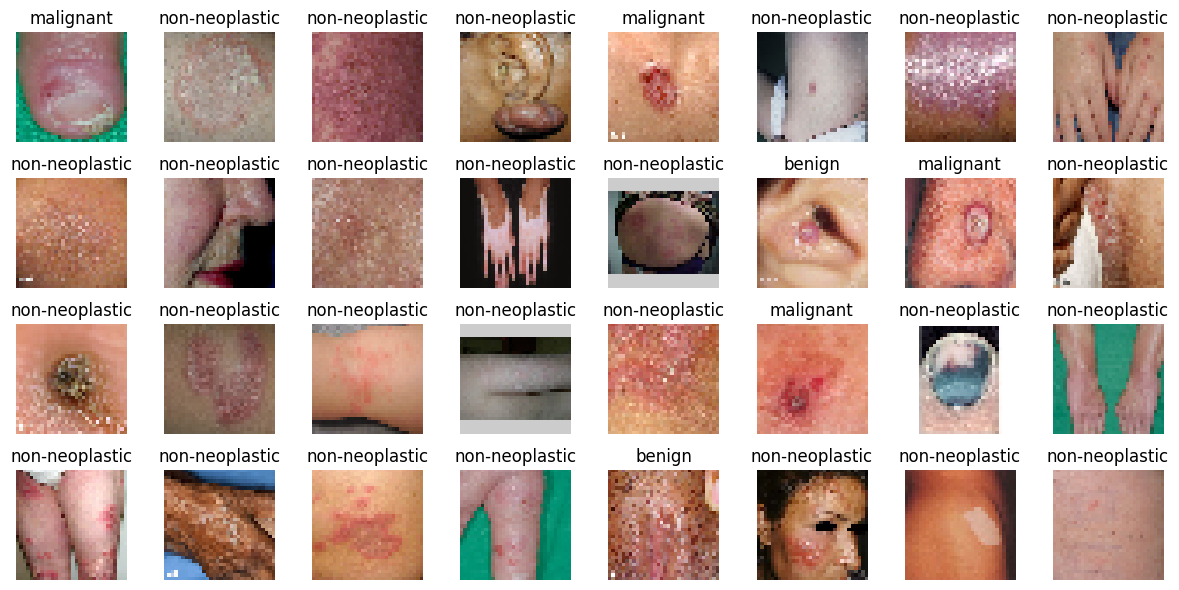

In [2]:
import matplotlib.pyplot as plt
from dataloader import CLASSES

from dataloader import load_cifars, load_fitzpatrick
trainloaders, valloaders, testloader = load_fitzpatrick(1, './data/images/')
# trainloaders, valloaders, testloader = load_cifars(1)

images, labels = next(iter(testloader))


# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

print('image shape', images[0].shape)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

In [3]:
trainloaders, valloaders, testloader = load_fitzpatrick(1, './data/images/')

trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(3):
    net.train_epoch(trainloader, 1)
    loss, accuracy = net.test(valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = net.test(testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

train set loaded, length:  14781
test set loaded, length:  1641


/home/hung/PythonProject/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1: train loss 0.025544989854097366, accuracy 0.7253251146357964
Epoch 1: validation loss 0.024038163670344993, accuracy 0.7273342354533153
Epoch 1: train loss 0.023345649242401123, accuracy 0.7296098624370443


## Fed Average

In [3]:
strategyConfig = {
    "fraction_fit":0.3,
    "fraction_evaluate":0.3,
    "min_fit_clients":3,
    "min_evaluate_clients":3,
    "min_available_clients":NUM_CLIENTS,
}

In [ ]:
net = Net().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.FedAvg, strategyArgs=strategyConfig, net=net, num_rounds=50)

100%|██████████| 170498071/170498071 [00:04<00:00, 34372272.94it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


INFO flwr 2023-06-10 08:59:06,094 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
2023-06-10 08:59:09,323	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-10 08:59:10,858 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7861176731.0, 'object_store_memory': 3930588364.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7861176731.0, 'object_store_memory': 3930588364.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-06-10 08:59:10,867 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-10 08:59:10,875 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-10 08:59:10,883 | server.py:88

Server-side evaluation loss 0.07212100248336792 / accuracy 0.1


(pid=1227) 2023-06-10 08:59:29.365097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=1227) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=1227) Epoch 1: train loss 0.06443459540605545, accuracy 0.2451111111111111


(pid=1299) 2023-06-10 08:59:37.916114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=1299) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=1299) Epoch 1: train loss 0.06423848867416382, accuracy 0.23755555555555555


(pid=1384) 2023-06-10 08:59:48.348419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=1384) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


DEBUG flwr 2023-06-10 08:59:56,522 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-06-10 08:59:56,537 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


(launch_and_fit pid=1384) Epoch 1: train loss 0.06353357434272766, accuracy 0.25266666666666665


INFO flwr 2023-06-10 08:59:59,770 | server.py:119 | fit progress: (1, 0.058994742059707644, {'accuracy': 0.3373}, 37.77030592300002)
INFO:flwr:fit progress: (1, 0.058994742059707644, {'accuracy': 0.3373}, 37.77030592300002)
DEBUG flwr 2023-06-10 08:59:59,775 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.058994742059707644 / accuracy 0.3373


(pid=1506) 2023-06-10 09:00:05.375805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=1506) [Client 8] evaluate, config: {}


(pid=1571) 2023-06-10 09:00:13.204943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=1571) [Client 7] evaluate, config: {}


(pid=1633) 2023-06-10 09:00:19.135066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=1633) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 09:00:23,839 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:00:23,844 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 10)
(pid=1726) 2023-06-10 09:00:31.077273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=1726) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=1726) Epoch 1: train loss 0.056412890553474426, accuracy 0.3428888888888889
(launch_and_fit pid=1726) Epoch 2: train loss 0.05146589130163193, accuracy 0.4008888888888889


(pid=1806) 2023-06-10 09:00:43.066561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(autoscaler +1m59s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +1m59s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_fit pid=1806) [Client 7, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=1806) Epoch 1: train loss 0.05577917397022247, accuracy 0.3428888888888889
(launch_and_fit pid=1806) Epoch 2: train loss 0.05082476884126663, accuracy 0.408


(pid=1893) 2023-06-10 09:00:52.594570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=1893) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=1893) Epoch 1: train loss 0.05717677250504494, accuracy 0.33266666666666667


DEBUG flwr 2023-06-10 09:01:01,902 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=1893) Epoch 2: train loss 0.05242401361465454, accuracy 0.38555555555555554


INFO flwr 2023-06-10 09:01:05,161 | server.py:119 | fit progress: (2, 0.049431411266326906, {'accuracy': 0.4198}, 103.161157772)
INFO:flwr:fit progress: (2, 0.049431411266326906, {'accuracy': 0.4198}, 103.161157772)
DEBUG flwr 2023-06-10 09:01:05,166 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.049431411266326906 / accuracy 0.4198


(pid=2020) 2023-06-10 09:01:12.672719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2020) [Client 0] evaluate, config: {}


(pid=2091) 2023-06-10 09:01:19.109414: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2091) [Client 6] evaluate, config: {}


(pid=2154) 2023-06-10 09:01:25.735652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2154) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 09:01:31,450 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:01:31,454 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 10)
(pid=2245) 2023-06-10 09:01:37.052122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2245) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=2245) Epoch 1: train loss 0.04968206584453583, accuracy 0.41755555555555557
(launch_and_fit pid=2245) Epoch 2: train loss 0.04688708111643791, accuracy 0.45266666666666666


(pid=2330) 2023-06-10 09:01:48.237569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2330) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=2330) Epoch 1: train loss 0.05077614262700081, accuracy 0.41155555555555556
(launch_and_fit pid=2330) Epoch 2: train loss 0.047985002398490906, accuracy 0.444


(pid=2410) 2023-06-10 09:01:59.376233: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2410) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=2410) Epoch 1: train loss 0.05063796043395996, accuracy 0.41333333333333333


DEBUG flwr 2023-06-10 09:02:07,551 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures


(launch_and_fit pid=2410) Epoch 2: train loss 0.048101913183927536, accuracy 0.43866666666666665


INFO flwr 2023-06-10 09:02:10,926 | server.py:119 | fit progress: (3, 0.04630721968412399, {'accuracy': 0.4614}, 168.926909864)
INFO:flwr:fit progress: (3, 0.04630721968412399, {'accuracy': 0.4614}, 168.926909864)
DEBUG flwr 2023-06-10 09:02:10,934 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04630721968412399 / accuracy 0.4614


(pid=2544) 2023-06-10 09:02:18.879629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2544) [Client 7] evaluate, config: {}


(pid=2608) 2023-06-10 09:02:24.967141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2608) [Client 3] evaluate, config: {}


(pid=2679) 2023-06-10 09:02:32.926721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2679) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 09:02:36,997 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:02:37,003 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 10)
(pid=2761) 2023-06-10 09:02:43.462806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2761) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=2761) Epoch 1: train loss 0.04713353142142296, accuracy 0.4528888888888889
(launch_and_fit pid=2761) Epoch 2: train loss 0.04462435469031334, accuracy 0.48133333333333334


(pid=2857) 2023-06-10 09:02:56.205102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2857) [Client 6, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=2857) Epoch 1: train loss 0.04820726439356804, accuracy 0.4371111111111111
(launch_and_fit pid=2857) Epoch 2: train loss 0.045341990888118744, accuracy 0.47333333333333333


(pid=2943) 2023-06-10 09:03:07.383100: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2943) [Client 7, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=2943) Epoch 1: train loss 0.04677756875753403, accuracy 0.4562222222222222


DEBUG flwr 2023-06-10 09:03:15,263 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures


(launch_and_fit pid=2943) Epoch 2: train loss 0.04392033442854881, accuracy 0.4888888888888889


INFO flwr 2023-06-10 09:03:19,800 | server.py:119 | fit progress: (4, 0.044525167006254196, {'accuracy': 0.481}, 237.80037791700002)
INFO:flwr:fit progress: (4, 0.044525167006254196, {'accuracy': 0.481}, 237.80037791700002)
DEBUG flwr 2023-06-10 09:03:19,804 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.044525167006254196 / accuracy 0.481


(pid=3066) 2023-06-10 09:03:25.440357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3066) [Client 1] evaluate, config: {}


(pid=3131) 2023-06-10 09:03:33.343653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3131) [Client 8] evaluate, config: {}


(pid=3201) 2023-06-10 09:03:39.604172: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3201) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 09:03:43,814 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:03:43,821 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 10)
(pid=3288) 2023-06-10 09:03:51.913806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3288) [Client 1, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=3288) Epoch 1: train loss 0.04500428959727287, accuracy 0.4802222222222222
(launch_and_fit pid=3288) Epoch 2: train loss 0.04200844094157219, accuracy 0.5155555555555555


(pid=3370) 2023-06-10 09:04:02.235184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3370) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=3370) Epoch 1: train loss 0.04528455063700676, accuracy 0.4782222222222222
(launch_and_fit pid=3370) Epoch 2: train loss 0.04319670423865318, accuracy 0.49822222222222223


(pid=3458) 2023-06-10 09:04:12.685663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3458) [Client 8, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=3458) Epoch 1: train loss 0.04499439895153046, accuracy 0.47733333333333333


DEBUG flwr 2023-06-10 09:04:21,877 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=3458) Epoch 2: train loss 0.04240494221448898, accuracy 0.5142222222222222


INFO flwr 2023-06-10 09:04:25,140 | server.py:119 | fit progress: (5, 0.042817185640335084, {'accuracy': 0.5012}, 303.140540536)
INFO:flwr:fit progress: (5, 0.042817185640335084, {'accuracy': 0.5012}, 303.140540536)
DEBUG flwr 2023-06-10 09:04:25,145 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.042817185640335084 / accuracy 0.5012


(pid=3580) 2023-06-10 09:04:30.686660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3580) [Client 1] evaluate, config: {}


(pid=3651) 2023-06-10 09:04:38.782013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3651) [Client 8] evaluate, config: {}


(pid=3715) 2023-06-10 09:04:44.884889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3715) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 09:04:50,537 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:04:50,540 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 10)
(pid=3806) 2023-06-10 09:04:56.615264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3806) [Client 1, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=3806) Epoch 1: train loss 0.04198566451668739, accuracy 0.5182222222222223
(launch_and_fit pid=3806) Epoch 2: train loss 0.03950103744864464, accuracy 0.5348888888888889


(pid=3888) 2023-06-10 09:05:07.779072: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3888) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=3888) Epoch 1: train loss 0.044490136206150055, accuracy 0.4875555555555556
(launch_and_fit pid=3888) Epoch 2: train loss 0.04151823744177818, accuracy 0.5155555555555555


(pid=3969) 2023-06-10 09:05:16.774326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3969) [Client 2, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=3969) Epoch 1: train loss 0.044137775897979736, accuracy 0.49466666666666664


DEBUG flwr 2023-06-10 09:05:26,484 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures


(launch_and_fit pid=3969) Epoch 2: train loss 0.04147207736968994, accuracy 0.5242222222222223


INFO flwr 2023-06-10 09:05:29,679 | server.py:119 | fit progress: (6, 0.04181643841862678, {'accuracy': 0.5136}, 367.67967329300006)
INFO:flwr:fit progress: (6, 0.04181643841862678, {'accuracy': 0.5136}, 367.67967329300006)
DEBUG flwr 2023-06-10 09:05:29,686 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04181643841862678 / accuracy 0.5136


(pid=4094) 2023-06-10 09:05:37.757627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4094) [Client 8] evaluate, config: {}


(pid=4165) 2023-06-10 09:05:43.400707: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4165) [Client 4] evaluate, config: {}


(pid=4227) 2023-06-10 09:05:50.769861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4227) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 09:05:57,119 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:05:57,122 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 10)
(pid=4328) 2023-06-10 09:06:03.534930: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=4328) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=4328) Epoch 1: train loss 0.0441940538585186, accuracy 0.4826666666666667
(launch_and_fit pid=4328) Epoch 2: train loss 0.041670192033052444, accuracy 0.5173333333333333


(pid=4413) 2023-06-10 09:06:15.192601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=4413) [Client 6, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=4413) Epoch 1: train loss 0.043025873601436615, accuracy 0.4971111111111111
(launch_and_fit pid=4413) Epoch 2: train loss 0.04066547751426697, accuracy 0.5291111111111111


(pid=4501) 2023-06-10 09:06:26.333899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=4501) [Client 3, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=4501) Epoch 1: train loss 0.04234830290079117, accuracy 0.5095555555555555


DEBUG flwr 2023-06-10 09:06:33,537 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=4501) Epoch 2: train loss 0.03949225693941116, accuracy 0.546


INFO flwr 2023-06-10 09:06:37,661 | server.py:119 | fit progress: (7, 0.04123097580075264, {'accuracy': 0.527}, 435.66143525000007)
INFO:flwr:fit progress: (7, 0.04123097580075264, {'accuracy': 0.527}, 435.66143525000007)
DEBUG flwr 2023-06-10 09:06:37,668 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04123097580075264 / accuracy 0.527


(pid=4623) 2023-06-10 09:06:44.120511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4623) [Client 8] evaluate, config: {}


(pid=4685) 2023-06-10 09:06:50.380419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4685) [Client 7] evaluate, config: {}


(pid=4760) 2023-06-10 09:06:58.678918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4760) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 09:07:02,725 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:07:02,731 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 8: strategy sampled 3 clients (out of 10)
(pid=4842) 2023-06-10 09:07:10.644689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=4842) [Client 7, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=4842) Epoch 1: train loss 0.040935955941677094, accuracy 0.5293333333333333
(launch_and_fit pid=4842) Epoch 2: train loss 0.03807704523205757, accuracy 0.5593333333333333


(pid=4927) 2023-06-10 09:07:19.934422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=4927) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=4927) Epoch 1: train loss 0.04157638177275658, accuracy 0.5168888888888888
(launch_and_fit pid=4927) Epoch 2: train loss 0.038818035274744034, accuracy 0.5511111111111111


(pid=5015) 2023-06-10 09:07:31.278346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5015) [Client 4, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=5015) Epoch 1: train loss 0.04131738841533661, accuracy 0.5333333333333333


DEBUG flwr 2023-06-10 09:07:39,105 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures


(launch_and_fit pid=5015) Epoch 2: train loss 0.038090530782938004, accuracy 0.5664444444444444


INFO flwr 2023-06-10 09:07:43,588 | server.py:119 | fit progress: (8, 0.04010305799245834, {'accuracy': 0.5327}, 501.5880308730001)
INFO:flwr:fit progress: (8, 0.04010305799245834, {'accuracy': 0.5327}, 501.5880308730001)
DEBUG flwr 2023-06-10 09:07:43,595 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04010305799245834 / accuracy 0.5327


(pid=5137) 2023-06-10 09:07:49.188867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5137) [Client 9] evaluate, config: {}


(pid=5201) 2023-06-10 09:07:57.333527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5201) [Client 5] evaluate, config: {}


(pid=5270) 2023-06-10 09:08:03.492334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5270) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 09:08:07,538 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:08:07,545 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 9: strategy sampled 3 clients (out of 10)
(pid=5358) 2023-06-10 09:08:15.585723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5358) [Client 6, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=5358) Epoch 1: train loss 0.04051949456334114, accuracy 0.5317777777777778
(launch_and_fit pid=5358) Epoch 2: train loss 0.03756514936685562, accuracy 0.5655555555555556


(pid=5433) 2023-06-10 09:08:26.049097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5433) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=5433) Epoch 1: train loss 0.039558906108140945, accuracy 0.5384444444444444
(launch_and_fit pid=5433) Epoch 2: train loss 0.036184344440698624, accuracy 0.5804444444444444


(pid=5523) 2023-06-10 09:08:36.398985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5523) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=5523) Epoch 1: train loss 0.03910664841532707, accuracy 0.5464444444444444


DEBUG flwr 2023-06-10 09:08:45,580 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=5523) Epoch 2: train loss 0.03556646779179573, accuracy 0.5902222222222222


INFO flwr 2023-06-10 09:08:48,750 | server.py:119 | fit progress: (9, 0.039625505328178406, {'accuracy': 0.5429}, 566.750565765)
INFO:flwr:fit progress: (9, 0.039625505328178406, {'accuracy': 0.5429}, 566.750565765)
DEBUG flwr 2023-06-10 09:08:48,757 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.039625505328178406 / accuracy 0.5429


(pid=5637) 2023-06-10 09:08:54.332088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5637) [Client 2] evaluate, config: {}


(pid=5712) 2023-06-10 09:09:04.314761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5712) [Client 8] evaluate, config: {}


(pid=5782) 2023-06-10 09:09:12.170594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5782) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 09:09:17,656 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:09:17,664 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 10: strategy sampled 3 clients (out of 10)
(pid=5871) 2023-06-10 09:09:23.234040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5871) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=5871) Epoch 1: train loss 0.03934875875711441, accuracy 0.546
(launch_and_fit pid=5871) Epoch 2: train loss 0.036151643842458725, accuracy 0.5893333333333334


(pid=5956) 2023-06-10 09:09:34.492011: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5956) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=5956) Epoch 1: train loss 0.03872651606798172, accuracy 0.5571111111111111
(launch_and_fit pid=5956) Epoch 2: train loss 0.03578031435608864, accuracy 0.5842222222222222


(pid=6036) 2023-06-10 09:09:45.768887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6036) [Client 7, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=6036) Epoch 1: train loss 0.03692618012428284, accuracy 0.5731111111111111


DEBUG flwr 2023-06-10 09:09:53,359 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures


(launch_and_fit pid=6036) Epoch 2: train loss 0.03370920196175575, accuracy 0.6151111111111112


INFO flwr 2023-06-10 09:09:56,715 | server.py:119 | fit progress: (10, 0.03961672530174255, {'accuracy': 0.5495}, 634.7151444790001)
INFO:flwr:fit progress: (10, 0.03961672530174255, {'accuracy': 0.5495}, 634.7151444790001)
DEBUG flwr 2023-06-10 09:09:56,722 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03961672530174255 / accuracy 0.5495


(pid=6168) 2023-06-10 09:10:04.937760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6168) [Client 0] evaluate, config: {}


(pid=6228) 2023-06-10 09:10:10.962233: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6228) [Client 1] evaluate, config: {}


(pid=6293) 2023-06-10 09:10:18.958125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6293) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 09:10:23,055 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:10:23,060 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 11: strategy sampled 3 clients (out of 10)
(pid=6375) 2023-06-10 09:10:29.995617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6375) [Client 3, round 11] fit, config: {'server_round': 11, 'local_epochs': 2}
(launch_and_fit pid=6375) Epoch 1: train loss 0.03737497329711914, accuracy 0.5811111111111111
(launch_and_fit pid=6375) Epoch 2: train loss 0.03365171328186989, accuracy 0.6157777777777778


(pid=6463) 2023-06-10 09:10:40.283360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6463) [Client 5, round 11] fit, config: {'server_round': 11, 'local_epochs': 2}
(launch_and_fit pid=6463) Epoch 1: train loss 0.03743041679263115, accuracy 0.5737777777777778
(launch_and_fit pid=6463) Epoch 2: train loss 0.0336233414709568, accuracy 0.6233333333333333


(pid=6552) 2023-06-10 09:10:52.183280: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6552) [Client 0, round 11] fit, config: {'server_round': 11, 'local_epochs': 2}
(launch_and_fit pid=6552) Epoch 1: train loss 0.04029538854956627, accuracy 0.5373333333333333


DEBUG flwr 2023-06-10 09:11:00,150 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG:flwr:fit_round 11 received 3 results and 0 failures


(launch_and_fit pid=6552) Epoch 2: train loss 0.03626084327697754, accuracy 0.5866666666666667


INFO flwr 2023-06-10 09:11:04,887 | server.py:119 | fit progress: (11, 0.03853279486894608, {'accuracy': 0.5616}, 702.887464755)
INFO:flwr:fit progress: (11, 0.03853279486894608, {'accuracy': 0.5616}, 702.887464755)
DEBUG flwr 2023-06-10 09:11:04,895 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 11: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03853279486894608 / accuracy 0.5616


(pid=6670) 2023-06-10 09:11:10.494963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6670) [Client 6] evaluate, config: {}


(pid=6730) 2023-06-10 09:11:18.691673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6730) [Client 7] evaluate, config: {}


(pid=6799) 2023-06-10 09:11:25.056088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6799) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 09:11:29,332 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:11:29,335 | server.py:218 | fit_round 12: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 12: strategy sampled 3 clients (out of 10)
(pid=6894) 2023-06-10 09:11:37.623946: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6894) [Client 6, round 12] fit, config: {'server_round': 12, 'local_epochs': 2}
(launch_and_fit pid=6894) Epoch 1: train loss 0.038199830800294876, accuracy 0.5608888888888889
(launch_and_fit pid=6894) Epoch 2: train loss 0.03462745621800423, accuracy 0.606


(pid=6968) 2023-06-10 09:11:48.703736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6968) [Client 7, round 12] fit, config: {'server_round': 12, 'local_epochs': 2}
(launch_and_fit pid=6968) Epoch 1: train loss 0.03566255047917366, accuracy 0.5917777777777777
(launch_and_fit pid=6968) Epoch 2: train loss 0.03203843533992767, accuracy 0.632


(pid=7059) 2023-06-10 09:11:58.758976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7059) [Client 1, round 12] fit, config: {'server_round': 12, 'local_epochs': 2}
(launch_and_fit pid=7059) Epoch 1: train loss 0.03616185113787651, accuracy 0.5924444444444444


DEBUG flwr 2023-06-10 09:12:08,154 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG:flwr:fit_round 12 received 3 results and 0 failures


(launch_and_fit pid=7059) Epoch 2: train loss 0.03213348612189293, accuracy 0.6322222222222222


INFO flwr 2023-06-10 09:12:13,017 | server.py:119 | fit progress: (12, 0.038028186929225924, {'accuracy': 0.57}, 771.017312237)
INFO:flwr:fit progress: (12, 0.038028186929225924, {'accuracy': 0.57}, 771.017312237)
DEBUG flwr 2023-06-10 09:12:13,021 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 12: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.038028186929225924 / accuracy 0.57


(pid=7189) 2023-06-10 09:12:21.618515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7189) [Client 3] evaluate, config: {}


(pid=7260) 2023-06-10 09:12:27.675084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7260) [Client 4] evaluate, config: {}


(pid=7320) 2023-06-10 09:12:35.840707: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7320) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 09:12:40,485 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:12:40,493 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 13: strategy sampled 3 clients (out of 10)
(pid=7408) 2023-06-10 09:12:45.979568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7408) [Client 1, round 13] fit, config: {'server_round': 13, 'local_epochs': 2}
(launch_and_fit pid=7408) Epoch 1: train loss 0.033673375844955444, accuracy 0.6157777777777778
(launch_and_fit pid=7408) Epoch 2: train loss 0.029686961323022842, accuracy 0.6633333333333333


(pid=7494) 2023-06-10 09:12:57.422364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7494) [Client 4, round 13] fit, config: {'server_round': 13, 'local_epochs': 2}
(launch_and_fit pid=7494) Epoch 1: train loss 0.03864216431975365, accuracy 0.5624444444444444
(launch_and_fit pid=7494) Epoch 2: train loss 0.03448326885700226, accuracy 0.6066666666666667


(pid=7578) 2023-06-10 09:13:09.001299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7578) [Client 0, round 13] fit, config: {'server_round': 13, 'local_epochs': 2}
(launch_and_fit pid=7578) Epoch 1: train loss 0.03781432658433914, accuracy 0.5704444444444444


DEBUG flwr 2023-06-10 09:13:16,020 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG:flwr:fit_round 13 received 3 results and 0 failures


(launch_and_fit pid=7578) Epoch 2: train loss 0.033645860850811005, accuracy 0.6195555555555555


INFO flwr 2023-06-10 09:13:19,752 | server.py:119 | fit progress: (13, 0.03768042562603951, {'accuracy': 0.5715}, 837.7523154990001)
INFO:flwr:fit progress: (13, 0.03768042562603951, {'accuracy': 0.5715}, 837.7523154990001)
DEBUG flwr 2023-06-10 09:13:19,762 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 13: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03768042562603951 / accuracy 0.5715


(pid=7701) 2023-06-10 09:13:27.181981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7701) [Client 1] evaluate, config: {}


(pid=7762) 2023-06-10 09:13:33.232584: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7762) [Client 8] evaluate, config: {}


(pid=7830) 2023-06-10 09:13:41.309635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7830) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 09:13:45,466 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:13:45,470 | server.py:218 | fit_round 14: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 14: strategy sampled 3 clients (out of 10)
(pid=7910) 2023-06-10 09:13:53.291663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7910) [Client 2, round 14] fit, config: {'server_round': 14, 'local_epochs': 2}
(launch_and_fit pid=7910) Epoch 1: train loss 0.03884425014257431, accuracy 0.5511111111111111
(launch_and_fit pid=7910) Epoch 2: train loss 0.03447192534804344, accuracy 0.6042222222222222


(pid=7996) 2023-06-10 09:14:02.739050: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7996) [Client 6, round 14] fit, config: {'server_round': 14, 'local_epochs': 2}
(launch_and_fit pid=7996) Epoch 1: train loss 0.03598417714238167, accuracy 0.5926666666666667
(launch_and_fit pid=7996) Epoch 2: train loss 0.03261033073067665, accuracy 0.6293333333333333


(pid=8084) 2023-06-10 09:14:14.118149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8084) [Client 3, round 14] fit, config: {'server_round': 14, 'local_epochs': 2}
(launch_and_fit pid=8084) Epoch 1: train loss 0.03603023663163185, accuracy 0.5911111111111111


DEBUG flwr 2023-06-10 09:14:22,216 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG:flwr:fit_round 14 received 3 results and 0 failures


(launch_and_fit pid=8084) Epoch 2: train loss 0.03155392035841942, accuracy 0.6431111111111111


INFO flwr 2023-06-10 09:14:26,834 | server.py:119 | fit progress: (14, 0.03746793894171715, {'accuracy': 0.5693}, 904.834954834)
INFO:flwr:fit progress: (14, 0.03746793894171715, {'accuracy': 0.5693}, 904.834954834)
DEBUG flwr 2023-06-10 09:14:26,843 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 14: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03746793894171715 / accuracy 0.5693


(pid=8203) 2023-06-10 09:14:32.450132: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=8203) [Client 1] evaluate, config: {}


(pid=8264) 2023-06-10 09:14:40.883991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=8264) [Client 4] evaluate, config: {}


(pid=8332) 2023-06-10 09:14:46.854578: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=8332) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 09:14:50,983 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:14:50,986 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 15: strategy sampled 3 clients (out of 10)
(pid=8423) 2023-06-10 09:14:59.219326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8423) [Client 2, round 15] fit, config: {'server_round': 15, 'local_epochs': 2}
(launch_and_fit pid=8423) Epoch 1: train loss 0.0359860323369503, accuracy 0.5893333333333334
(launch_and_fit pid=8423) Epoch 2: train loss 0.031990375369787216, accuracy 0.6404444444444445


(pid=8503) 2023-06-10 09:15:10.091907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8503) [Client 3, round 15] fit, config: {'server_round': 15, 'local_epochs': 2}
(launch_and_fit pid=8503) Epoch 1: train loss 0.0334157794713974, accuracy 0.6246666666666667
(launch_and_fit pid=8503) Epoch 2: train loss 0.029311446473002434, accuracy 0.6697777777777778


(pid=8591) 2023-06-10 09:15:22.626752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8591) [Client 7, round 15] fit, config: {'server_round': 15, 'local_epochs': 2}
(launch_and_fit pid=8591) Epoch 1: train loss 0.033765729516744614, accuracy 0.6113333333333333


DEBUG flwr 2023-06-10 09:15:32,024 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG:flwr:fit_round 15 received 3 results and 0 failures


(launch_and_fit pid=8591) Epoch 2: train loss 0.02937094122171402, accuracy 0.6688888888888889


INFO flwr 2023-06-10 09:15:35,293 | server.py:119 | fit progress: (15, 0.03792362099289894, {'accuracy': 0.5769}, 973.293381229)
INFO:flwr:fit progress: (15, 0.03792362099289894, {'accuracy': 0.5769}, 973.293381229)
DEBUG flwr 2023-06-10 09:15:35,301 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 15: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03792362099289894 / accuracy 0.5769


(pid=8722) 2023-06-10 09:15:43.477537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=8722) [Client 5] evaluate, config: {}


(pid=8787) 2023-06-10 09:15:49.339841: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=8787) [Client 7] evaluate, config: {}


(pid=8847) 2023-06-10 09:15:57.158658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=8847) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 09:16:02,068 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:16:02,075 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 16: strategy sampled 3 clients (out of 10)
(pid=8941) 2023-06-10 09:16:07.681487: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8941) [Client 7, round 16] fit, config: {'server_round': 16, 'local_epochs': 2}
(launch_and_fit pid=8941) Epoch 1: train loss 0.031684160232543945, accuracy 0.6384444444444445
(launch_and_fit pid=8941) Epoch 2: train loss 0.027129195630550385, accuracy 0.6997777777777778


(pid=9025) 2023-06-10 09:16:19.037867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9025) [Client 4, round 16] fit, config: {'server_round': 16, 'local_epochs': 2}
(launch_and_fit pid=9025) Epoch 1: train loss 0.03600636497139931, accuracy 0.5977777777777777
(launch_and_fit pid=9025) Epoch 2: train loss 0.031779542565345764, accuracy 0.6415555555555555


(pid=9107) 2023-06-10 09:16:30.978584: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9107) [Client 5, round 16] fit, config: {'server_round': 16, 'local_epochs': 2}
(launch_and_fit pid=9107) Epoch 1: train loss 0.03591211885213852, accuracy 0.5917777777777777


DEBUG flwr 2023-06-10 09:16:38,435 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG:flwr:fit_round 16 received 3 results and 0 failures


(launch_and_fit pid=9107) Epoch 2: train loss 0.031217539682984352, accuracy 0.6448888888888888


INFO flwr 2023-06-10 09:16:42,257 | server.py:119 | fit progress: (16, 0.03721739783287048, {'accuracy': 0.5806}, 1040.257261052)
INFO:flwr:fit progress: (16, 0.03721739783287048, {'accuracy': 0.5806}, 1040.257261052)
DEBUG flwr 2023-06-10 09:16:42,263 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 16: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03721739783287048 / accuracy 0.5806


(pid=9233) 2023-06-10 09:16:49.707314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9233) [Client 7] evaluate, config: {}


(pid=9297) 2023-06-10 09:16:55.986480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9297) [Client 1] evaluate, config: {}


(pid=9368) 2023-06-10 09:17:04.421454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9368) [Client 8] evaluate, config: {}


DEBUG flwr 2023-06-10 09:17:08,488 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:17:08,495 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 17: strategy sampled 3 clients (out of 10)
(pid=9448) 2023-06-10 09:17:16.249486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9448) [Client 9, round 17] fit, config: {'server_round': 17, 'local_epochs': 2}
(launch_and_fit pid=9448) Epoch 1: train loss 0.03852130100131035, accuracy 0.5602222222222222
(launch_and_fit pid=9448) Epoch 2: train loss 0.0338752456009388, accuracy 0.6133333333333333


(pid=9535) 2023-06-10 09:17:26.317451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9535) [Client 2, round 17] fit, config: {'server_round': 17, 'local_epochs': 2}
(launch_and_fit pid=9535) Epoch 1: train loss 0.034561142325401306, accuracy 0.606
(launch_and_fit pid=9535) Epoch 2: train loss 0.02992074005305767, accuracy 0.6646666666666666


(pid=9621) 2023-06-10 09:17:37.730941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9621) [Client 4, round 17] fit, config: {'server_round': 17, 'local_epochs': 2}
(launch_and_fit pid=9621) Epoch 1: train loss 0.03375011309981346, accuracy 0.6068888888888889


DEBUG flwr 2023-06-10 09:17:46,262 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG:flwr:fit_round 17 received 3 results and 0 failures


(launch_and_fit pid=9621) Epoch 2: train loss 0.029614919796586037, accuracy 0.6644444444444444


INFO flwr 2023-06-10 09:17:50,477 | server.py:119 | fit progress: (17, 0.036637556761503216, {'accuracy': 0.5856}, 1108.477243403)
INFO:flwr:fit progress: (17, 0.036637556761503216, {'accuracy': 0.5856}, 1108.477243403)
DEBUG flwr 2023-06-10 09:17:50,483 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 17: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.036637556761503216 / accuracy 0.5856


(pid=9739) 2023-06-10 09:17:56.070118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9739) [Client 5] evaluate, config: {}


(pid=9805) 2023-06-10 09:18:04.343752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9805) [Client 4] evaluate, config: {}


(pid=9874) 2023-06-10 09:18:10.231985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9874) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 09:18:14,321 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:18:14,324 | server.py:218 | fit_round 18: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 18: strategy sampled 3 clients (out of 10)
(pid=9962) 2023-06-10 09:18:22.209526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9962) [Client 2, round 18] fit, config: {'server_round': 18, 'local_epochs': 2}
(launch_and_fit pid=9962) Epoch 1: train loss 0.03158050775527954, accuracy 0.6415555555555555
(launch_and_fit pid=9962) Epoch 2: train loss 0.027604956179857254, accuracy 0.6891111111111111


(pid=10039) 2023-06-10 09:18:35.064455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10039) [Client 8, round 18] fit, config: {'server_round': 18, 'local_epochs': 2}
(launch_and_fit pid=10039) Epoch 1: train loss 0.03675451874732971, accuracy 0.5848888888888889
(launch_and_fit pid=10039) Epoch 2: train loss 0.03183948993682861, accuracy 0.6446666666666667


(pid=10136) 2023-06-10 09:18:45.848062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10136) [Client 9, round 18] fit, config: {'server_round': 18, 'local_epochs': 2}
(launch_and_fit pid=10136) Epoch 1: train loss 0.03582830727100372, accuracy 0.5882222222222222


DEBUG flwr 2023-06-10 09:18:54,934 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG:flwr:fit_round 18 received 3 results and 0 failures


(launch_and_fit pid=10136) Epoch 2: train loss 0.0310821533203125, accuracy 0.6497777777777778


INFO flwr 2023-06-10 09:18:58,193 | server.py:119 | fit progress: (18, 0.036344866889715194, {'accuracy': 0.5936}, 1176.193237447)
INFO:flwr:fit progress: (18, 0.036344866889715194, {'accuracy': 0.5936}, 1176.193237447)
DEBUG flwr 2023-06-10 09:18:58,202 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 18: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.036344866889715194 / accuracy 0.5936


(pid=10256) 2023-06-10 09:19:03.670814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10256) [Client 9] evaluate, config: {}


(pid=10328) 2023-06-10 09:19:11.909012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10328) [Client 0] evaluate, config: {}


(pid=10388) 2023-06-10 09:19:17.987277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10388) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 09:19:23,300 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:19:23,304 | server.py:218 | fit_round 19: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 19: strategy sampled 3 clients (out of 10)
(pid=10481) 2023-06-10 09:19:29.663715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10481) [Client 2, round 19] fit, config: {'server_round': 19, 'local_epochs': 2}
(launch_and_fit pid=10481) Epoch 1: train loss 0.02985725924372673, accuracy 0.6646666666666666
(launch_and_fit pid=10481) Epoch 2: train loss 0.02495240606367588, accuracy 0.7217777777777777


(pid=10563) 2023-06-10 09:19:41.156578: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10563) [Client 1, round 19] fit, config: {'server_round': 19, 'local_epochs': 2}
(launch_and_fit pid=10563) Epoch 1: train loss 0.033156223595142365, accuracy 0.62
(launch_and_fit pid=10563) Epoch 2: train loss 0.02840556390583515, accuracy 0.6817777777777778


(pid=10644) 2023-06-10 09:19:50.130451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10644) [Client 5, round 19] fit, config: {'server_round': 19, 'local_epochs': 2}
(launch_and_fit pid=10644) Epoch 1: train loss 0.03422359749674797, accuracy 0.6104444444444445


DEBUG flwr 2023-06-10 09:19:59,757 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG:flwr:fit_round 19 received 3 results and 0 failures


(launch_and_fit pid=10644) Epoch 2: train loss 0.02917264588177204, accuracy 0.6735555555555556


INFO flwr 2023-06-10 09:20:03,044 | server.py:119 | fit progress: (19, 0.03761822707056999, {'accuracy': 0.5834}, 1241.044146905)
INFO:flwr:fit progress: (19, 0.03761822707056999, {'accuracy': 0.5834}, 1241.044146905)
DEBUG flwr 2023-06-10 09:20:03,052 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 19: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03761822707056999 / accuracy 0.5834


(pid=10772) 2023-06-10 09:20:10.845805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10772) [Client 0] evaluate, config: {}


(pid=10842) 2023-06-10 09:20:17.214573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10842) [Client 3] evaluate, config: {}


(pid=10902) 2023-06-10 09:20:24.705900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10902) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 09:20:29,580 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:20:29,587 | server.py:218 | fit_round 20: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 20: strategy sampled 3 clients (out of 10)
(pid=10995) 2023-06-10 09:20:35.216669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10995) [Client 5, round 20] fit, config: {'server_round': 20, 'local_epochs': 2}
(launch_and_fit pid=10995) Epoch 1: train loss 0.03129987791180611, accuracy 0.6466666666666666
(launch_and_fit pid=10995) Epoch 2: train loss 0.026568837463855743, accuracy 0.696


(pid=11078) 2023-06-10 09:20:46.355586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11078) [Client 8, round 20] fit, config: {'server_round': 20, 'local_epochs': 2}
(launch_and_fit pid=11078) Epoch 1: train loss 0.03451202064752579, accuracy 0.6135555555555555
(launch_and_fit pid=11078) Epoch 2: train loss 0.029397184029221535, accuracy 0.6648888888888889


(pid=11158) 2023-06-10 09:20:58.508679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11158) [Client 2, round 20] fit, config: {'server_round': 20, 'local_epochs': 2}
(launch_and_fit pid=11158) Epoch 1: train loss 0.027391014620661736, accuracy 0.6904444444444444


DEBUG flwr 2023-06-10 09:21:05,515 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG:flwr:fit_round 20 received 3 results and 0 failures


(launch_and_fit pid=11158) Epoch 2: train loss 0.022712113335728645, accuracy 0.7471111111111111


INFO flwr 2023-06-10 09:21:08,895 | server.py:119 | fit progress: (20, 0.03713839893341064, {'accuracy': 0.593}, 1306.895122111)
INFO:flwr:fit progress: (20, 0.03713839893341064, {'accuracy': 0.593}, 1306.895122111)
DEBUG flwr 2023-06-10 09:21:08,898 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 20: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03713839893341064 / accuracy 0.593


(pid=11286) 2023-06-10 09:21:16.938327: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11286) [Client 0] evaluate, config: {}


(pid=11346) 2023-06-10 09:21:23.103286: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11346) [Client 3] evaluate, config: {}


(pid=11417) 2023-06-10 09:21:30.967003: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11417) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 09:21:35,176 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:21:35,186 | server.py:218 | fit_round 21: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 21: strategy sampled 3 clients (out of 10)
(pid=11501) 2023-06-10 09:21:44.481653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11501) [Client 6, round 21] fit, config: {'server_round': 21, 'local_epochs': 2}
(launch_and_fit pid=11501) Epoch 1: train loss 0.035311438143253326, accuracy 0.6062222222222222
(launch_and_fit pid=11501) Epoch 2: train loss 0.030063025653362274, accuracy 0.666


(pid=11594) 2023-06-10 09:21:55.288102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11594) [Client 9, round 21] fit, config: {'server_round': 21, 'local_epochs': 2}
(launch_and_fit pid=11594) Epoch 1: train loss 0.03453049436211586, accuracy 0.6108888888888889
(launch_and_fit pid=11594) Epoch 2: train loss 0.0287928469479084, accuracy 0.6762222222222222


(pid=11683) 2023-06-10 09:22:06.998962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11683) [Client 3, round 21] fit, config: {'server_round': 21, 'local_epochs': 2}
(launch_and_fit pid=11683) Epoch 1: train loss 0.03308708965778351, accuracy 0.6246666666666667


DEBUG flwr 2023-06-10 09:22:15,092 | server.py:232 | fit_round 21 received 3 results and 0 failures
DEBUG:flwr:fit_round 21 received 3 results and 0 failures


(launch_and_fit pid=11683) Epoch 2: train loss 0.0282762311398983, accuracy 0.6833333333333333


INFO flwr 2023-06-10 09:22:19,934 | server.py:119 | fit progress: (21, 0.036000947761535645, {'accuracy': 0.5953}, 1377.9347168450001)
INFO:flwr:fit progress: (21, 0.036000947761535645, {'accuracy': 0.5953}, 1377.9347168450001)
DEBUG flwr 2023-06-10 09:22:19,941 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 21: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.036000947761535645 / accuracy 0.5953


(pid=11805) 2023-06-10 09:22:25.723632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11805) [Client 0] evaluate, config: {}


(pid=11867) 2023-06-10 09:22:34.193928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11867) [Client 7] evaluate, config: {}


(pid=11936) 2023-06-10 09:22:40.548095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11936) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 09:22:44,640 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:22:44,646 | server.py:218 | fit_round 22: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 22: strategy sampled 3 clients (out of 10)
(pid=12024) 2023-06-10 09:22:52.755403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12024) [Client 3, round 22] fit, config: {'server_round': 22, 'local_epochs': 2}
(launch_and_fit pid=12024) Epoch 1: train loss 0.029983436688780785, accuracy 0.6606666666666666
(launch_and_fit pid=12024) Epoch 2: train loss 0.024791503325104713, accuracy 0.7217777777777777


(pid=12106) 2023-06-10 09:23:03.856027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12106) [Client 6, round 22] fit, config: {'server_round': 22, 'local_epochs': 2}
(launch_and_fit pid=12106) Epoch 1: train loss 0.03193647786974907, accuracy 0.6406666666666667
(launch_and_fit pid=12106) Epoch 2: train loss 0.026904122903943062, accuracy 0.6988888888888889


(pid=12194) 2023-06-10 09:23:13.848524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12194) [Client 5, round 22] fit, config: {'server_round': 22, 'local_epochs': 2}
(launch_and_fit pid=12194) Epoch 1: train loss 0.02956128679215908, accuracy 0.6624444444444444


DEBUG flwr 2023-06-10 09:23:23,236 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG:flwr:fit_round 22 received 3 results and 0 failures


(launch_and_fit pid=12194) Epoch 2: train loss 0.024642905220389366, accuracy 0.7231111111111111


INFO flwr 2023-06-10 09:23:26,456 | server.py:119 | fit progress: (22, 0.03698444929718971, {'accuracy': 0.5935}, 1444.456712853)
INFO:flwr:fit progress: (22, 0.03698444929718971, {'accuracy': 0.5935}, 1444.456712853)
DEBUG flwr 2023-06-10 09:23:26,461 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 22: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03698444929718971 / accuracy 0.5935


(pid=12313) 2023-06-10 09:23:33.107724: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12313) [Client 3] evaluate, config: {}


(pid=12382) 2023-06-10 09:23:40.667790: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12382) [Client 8] evaluate, config: {}


(pid=12442) 2023-06-10 09:23:46.593401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12442) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 09:23:53,056 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:23:53,061 | server.py:218 | fit_round 23: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 23: strategy sampled 3 clients (out of 10)
(pid=12530) 2023-06-10 09:23:58.602559: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12530) [Client 1, round 23] fit, config: {'server_round': 23, 'local_epochs': 2}
(launch_and_fit pid=12530) Epoch 1: train loss 0.03219495713710785, accuracy 0.6355555555555555
(launch_and_fit pid=12530) Epoch 2: train loss 0.026059838011860847, accuracy 0.7088888888888889


(pid=12616) 2023-06-10 09:24:09.917285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12616) [Client 0, round 23] fit, config: {'server_round': 23, 'local_epochs': 2}
(launch_and_fit pid=12616) Epoch 1: train loss 0.03558821976184845, accuracy 0.606
(launch_and_fit pid=12616) Epoch 2: train loss 0.029791491106152534, accuracy 0.6637777777777778


(pid=12692) 2023-06-10 09:24:20.563355: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12692) [Client 4, round 23] fit, config: {'server_round': 23, 'local_epochs': 2}
(launch_and_fit pid=12692) Epoch 1: train loss 0.03361716866493225, accuracy 0.6213333333333333


DEBUG flwr 2023-06-10 09:24:28,832 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG:flwr:fit_round 23 received 3 results and 0 failures


(launch_and_fit pid=12692) Epoch 2: train loss 0.02774888463318348, accuracy 0.6893333333333334


INFO flwr 2023-06-10 09:24:32,155 | server.py:119 | fit progress: (23, 0.035925155544281, {'accuracy': 0.6007}, 1510.155557475)
INFO:flwr:fit progress: (23, 0.035925155544281, {'accuracy': 0.6007}, 1510.155557475)
DEBUG flwr 2023-06-10 09:24:32,164 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 23: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.035925155544281 / accuracy 0.6007


(pid=12824) 2023-06-10 09:24:40.238290: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12824) [Client 5] evaluate, config: {}


(pid=12888) 2023-06-10 09:24:47.302224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12888) [Client 0] evaluate, config: {}


(pid=12965) 2023-06-10 09:24:56.999307: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12965) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 09:25:01,250 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:25:01,258 | server.py:218 | fit_round 24: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 24: strategy sampled 3 clients (out of 10)
(pid=13047) 2023-06-10 09:25:08.625787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13047) [Client 2, round 24] fit, config: {'server_round': 24, 'local_epochs': 2}
(launch_and_fit pid=13047) Epoch 1: train loss 0.02830185741186142, accuracy 0.6771111111111111
(launch_and_fit pid=13047) Epoch 2: train loss 0.022534102201461792, accuracy 0.7513333333333333


(pid=13134) 2023-06-10 09:25:18.810143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13134) [Client 1, round 24] fit, config: {'server_round': 24, 'local_epochs': 2}
(launch_and_fit pid=13134) Epoch 1: train loss 0.028874199837446213, accuracy 0.6768888888888889
(launch_and_fit pid=13134) Epoch 2: train loss 0.023255011066794395, accuracy 0.7377777777777778


(pid=13219) 2023-06-10 09:25:30.109177: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13219) [Client 4, round 24] fit, config: {'server_round': 24, 'local_epochs': 2}
(launch_and_fit pid=13219) Epoch 1: train loss 0.029814647510647774, accuracy 0.6666666666666666


DEBUG flwr 2023-06-10 09:25:38,000 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG:flwr:fit_round 24 received 3 results and 0 failures


(launch_and_fit pid=13219) Epoch 2: train loss 0.024514418095350266, accuracy 0.7297777777777777


INFO flwr 2023-06-10 09:25:42,938 | server.py:119 | fit progress: (24, 0.03739053146243095, {'accuracy': 0.5912}, 1580.9381710950001)
INFO:flwr:fit progress: (24, 0.03739053146243095, {'accuracy': 0.5912}, 1580.9381710950001)
DEBUG flwr 2023-06-10 09:25:42,946 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 24: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03739053146243095 / accuracy 0.5912


(pid=13338) 2023-06-10 09:25:48.485019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=13338) [Client 2] evaluate, config: {}


(pid=13403) 2023-06-10 09:25:56.572331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=13403) [Client 4] evaluate, config: {}


(pid=13473) 2023-06-10 09:26:02.882839: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=13473) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 09:26:07,112 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:26:07,120 | server.py:218 | fit_round 25: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 25: strategy sampled 3 clients (out of 10)
(pid=13562) 2023-06-10 09:26:15.268145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13562) [Client 6, round 25] fit, config: {'server_round': 25, 'local_epochs': 2}
(launch_and_fit pid=13562) Epoch 1: train loss 0.03080384060740471, accuracy 0.6548888888888889
(launch_and_fit pid=13562) Epoch 2: train loss 0.02522697113454342, accuracy 0.7197777777777777


(pid=13637) 2023-06-10 09:26:26.103717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13637) [Client 9, round 25] fit, config: {'server_round': 25, 'local_epochs': 2}
(launch_and_fit pid=13637) Epoch 1: train loss 0.033024583011865616, accuracy 0.6266666666666667
(launch_and_fit pid=13637) Epoch 2: train loss 0.027153607457876205, accuracy 0.6964444444444444


(pid=13727) 2023-06-10 09:26:36.490849: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13727) [Client 4, round 25] fit, config: {'server_round': 25, 'local_epochs': 2}
(launch_and_fit pid=13727) Epoch 1: train loss 0.0275583453476429, accuracy 0.6902222222222222


DEBUG flwr 2023-06-10 09:26:45,827 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG:flwr:fit_round 25 received 3 results and 0 failures


(launch_and_fit pid=13727) Epoch 2: train loss 0.022205226123332977, accuracy 0.7588888888888888


INFO flwr 2023-06-10 09:26:49,088 | server.py:119 | fit progress: (25, 0.03669269217848778, {'accuracy': 0.6031}, 1647.088124077)
INFO:flwr:fit progress: (25, 0.03669269217848778, {'accuracy': 0.6031}, 1647.088124077)
DEBUG flwr 2023-06-10 09:26:49,092 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 25: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03669269217848778 / accuracy 0.6031


(pid=13845) 2023-06-10 09:26:54.826146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=13845) [Client 8] evaluate, config: {}


(pid=13919) 2023-06-10 09:27:03.338028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=13919) [Client 1] evaluate, config: {}


(pid=13980) 2023-06-10 09:27:09.523505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=13980) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 09:27:15,838 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:27:15,842 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 26: strategy sampled 3 clients (out of 10)
(pid=14068) 2023-06-10 09:27:21.397117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14068) [Client 0, round 26] fit, config: {'server_round': 26, 'local_epochs': 2}
(launch_and_fit pid=14068) Epoch 1: train loss 0.033415522426366806, accuracy 0.6235555555555555
(launch_and_fit pid=14068) Epoch 2: train loss 0.02696908451616764, accuracy 0.6913333333333334


(pid=14147) 2023-06-10 09:27:32.635690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14147) [Client 1, round 26] fit, config: {'server_round': 26, 'local_epochs': 2}
(launch_and_fit pid=14147) Epoch 1: train loss 0.027580231428146362, accuracy 0.6897777777777778
(launch_and_fit pid=14147) Epoch 2: train loss 0.021516913548111916, accuracy 0.7553333333333333


(pid=14230) 2023-06-10 09:27:42.756088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14230) [Client 6, round 26] fit, config: {'server_round': 26, 'local_epochs': 2}
(launch_and_fit pid=14230) Epoch 1: train loss 0.02849746122956276, accuracy 0.6786666666666666


DEBUG flwr 2023-06-10 09:27:51,833 | server.py:232 | fit_round 26 received 3 results and 0 failures
DEBUG:flwr:fit_round 26 received 3 results and 0 failures


(launch_and_fit pid=14230) Epoch 2: train loss 0.022838592529296875, accuracy 0.7451111111111111


INFO flwr 2023-06-10 09:27:55,611 | server.py:119 | fit progress: (26, 0.03662150936722756, {'accuracy': 0.6048}, 1713.611722292)
INFO:flwr:fit progress: (26, 0.03662150936722756, {'accuracy': 0.6048}, 1713.611722292)
DEBUG flwr 2023-06-10 09:27:55,620 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 26: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03662150936722756 / accuracy 0.6048


(pid=14370) 2023-06-10 09:28:05.732116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14370) [Client 1] evaluate, config: {}


(pid=14434) 2023-06-10 09:28:11.693116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14434) [Client 7] evaluate, config: {}


(pid=14498) 2023-06-10 09:28:20.257585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14498) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 09:28:24,228 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:28:24,237 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 27: strategy sampled 3 clients (out of 10)
(pid=14583) 2023-06-10 09:28:29.935406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14583) [Client 9, round 27] fit, config: {'server_round': 27, 'local_epochs': 2}
(launch_and_fit pid=14583) Epoch 1: train loss 0.030990583822131157, accuracy 0.6495555555555556
(launch_and_fit pid=14583) Epoch 2: train loss 0.025089837610721588, accuracy 0.7226666666666667


(pid=14672) 2023-06-10 09:28:41.610182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14672) [Client 4, round 27] fit, config: {'server_round': 27, 'local_epochs': 2}
(launch_and_fit pid=14672) Epoch 1: train loss 0.026874519884586334, accuracy 0.7004444444444444
(launch_and_fit pid=14672) Epoch 2: train loss 0.02056904509663582, accuracy 0.7737777777777778


(pid=14756) 2023-06-10 09:28:53.116969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14756) [Client 7, round 27] fit, config: {'server_round': 27, 'local_epochs': 2}
(launch_and_fit pid=14756) Epoch 1: train loss 0.03246729075908661, accuracy 0.642


DEBUG flwr 2023-06-10 09:29:00,561 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG:flwr:fit_round 27 received 3 results and 0 failures


(launch_and_fit pid=14756) Epoch 2: train loss 0.026295559480786324, accuracy 0.7044444444444444


INFO flwr 2023-06-10 09:29:05,279 | server.py:119 | fit progress: (27, 0.037131617230176925, {'accuracy': 0.6029}, 1783.279360945)
INFO:flwr:fit progress: (27, 0.037131617230176925, {'accuracy': 0.6029}, 1783.279360945)
DEBUG flwr 2023-06-10 09:29:05,283 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 27: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.037131617230176925 / accuracy 0.6029


(pid=14878) 2023-06-10 09:29:11.458540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14878) [Client 7] evaluate, config: {}


(pid=14938) 2023-06-10 09:29:18.743294: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14938) [Client 1] evaluate, config: {}


(pid=15011) 2023-06-10 09:29:26.071897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15011) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 09:29:30,272 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:29:30,276 | server.py:218 | fit_round 28: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 28: strategy sampled 3 clients (out of 10)
(pid=15097) 2023-06-10 09:29:38.601340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15097) [Client 8, round 28] fit, config: {'server_round': 28, 'local_epochs': 2}
(launch_and_fit pid=15097) Epoch 1: train loss 0.03314574807882309, accuracy 0.6333333333333333
(launch_and_fit pid=15097) Epoch 2: train loss 0.027278833091259003, accuracy 0.692


(pid=15176) 2023-06-10 09:29:47.926491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15176) [Client 3, round 28] fit, config: {'server_round': 28, 'local_epochs': 2}
(launch_and_fit pid=15176) Epoch 1: train loss 0.03069244511425495, accuracy 0.658
(launch_and_fit pid=15176) Epoch 2: train loss 0.02431529015302658, accuracy 0.7262222222222222


(pid=15265) 2023-06-10 09:29:59.470186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15265) [Client 4, round 28] fit, config: {'server_round': 28, 'local_epochs': 2}
(launch_and_fit pid=15265) Epoch 1: train loss 0.023837249726057053, accuracy 0.7311111111111112


DEBUG flwr 2023-06-10 09:30:08,857 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG:flwr:fit_round 28 received 3 results and 0 failures


(launch_and_fit pid=15265) Epoch 2: train loss 0.017936697229743004, accuracy 0.8077777777777778


INFO flwr 2023-06-10 09:30:12,185 | server.py:119 | fit progress: (28, 0.036849094212055206, {'accuracy': 0.6038}, 1850.185902419)
INFO:flwr:fit progress: (28, 0.036849094212055206, {'accuracy': 0.6038}, 1850.185902419)
DEBUG flwr 2023-06-10 09:30:12,195 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 28: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.036849094212055206 / accuracy 0.6038


(pid=15384) 2023-06-10 09:30:17.865661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15384) [Client 5] evaluate, config: {}


(pid=15453) 2023-06-10 09:30:26.199669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15453) [Client 2] evaluate, config: {}


(pid=15519) 2023-06-10 09:30:32.314525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15519) [Client 8] evaluate, config: {}


DEBUG flwr 2023-06-10 09:30:37,603 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:30:37,609 | server.py:218 | fit_round 29: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 29: strategy sampled 3 clients (out of 10)
(pid=15605) 2023-06-10 09:30:44.144265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15605) [Client 1, round 29] fit, config: {'server_round': 29, 'local_epochs': 2}
(launch_and_fit pid=15605) Epoch 1: train loss 0.026467757299542427, accuracy 0.7035555555555556
(launch_and_fit pid=15605) Epoch 2: train loss 0.020193452015519142, accuracy 0.774


(pid=15694) 2023-06-10 09:30:56.069376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15694) [Client 6, round 29] fit, config: {'server_round': 29, 'local_epochs': 2}
(launch_and_fit pid=15694) Epoch 1: train loss 0.02735159546136856, accuracy 0.6982222222222222
(launch_and_fit pid=15694) Epoch 2: train loss 0.021199580281972885, accuracy 0.7702222222222223


(pid=15775) 2023-06-10 09:31:08.607637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15775) [Client 9, round 29] fit, config: {'server_round': 29, 'local_epochs': 2}
(launch_and_fit pid=15775) Epoch 1: train loss 0.02885107509791851, accuracy 0.6715555555555556


DEBUG flwr 2023-06-10 09:31:17,715 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG:flwr:fit_round 29 received 3 results and 0 failures


(launch_and_fit pid=15775) Epoch 2: train loss 0.022858981043100357, accuracy 0.7471111111111111


INFO flwr 2023-06-10 09:31:21,015 | server.py:119 | fit progress: (29, 0.037320085352659224, {'accuracy': 0.6044}, 1919.015752767)
INFO:flwr:fit progress: (29, 0.037320085352659224, {'accuracy': 0.6044}, 1919.015752767)
DEBUG flwr 2023-06-10 09:31:21,020 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 29: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.037320085352659224 / accuracy 0.6044


(pid=15913) 2023-06-10 09:31:29.390845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15913) [Client 0] evaluate, config: {}


(pid=15976) 2023-06-10 09:31:35.386568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15976) [Client 3] evaluate, config: {}


(pid=16040) 2023-06-10 09:31:43.916827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16040) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 09:31:47,871 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:31:47,874 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 30: strategy sampled 3 clients (out of 10)
(pid=16124) 2023-06-10 09:31:53.577819: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16124) [Client 7, round 30] fit, config: {'server_round': 30, 'local_epochs': 2}
(launch_and_fit pid=16124) Epoch 1: train loss 0.03063896670937538, accuracy 0.6604444444444444
(launch_and_fit pid=16124) Epoch 2: train loss 0.024296147748827934, accuracy 0.7313333333333333


(pid=16214) 2023-06-10 09:32:05.337672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16214) [Client 1, round 30] fit, config: {'server_round': 30, 'local_epochs': 2}
(launch_and_fit pid=16214) Epoch 1: train loss 0.023231036961078644, accuracy 0.732
(launch_and_fit pid=16214) Epoch 2: train loss 0.01749032363295555, accuracy 0.814


(pid=16300) 2023-06-10 09:32:16.705242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16300) [Client 3, round 30] fit, config: {'server_round': 30, 'local_epochs': 2}
(launch_and_fit pid=16300) Epoch 1: train loss 0.02826821617782116, accuracy 0.6822222222222222


DEBUG flwr 2023-06-10 09:32:24,059 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG:flwr:fit_round 30 received 3 results and 0 failures


(launch_and_fit pid=16300) Epoch 2: train loss 0.022223107516765594, accuracy 0.7513333333333333


INFO flwr 2023-06-10 09:32:28,953 | server.py:119 | fit progress: (30, 0.037740140450000764, {'accuracy': 0.5966}, 1986.953160245)
INFO:flwr:fit progress: (30, 0.037740140450000764, {'accuracy': 0.5966}, 1986.953160245)
DEBUG flwr 2023-06-10 09:32:28,957 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 30: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.037740140450000764 / accuracy 0.5966


(pid=16424) 2023-06-10 09:32:35.198735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16424) [Client 6] evaluate, config: {}


(pid=16484) 2023-06-10 09:32:42.501771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16484) [Client 1] evaluate, config: {}


(pid=16557) 2023-06-10 09:32:49.964995: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16557) [Client 8] evaluate, config: {}


DEBUG flwr 2023-06-10 09:32:54,103 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:32:54,112 | server.py:218 | fit_round 31: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 31: strategy sampled 3 clients (out of 10)
(pid=16641) 2023-06-10 09:33:02.370817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16641) [Client 0, round 31] fit, config: {'server_round': 31, 'local_epochs': 2}
(launch_and_fit pid=16641) Epoch 1: train loss 0.032263223081827164, accuracy 0.6395555555555555
(launch_and_fit pid=16641) Epoch 2: train loss 0.025081835687160492, accuracy 0.7166666666666667


(pid=16722) 2023-06-10 09:33:12.210018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16722) [Client 9, round 31] fit, config: {'server_round': 31, 'local_epochs': 2}
(launch_and_fit pid=16722) Epoch 1: train loss 0.026902884244918823, accuracy 0.6971111111111111
(launch_and_fit pid=16722) Epoch 2: train loss 0.02086273580789566, accuracy 0.764


(pid=16810) 2023-06-10 09:33:23.421142: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16810) [Client 4, round 31] fit, config: {'server_round': 31, 'local_epochs': 2}
(launch_and_fit pid=16810) Epoch 1: train loss 0.024094315245747566, accuracy 0.7302222222222222


DEBUG flwr 2023-06-10 09:33:32,759 | server.py:232 | fit_round 31 received 3 results and 0 failures
DEBUG:flwr:fit_round 31 received 3 results and 0 failures


(launch_and_fit pid=16810) Epoch 2: train loss 0.017849605530500412, accuracy 0.804


INFO flwr 2023-06-10 09:33:36,061 | server.py:119 | fit progress: (31, 0.03788987241387367, {'accuracy': 0.6062}, 2054.061596695)
INFO:flwr:fit progress: (31, 0.03788987241387367, {'accuracy': 0.6062}, 2054.061596695)
DEBUG flwr 2023-06-10 09:33:36,065 | server.py:168 | evaluate_round 31: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 31: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03788987241387367 / accuracy 0.6062


(pid=16930) 2023-06-10 09:33:41.787737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16930) [Client 9] evaluate, config: {}


(pid=17003) 2023-06-10 09:33:50.164580: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17003) [Client 8] evaluate, config: {}


(pid=17063) 2023-06-10 09:33:56.280332: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17063) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 09:34:02,170 | server.py:182 | evaluate_round 31 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:34:02,173 | server.py:218 | fit_round 32: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 32: strategy sampled 3 clients (out of 10)
(pid=17149) 2023-06-10 09:34:08.271266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17149) [Client 5, round 32] fit, config: {'server_round': 32, 'local_epochs': 2}
(launch_and_fit pid=17149) Epoch 1: train loss 0.03179173916578293, accuracy 0.6406666666666667
(launch_and_fit pid=17149) Epoch 2: train loss 0.024704648181796074, accuracy 0.7191111111111111


(pid=17245) 2023-06-10 09:34:22.064568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17245) [Client 9, round 32] fit, config: {'server_round': 32, 'local_epochs': 2}
(launch_and_fit pid=17245) Epoch 1: train loss 0.024182643741369247, accuracy 0.7304444444444445
(launch_and_fit pid=17245) Epoch 2: train loss 0.01843619905412197, accuracy 0.7986666666666666


(pid=17326) 2023-06-10 09:34:33.097205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17326) [Client 1, round 32] fit, config: {'server_round': 32, 'local_epochs': 2}
(launch_and_fit pid=17326) Epoch 1: train loss 0.02301964908838272, accuracy 0.7353333333333333


DEBUG flwr 2023-06-10 09:34:41,464 | server.py:232 | fit_round 32 received 3 results and 0 failures
DEBUG:flwr:fit_round 32 received 3 results and 0 failures


(launch_and_fit pid=17326) Epoch 2: train loss 0.016340110450983047, accuracy 0.8202222222222222


INFO flwr 2023-06-10 09:34:44,795 | server.py:119 | fit progress: (32, 0.03903938208222389, {'accuracy': 0.6114}, 2122.7955968419997)
INFO:flwr:fit progress: (32, 0.03903938208222389, {'accuracy': 0.6114}, 2122.7955968419997)
DEBUG flwr 2023-06-10 09:34:44,799 | server.py:168 | evaluate_round 32: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 32: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03903938208222389 / accuracy 0.6114


(pid=17457) 2023-06-10 09:34:53.070104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17457) [Client 0] evaluate, config: {}


(pid=17517) 2023-06-10 09:34:59.166776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17517) [Client 2] evaluate, config: {}


(pid=17588) 2023-06-10 09:35:07.825230: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17588) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 09:35:11,683 | server.py:182 | evaluate_round 32 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:35:11,689 | server.py:218 | fit_round 33: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 33: strategy sampled 3 clients (out of 10)
(pid=17668) 2023-06-10 09:35:17.955799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17668) [Client 5, round 33] fit, config: {'server_round': 33, 'local_epochs': 2}
(launch_and_fit pid=17668) Epoch 1: train loss 0.028032377362251282, accuracy 0.6764444444444444
(launch_and_fit pid=17668) Epoch 2: train loss 0.021289119496941566, accuracy 0.7673333333333333


(pid=17755) 2023-06-10 09:35:29.190613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17755) [Client 4, round 33] fit, config: {'server_round': 33, 'local_epochs': 2}
(launch_and_fit pid=17755) Epoch 1: train loss 0.02320386841893196, accuracy 0.7353333333333333
(launch_and_fit pid=17755) Epoch 2: train loss 0.016358431428670883, accuracy 0.8182222222222222


(pid=17842) 2023-06-10 09:35:40.588501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17842) [Client 7, round 33] fit, config: {'server_round': 33, 'local_epochs': 2}
(launch_and_fit pid=17842) Epoch 1: train loss 0.02906690537929535, accuracy 0.6731111111111111


DEBUG flwr 2023-06-10 09:35:48,237 | server.py:232 | fit_round 33 received 3 results and 0 failures
DEBUG:flwr:fit_round 33 received 3 results and 0 failures


(launch_and_fit pid=17842) Epoch 2: train loss 0.022144274786114693, accuracy 0.7488888888888889


INFO flwr 2023-06-10 09:35:53,443 | server.py:119 | fit progress: (33, 0.03836617337465286, {'accuracy': 0.6092}, 2191.443332154)
INFO:flwr:fit progress: (33, 0.03836617337465286, {'accuracy': 0.6092}, 2191.443332154)
DEBUG flwr 2023-06-10 09:35:53,447 | server.py:168 | evaluate_round 33: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 33: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03836617337465286 / accuracy 0.6092


(pid=17965) 2023-06-10 09:35:59.183576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17965) [Client 7] evaluate, config: {}


(pid=18026) 2023-06-10 09:36:07.063191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18026) [Client 0] evaluate, config: {}


(pid=18096) 2023-06-10 09:36:13.669952: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18096) [Client 8] evaluate, config: {}


DEBUG flwr 2023-06-10 09:36:17,837 | server.py:182 | evaluate_round 33 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:36:17,845 | server.py:218 | fit_round 34: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 34: strategy sampled 3 clients (out of 10)
(pid=18185) 2023-06-10 09:36:25.875023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18185) [Client 2, round 34] fit, config: {'server_round': 34, 'local_epochs': 2}
(launch_and_fit pid=18185) Epoch 1: train loss 0.030042944476008415, accuracy 0.656
(launch_and_fit pid=18185) Epoch 2: train loss 0.022923165932297707, accuracy 0.7464444444444445


(pid=18259) 2023-06-10 09:36:35.157285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18259) [Client 0, round 34] fit, config: {'server_round': 34, 'local_epochs': 2}
(launch_and_fit pid=18259) Epoch 1: train loss 0.03064850904047489, accuracy 0.6591111111111111
(launch_and_fit pid=18259) Epoch 2: train loss 0.02309250645339489, accuracy 0.742


(pid=18350) 2023-06-10 09:36:46.037593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18350) [Client 5, round 34] fit, config: {'server_round': 34, 'local_epochs': 2}
(launch_and_fit pid=18350) Epoch 1: train loss 0.024453936144709587, accuracy 0.7137777777777777


DEBUG flwr 2023-06-10 09:36:54,787 | server.py:232 | fit_round 34 received 3 results and 0 failures
DEBUG:flwr:fit_round 34 received 3 results and 0 failures


(launch_and_fit pid=18350) Epoch 2: train loss 0.018444331362843513, accuracy 0.7935555555555556


INFO flwr 2023-06-10 09:36:58,342 | server.py:119 | fit progress: (34, 0.038222690951824186, {'accuracy': 0.6041}, 2256.3422205019997)
INFO:flwr:fit progress: (34, 0.038222690951824186, {'accuracy': 0.6041}, 2256.3422205019997)
DEBUG flwr 2023-06-10 09:36:58,353 | server.py:168 | evaluate_round 34: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 34: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.038222690951824186 / accuracy 0.6041


(pid=18463) 2023-06-10 09:37:03.862185: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18463) [Client 8] evaluate, config: {}


(pid=18534) 2023-06-10 09:37:12.062452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18534) [Client 0] evaluate, config: {}


(pid=18594) 2023-06-10 09:37:17.771464: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18594) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 09:37:22,843 | server.py:182 | evaluate_round 34 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:37:22,849 | server.py:218 | fit_round 35: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 35: strategy sampled 3 clients (out of 10)
(pid=18691) 2023-06-10 09:37:32.248402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18691) [Client 9, round 35] fit, config: {'server_round': 35, 'local_epochs': 2}
(launch_and_fit pid=18691) Epoch 1: train loss 0.02483476884663105, accuracy 0.7104444444444444
(launch_and_fit pid=18691) Epoch 2: train loss 0.018145665526390076, accuracy 0.798


(pid=18772) 2023-06-10 09:37:42.032623: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18772) [Client 1, round 35] fit, config: {'server_round': 35, 'local_epochs': 2}
(launch_and_fit pid=18772) Epoch 1: train loss 0.0227670818567276, accuracy 0.7384444444444445
(launch_and_fit pid=18772) Epoch 2: train loss 0.015727516263723373, accuracy 0.8248888888888889


(pid=18858) 2023-06-10 09:37:52.652688: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18858) [Client 5, round 35] fit, config: {'server_round': 35, 'local_epochs': 2}
(launch_and_fit pid=18858) Epoch 1: train loss 0.022480247542262077, accuracy 0.7471111111111111


DEBUG flwr 2023-06-10 09:38:01,731 | server.py:232 | fit_round 35 received 3 results and 0 failures
DEBUG:flwr:fit_round 35 received 3 results and 0 failures


(launch_and_fit pid=18858) Epoch 2: train loss 0.016035303473472595, accuracy 0.8193333333333334


INFO flwr 2023-06-10 09:38:04,996 | server.py:119 | fit progress: (35, 0.04108132815361023, {'accuracy': 0.6021}, 2322.9965694549996)
INFO:flwr:fit progress: (35, 0.04108132815361023, {'accuracy': 0.6021}, 2322.9965694549996)
DEBUG flwr 2023-06-10 09:38:05,000 | server.py:168 | evaluate_round 35: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 35: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04108132815361023 / accuracy 0.6021


(pid=18982) 2023-06-10 09:38:10.589080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18982) [Client 4] evaluate, config: {}


(pid=19048) 2023-06-10 09:38:18.547065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19048) [Client 2] evaluate, config: {}


(pid=19112) 2023-06-10 09:38:24.848819: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19112) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 09:38:30,228 | server.py:182 | evaluate_round 35 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:38:30,232 | server.py:218 | fit_round 36: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 36: strategy sampled 3 clients (out of 10)
(pid=19199) 2023-06-10 09:38:36.668972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19199) [Client 6, round 36] fit, config: {'server_round': 36, 'local_epochs': 2}
(launch_and_fit pid=19199) Epoch 1: train loss 0.029268836602568626, accuracy 0.6768888888888889
(launch_and_fit pid=19199) Epoch 2: train loss 0.02169184572994709, accuracy 0.7648888888888888


(pid=19286) 2023-06-10 09:38:48.008877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19286) [Client 5, round 36] fit, config: {'server_round': 36, 'local_epochs': 2}
(launch_and_fit pid=19286) Epoch 1: train loss 0.019643550738692284, accuracy 0.7786666666666666
(launch_and_fit pid=19286) Epoch 2: train loss 0.014108922332525253, accuracy 0.8471111111111111


(pid=19369) 2023-06-10 09:38:57.014214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19369) [Client 4, round 36] fit, config: {'server_round': 36, 'local_epochs': 2}
(launch_and_fit pid=19369) Epoch 1: train loss 0.022944943979382515, accuracy 0.7366666666666667


DEBUG flwr 2023-06-10 09:39:06,635 | server.py:232 | fit_round 36 received 3 results and 0 failures
DEBUG:flwr:fit_round 36 received 3 results and 0 failures


(launch_and_fit pid=19369) Epoch 2: train loss 0.015584288164973259, accuracy 0.8291111111111111


INFO flwr 2023-06-10 09:39:09,861 | server.py:119 | fit progress: (36, 0.04097690324783325, {'accuracy': 0.5968}, 2387.8619309849996)
INFO:flwr:fit progress: (36, 0.04097690324783325, {'accuracy': 0.5968}, 2387.8619309849996)
DEBUG flwr 2023-06-10 09:39:09,870 | server.py:168 | evaluate_round 36: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 36: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04097690324783325 / accuracy 0.5968


(pid=19499) 2023-06-10 09:39:17.437761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19499) [Client 4] evaluate, config: {}


(pid=19565) 2023-06-10 09:39:23.797848: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19565) [Client 3] evaluate, config: {}


(pid=19629) 2023-06-10 09:39:31.434069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19629) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 09:39:36,432 | server.py:182 | evaluate_round 36 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:39:36,437 | server.py:218 | fit_round 37: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 37: strategy sampled 3 clients (out of 10)
(pid=19724) 2023-06-10 09:39:41.981609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19724) [Client 3, round 37] fit, config: {'server_round': 37, 'local_epochs': 2}
(launch_and_fit pid=19724) Epoch 1: train loss 0.030195146799087524, accuracy 0.6606666666666666
(launch_and_fit pid=19724) Epoch 2: train loss 0.021880455315113068, accuracy 0.758


(pid=19809) 2023-06-10 09:39:53.189837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19809) [Client 0, round 37] fit, config: {'server_round': 37, 'local_epochs': 2}
(launch_and_fit pid=19809) Epoch 1: train loss 0.028762804344296455, accuracy 0.6766666666666666
(launch_and_fit pid=19809) Epoch 2: train loss 0.02136087417602539, accuracy 0.7613333333333333


(pid=19887) 2023-06-10 09:40:04.610337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19887) [Client 8, round 37] fit, config: {'server_round': 37, 'local_epochs': 2}
(launch_and_fit pid=19887) Epoch 1: train loss 0.03367772325873375, accuracy 0.6322222222222222


DEBUG flwr 2023-06-10 09:40:11,725 | server.py:232 | fit_round 37 received 3 results and 0 failures
DEBUG:flwr:fit_round 37 received 3 results and 0 failures


(launch_and_fit pid=19887) Epoch 2: train loss 0.02542128786444664, accuracy 0.716


INFO flwr 2023-06-10 09:40:14,908 | server.py:119 | fit progress: (37, 0.037237708538770675, {'accuracy': 0.6056}, 2452.9083559779997)
INFO:flwr:fit progress: (37, 0.037237708538770675, {'accuracy': 0.6056}, 2452.9083559779997)
DEBUG flwr 2023-06-10 09:40:14,911 | server.py:168 | evaluate_round 37: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 37: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.037237708538770675 / accuracy 0.6056


(pid=20019) 2023-06-10 09:40:22.882129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20019) [Client 8] evaluate, config: {}


(pid=20079) 2023-06-10 09:40:29.076927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20079) [Client 7] evaluate, config: {}


(pid=20160) 2023-06-10 09:40:39.945160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20160) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 09:40:43,758 | server.py:182 | evaluate_round 37 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:40:43,766 | server.py:218 | fit_round 38: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 38: strategy sampled 3 clients (out of 10)
(pid=20246) 2023-06-10 09:40:50.498623: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20246) [Client 5, round 38] fit, config: {'server_round': 38, 'local_epochs': 2}
(launch_and_fit pid=20246) Epoch 1: train loss 0.020608099177479744, accuracy 0.768
(launch_and_fit pid=20246) Epoch 2: train loss 0.013649806380271912, accuracy 0.8551111111111112


(pid=20336) 2023-06-10 09:41:01.501215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20336) [Client 2, round 38] fit, config: {'server_round': 38, 'local_epochs': 2}
(launch_and_fit pid=20336) Epoch 1: train loss 0.028197571635246277, accuracy 0.6815555555555556
(launch_and_fit pid=20336) Epoch 2: train loss 0.020535694435238838, accuracy 0.7668888888888888


(pid=20425) 2023-06-10 09:41:12.744605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20425) [Client 9, round 38] fit, config: {'server_round': 38, 'local_epochs': 2}
(launch_and_fit pid=20425) Epoch 1: train loss 0.023827524855732918, accuracy 0.7297777777777777


DEBUG flwr 2023-06-10 09:41:20,186 | server.py:232 | fit_round 38 received 3 results and 0 failures
DEBUG:flwr:fit_round 38 received 3 results and 0 failures


(launch_and_fit pid=20425) Epoch 2: train loss 0.016967158764600754, accuracy 0.8175555555555556


INFO flwr 2023-06-10 09:41:25,397 | server.py:119 | fit progress: (38, 0.03991788231134415, {'accuracy': 0.6083}, 2523.39762011)
INFO:flwr:fit progress: (38, 0.03991788231134415, {'accuracy': 0.6083}, 2523.39762011)
DEBUG flwr 2023-06-10 09:41:25,404 | server.py:168 | evaluate_round 38: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 38: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03991788231134415 / accuracy 0.6083


(pid=20546) 2023-06-10 09:41:31.058988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20546) [Client 3] evaluate, config: {}


(pid=20608) 2023-06-10 09:41:38.884911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20608) [Client 9] evaluate, config: {}


(pid=20682) 2023-06-10 09:41:45.724933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20682) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 09:41:49,790 | server.py:182 | evaluate_round 38 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:41:49,797 | server.py:218 | fit_round 39: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 39: strategy sampled 3 clients (out of 10)
(pid=20771) 2023-06-10 09:41:57.853343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20771) [Client 4, round 39] fit, config: {'server_round': 39, 'local_epochs': 2}
(launch_and_fit pid=20771) Epoch 1: train loss 0.022135218605399132, accuracy 0.7428888888888889
(launch_and_fit pid=20771) Epoch 2: train loss 0.014575493521988392, accuracy 0.8408888888888889


(pid=20853) 2023-06-10 09:42:07.539726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20853) [Client 5, round 39] fit, config: {'server_round': 39, 'local_epochs': 2}
(launch_and_fit pid=20853) Epoch 1: train loss 0.017361968755722046, accuracy 0.7995555555555556
(launch_and_fit pid=20853) Epoch 2: train loss 0.011028784327208996, accuracy 0.8884444444444445


(pid=20945) 2023-06-10 09:42:18.756406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20945) [Client 9, round 39] fit, config: {'server_round': 39, 'local_epochs': 2}
(launch_and_fit pid=20945) Epoch 1: train loss 0.0201247725635767, accuracy 0.7702222222222223


DEBUG flwr 2023-06-10 09:42:28,277 | server.py:232 | fit_round 39 received 3 results and 0 failures
DEBUG:flwr:fit_round 39 received 3 results and 0 failures


(launch_and_fit pid=20945) Epoch 2: train loss 0.014031827449798584, accuracy 0.8537777777777777


INFO flwr 2023-06-10 09:42:31,588 | server.py:119 | fit progress: (39, 0.043954103410243986, {'accuracy': 0.599}, 2589.588077558)
INFO:flwr:fit progress: (39, 0.043954103410243986, {'accuracy': 0.599}, 2589.588077558)
DEBUG flwr 2023-06-10 09:42:31,599 | server.py:168 | evaluate_round 39: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 39: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.043954103410243986 / accuracy 0.599


(pid=21065) 2023-06-10 09:42:37.433639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21065) [Client 2] evaluate, config: {}


(pid=21137) 2023-06-10 09:42:45.780185: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21137) [Client 7] evaluate, config: {}


(pid=21204) 2023-06-10 09:42:51.862736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21204) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 09:42:57,559 | server.py:182 | evaluate_round 39 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:42:57,562 | server.py:218 | fit_round 40: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 40: strategy sampled 3 clients (out of 10)
(pid=21288) 2023-06-10 09:43:03.757890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21288) [Client 2, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(launch_and_fit pid=21288) Epoch 1: train loss 0.026650747284293175, accuracy 0.7008888888888889
(launch_and_fit pid=21288) Epoch 2: train loss 0.018674161285161972, accuracy 0.7895555555555556


(pid=21373) 2023-06-10 09:43:15.394710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21373) [Client 9, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(launch_and_fit pid=21373) Epoch 1: train loss 0.01778072863817215, accuracy 0.7982222222222223
(launch_and_fit pid=21373) Epoch 2: train loss 0.01209724135696888, accuracy 0.8726666666666667


(pid=21453) 2023-06-10 09:43:24.791260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21453) [Client 8, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(launch_and_fit pid=21453) Epoch 1: train loss 0.031611740589141846, accuracy 0.6575555555555556


DEBUG flwr 2023-06-10 09:43:34,508 | server.py:232 | fit_round 40 received 3 results and 0 failures
DEBUG:flwr:fit_round 40 received 3 results and 0 failures


(launch_and_fit pid=21453) Epoch 2: train loss 0.0232594795525074, accuracy 0.7402222222222222


INFO flwr 2023-06-10 09:43:37,807 | server.py:119 | fit progress: (40, 0.040925780081748964, {'accuracy': 0.6037}, 2655.807723776)
INFO:flwr:fit progress: (40, 0.040925780081748964, {'accuracy': 0.6037}, 2655.807723776)
DEBUG flwr 2023-06-10 09:43:37,816 | server.py:168 | evaluate_round 40: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 40: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.040925780081748964 / accuracy 0.6037


(pid=21585) 2023-06-10 09:43:48.667777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21585) [Client 1] evaluate, config: {}


(pid=21658) 2023-06-10 09:43:54.959082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21658) [Client 2] evaluate, config: {}


(pid=21723) 2023-06-10 09:44:02.951166: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21723) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 09:44:07,569 | server.py:182 | evaluate_round 40 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:44:07,576 | server.py:218 | fit_round 41: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 41: strategy sampled 3 clients (out of 10)
(pid=21809) 2023-06-10 09:44:13.128606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21809) [Client 8, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}
(launch_and_fit pid=21809) Epoch 1: train loss 0.02727849967777729, accuracy 0.6928888888888889
(launch_and_fit pid=21809) Epoch 2: train loss 0.01995489001274109, accuracy 0.7793333333333333


(pid=21897) 2023-06-10 09:44:24.563245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21897) [Client 9, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}
(launch_and_fit pid=21897) Epoch 1: train loss 0.01571371592581272, accuracy 0.8215555555555556
(launch_and_fit pid=21897) Epoch 2: train loss 0.01081021036952734, accuracy 0.8933333333333333


(pid=21980) 2023-06-10 09:44:36.221836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21980) [Client 1, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}
(launch_and_fit pid=21980) Epoch 1: train loss 0.024760600179433823, accuracy 0.7237777777777777


DEBUG flwr 2023-06-10 09:44:43,565 | server.py:232 | fit_round 41 received 3 results and 0 failures
DEBUG:flwr:fit_round 41 received 3 results and 0 failures


(launch_and_fit pid=21980) Epoch 2: train loss 0.01652064360678196, accuracy 0.8144444444444444


INFO flwr 2023-06-10 09:44:47,785 | server.py:119 | fit progress: (41, 0.042020557248592376, {'accuracy': 0.6053}, 2725.785713964)
INFO:flwr:fit progress: (41, 0.042020557248592376, {'accuracy': 0.6053}, 2725.785713964)
DEBUG flwr 2023-06-10 09:44:47,793 | server.py:168 | evaluate_round 41: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 41: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.042020557248592376 / accuracy 0.6053


(pid=22105) 2023-06-10 09:44:54.648362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22105) [Client 7] evaluate, config: {}


(pid=22165) 2023-06-10 09:45:01.678652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22165) [Client 0] evaluate, config: {}


(pid=22240) 2023-06-10 09:45:09.708517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22240) [Client 8] evaluate, config: {}


DEBUG flwr 2023-06-10 09:45:13,958 | server.py:182 | evaluate_round 41 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:45:13,967 | server.py:218 | fit_round 42: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 42: strategy sampled 3 clients (out of 10)
(pid=22324) 2023-06-10 09:45:22.461228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22324) [Client 2, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}
(launch_and_fit pid=22324) Epoch 1: train loss 0.02512100711464882, accuracy 0.7155555555555555
(launch_and_fit pid=22324) Epoch 2: train loss 0.016897674649953842, accuracy 0.8124444444444444


(pid=22404) 2023-06-10 09:45:32.026180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22404) [Client 7, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}
(launch_and_fit pid=22404) Epoch 1: train loss 0.03134404495358467, accuracy 0.658
(launch_and_fit pid=22404) Epoch 2: train loss 0.022519979625940323, accuracy 0.7493333333333333


(pid=22494) 2023-06-10 09:45:43.540877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22494) [Client 6, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}
(launch_and_fit pid=22494) Epoch 1: train loss 0.029405083507299423, accuracy 0.6724444444444444


DEBUG flwr 2023-06-10 09:45:52,963 | server.py:232 | fit_round 42 received 3 results and 0 failures
DEBUG:flwr:fit_round 42 received 3 results and 0 failures


(launch_and_fit pid=22494) Epoch 2: train loss 0.020928461104631424, accuracy 0.7686666666666667


INFO flwr 2023-06-10 09:45:56,219 | server.py:119 | fit progress: (42, 0.03868793741464615, {'accuracy': 0.6103}, 2794.219262696)
INFO:flwr:fit progress: (42, 0.03868793741464615, {'accuracy': 0.6103}, 2794.219262696)
DEBUG flwr 2023-06-10 09:45:56,227 | server.py:168 | evaluate_round 42: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 42: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03868793741464615 / accuracy 0.6103


(pid=22612) 2023-06-10 09:46:01.884055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22612) [Client 0] evaluate, config: {}


(pid=22686) 2023-06-10 09:46:10.194520: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22686) [Client 2] evaluate, config: {}


(pid=22746) 2023-06-10 09:46:16.224333: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22746) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 09:46:21,920 | server.py:182 | evaluate_round 42 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:46:21,923 | server.py:218 | fit_round 43: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 43: strategy sampled 3 clients (out of 10)
(pid=22835) 2023-06-10 09:46:28.258601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22835) [Client 2, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}
(launch_and_fit pid=22835) Epoch 1: train loss 0.020725881680846214, accuracy 0.7617777777777778
(launch_and_fit pid=22835) Epoch 2: train loss 0.0141685139387846, accuracy 0.8531111111111112


(pid=22914) 2023-06-10 09:46:39.875052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22914) [Client 4, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}
(launch_and_fit pid=22914) Epoch 1: train loss 0.02229205332696438, accuracy 0.7511111111111111
(launch_and_fit pid=22914) Epoch 2: train loss 0.014534635469317436, accuracy 0.8393333333333334


(pid=22996) 2023-06-10 09:46:48.831043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22996) [Client 8, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}
(launch_and_fit pid=22996) Epoch 1: train loss 0.02587291970849037, accuracy 0.7064444444444444


DEBUG flwr 2023-06-10 09:47:01,011 | server.py:232 | fit_round 43 received 3 results and 0 failures
DEBUG:flwr:fit_round 43 received 3 results and 0 failures


(launch_and_fit pid=22996) Epoch 2: train loss 0.018258588388562202, accuracy 0.7993333333333333


INFO flwr 2023-06-10 09:47:04,261 | server.py:119 | fit progress: (43, 0.04134576500058174, {'accuracy': 0.6087}, 2862.261321099)
INFO:flwr:fit progress: (43, 0.04134576500058174, {'accuracy': 0.6087}, 2862.261321099)
DEBUG flwr 2023-06-10 09:47:04,267 | server.py:168 | evaluate_round 43: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 43: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04134576500058174 / accuracy 0.6087


(pid=23132) 2023-06-10 09:47:12.234461: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23132) [Client 8] evaluate, config: {}


(pid=23201) 2023-06-10 09:47:18.396994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23201) [Client 2] evaluate, config: {}


(pid=23261) 2023-06-10 09:47:26.694439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23261) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 09:47:31,373 | server.py:182 | evaluate_round 43 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:47:31,376 | server.py:218 | fit_round 44: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 44: strategy sampled 3 clients (out of 10)
(pid=23350) 2023-06-10 09:47:37.103665: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23350) [Client 7, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}
(launch_and_fit pid=23350) Epoch 1: train loss 0.027733394876122475, accuracy 0.6895555555555556
(launch_and_fit pid=23350) Epoch 2: train loss 0.020067108795046806, accuracy 0.7751111111111111


(pid=23439) 2023-06-10 09:47:48.600114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23439) [Client 1, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}
(launch_and_fit pid=23439) Epoch 1: train loss 0.02349320985376835, accuracy 0.7311111111111112
(launch_and_fit pid=23439) Epoch 2: train loss 0.015532645396888256, accuracy 0.8282222222222222


(pid=23520) 2023-06-10 09:48:00.414164: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23520) [Client 6, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}
(launch_and_fit pid=23520) Epoch 1: train loss 0.02616739459335804, accuracy 0.7053333333333334


DEBUG flwr 2023-06-10 09:48:07,916 | server.py:232 | fit_round 44 received 3 results and 0 failures
DEBUG:flwr:fit_round 44 received 3 results and 0 failures


(launch_and_fit pid=23520) Epoch 2: train loss 0.018453316763043404, accuracy 0.7937777777777778


INFO flwr 2023-06-10 09:48:11,987 | server.py:119 | fit progress: (44, 0.040012250220775605, {'accuracy': 0.605}, 2929.987703281)
INFO:flwr:fit progress: (44, 0.040012250220775605, {'accuracy': 0.605}, 2929.987703281)
DEBUG flwr 2023-06-10 09:48:11,992 | server.py:168 | evaluate_round 44: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 44: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.040012250220775605 / accuracy 0.605


(pid=23647) 2023-06-10 09:48:18.995516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23647) [Client 9] evaluate, config: {}


(pid=23707) 2023-06-10 09:48:25.397330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23707) [Client 5] evaluate, config: {}


(pid=23780) 2023-06-10 09:48:33.692907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23780) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 09:48:37,944 | server.py:182 | evaluate_round 44 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:48:37,950 | server.py:218 | fit_round 45: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 45: strategy sampled 3 clients (out of 10)
(pid=23862) 2023-06-10 09:48:46.102191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23862) [Client 2, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}
(launch_and_fit pid=23862) Epoch 1: train loss 0.01983676478266716, accuracy 0.7688888888888888
(launch_and_fit pid=23862) Epoch 2: train loss 0.012727857567369938, accuracy 0.8595555555555555


(pid=23945) 2023-06-10 09:48:55.514610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23945) [Client 8, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}
(launch_and_fit pid=23945) Epoch 1: train loss 0.023731546476483345, accuracy 0.7253333333333334
(launch_and_fit pid=23945) Epoch 2: train loss 0.016473393887281418, accuracy 0.8233333333333334


(pid=24034) 2023-06-10 09:49:06.865067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24034) [Client 3, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}
(launch_and_fit pid=24034) Epoch 1: train loss 0.030347978696227074, accuracy 0.6684444444444444


DEBUG flwr 2023-06-10 09:49:15,601 | server.py:232 | fit_round 45 received 3 results and 0 failures
DEBUG:flwr:fit_round 45 received 3 results and 0 failures


(launch_and_fit pid=24034) Epoch 2: train loss 0.021508878096938133, accuracy 0.7611111111111111


INFO flwr 2023-06-10 09:49:19,625 | server.py:119 | fit progress: (45, 0.040454106536507606, {'accuracy': 0.6082}, 2997.6256235419996)
INFO:flwr:fit progress: (45, 0.040454106536507606, {'accuracy': 0.6082}, 2997.6256235419996)
DEBUG flwr 2023-06-10 09:49:19,631 | server.py:168 | evaluate_round 45: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 45: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.040454106536507606 / accuracy 0.6082


(pid=24155) 2023-06-10 09:49:25.361028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24155) [Client 9] evaluate, config: {}


(pid=24221) 2023-06-10 09:49:33.722340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24221) [Client 1] evaluate, config: {}


(pid=24284) 2023-06-10 09:49:39.854163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24284) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 09:49:44,710 | server.py:182 | evaluate_round 45 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:49:44,717 | server.py:218 | fit_round 46: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 46: strategy sampled 3 clients (out of 10)
(pid=24375) 2023-06-10 09:49:51.694689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24375) [Client 5, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}
(launch_and_fit pid=24375) Epoch 1: train loss 0.02329331822693348, accuracy 0.7284444444444444
(launch_and_fit pid=24375) Epoch 2: train loss 0.014105227775871754, accuracy 0.8415555555555555


(pid=24453) 2023-06-10 09:50:04.879410: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24453) [Client 7, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}
(launch_and_fit pid=24453) Epoch 1: train loss 0.02524537406861782, accuracy 0.7202222222222222
(launch_and_fit pid=24453) Epoch 2: train loss 0.01772410236299038, accuracy 0.8042222222222222


(pid=24552) 2023-06-10 09:50:15.500293: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24552) [Client 0, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}
(launch_and_fit pid=24552) Epoch 1: train loss 0.030222853645682335, accuracy 0.6635555555555556


DEBUG flwr 2023-06-10 09:50:25,348 | server.py:232 | fit_round 46 received 3 results and 0 failures
DEBUG:flwr:fit_round 46 received 3 results and 0 failures


(launch_and_fit pid=24552) Epoch 2: train loss 0.021387752145528793, accuracy 0.7635555555555555


INFO flwr 2023-06-10 09:50:28,746 | server.py:119 | fit progress: (46, 0.040648809206485746, {'accuracy': 0.6142}, 3066.746948556)
INFO:flwr:fit progress: (46, 0.040648809206485746, {'accuracy': 0.6142}, 3066.746948556)
DEBUG flwr 2023-06-10 09:50:28,758 | server.py:168 | evaluate_round 46: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 46: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.040648809206485746 / accuracy 0.6142


(pid=24678) 2023-06-10 09:50:37.225033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24678) [Client 8] evaluate, config: {}


(pid=24745) 2023-06-10 09:50:43.252815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24745) [Client 6] evaluate, config: {}


(pid=24809) 2023-06-10 09:50:52.017666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24809) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 09:50:56,466 | server.py:182 | evaluate_round 46 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:50:56,474 | server.py:218 | fit_round 47: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 47: strategy sampled 3 clients (out of 10)
(pid=24898) 2023-06-10 09:51:02.178255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24898) [Client 4, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}
(launch_and_fit pid=24898) Epoch 1: train loss 0.022018902003765106, accuracy 0.7477777777777778
(launch_and_fit pid=24898) Epoch 2: train loss 0.01384845282882452, accuracy 0.8517777777777777


(pid=24988) 2023-06-10 09:51:13.790645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24988) [Client 2, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}
(launch_and_fit pid=24988) Epoch 1: train loss 0.018394630402326584, accuracy 0.7853333333333333
(launch_and_fit pid=24988) Epoch 2: train loss 0.011424176394939423, accuracy 0.8795555555555555


(pid=25071) 2023-06-10 09:51:25.227934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25071) [Client 1, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}
(launch_and_fit pid=25071) Epoch 1: train loss 0.02163723111152649, accuracy 0.7502222222222222


DEBUG flwr 2023-06-10 09:51:32,798 | server.py:232 | fit_round 47 received 3 results and 0 failures
DEBUG:flwr:fit_round 47 received 3 results and 0 failures


(launch_and_fit pid=25071) Epoch 2: train loss 0.013622189871966839, accuracy 0.848


INFO flwr 2023-06-10 09:51:37,677 | server.py:119 | fit progress: (47, 0.043603593891859055, {'accuracy': 0.6122}, 3135.6775987449996)
INFO:flwr:fit progress: (47, 0.043603593891859055, {'accuracy': 0.6122}, 3135.6775987449996)
DEBUG flwr 2023-06-10 09:51:37,681 | server.py:168 | evaluate_round 47: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 47: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.043603593891859055 / accuracy 0.6122


(pid=25195) 2023-06-10 09:51:43.936494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25195) [Client 5] evaluate, config: {}


(pid=25255) 2023-06-10 09:51:51.833573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25255) [Client 0] evaluate, config: {}


(pid=25328) 2023-06-10 09:51:59.011931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25328) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 09:52:03,264 | server.py:182 | evaluate_round 47 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:52:03,267 | server.py:218 | fit_round 48: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 48: strategy sampled 3 clients (out of 10)
(pid=25416) 2023-06-10 09:52:11.527078: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25416) [Client 5, round 48] fit, config: {'server_round': 48, 'local_epochs': 2}
(launch_and_fit pid=25416) Epoch 1: train loss 0.0202972199767828, accuracy 0.7628888888888888
(launch_and_fit pid=25416) Epoch 2: train loss 0.012029229663312435, accuracy 0.8728888888888889


(pid=25497) 2023-06-10 09:52:21.957788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25497) [Client 3, round 48] fit, config: {'server_round': 48, 'local_epochs': 2}
(launch_and_fit pid=25497) Epoch 1: train loss 0.02833731472492218, accuracy 0.6886666666666666
(launch_and_fit pid=25497) Epoch 2: train loss 0.0194250401109457, accuracy 0.786


(pid=25586) 2023-06-10 09:52:32.958013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25586) [Client 1, round 48] fit, config: {'server_round': 48, 'local_epochs': 2}
(launch_and_fit pid=25586) Epoch 1: train loss 0.017202870920300484, accuracy 0.8044444444444444


DEBUG flwr 2023-06-10 09:52:42,580 | server.py:232 | fit_round 48 received 3 results and 0 failures
DEBUG:flwr:fit_round 48 received 3 results and 0 failures


(launch_and_fit pid=25586) Epoch 2: train loss 0.011054952628910542, accuracy 0.8815555555555555


INFO flwr 2023-06-10 09:52:45,864 | server.py:119 | fit progress: (48, 0.04375203114151955, {'accuracy': 0.6065}, 3203.864327581)
INFO:flwr:fit progress: (48, 0.04375203114151955, {'accuracy': 0.6065}, 3203.864327581)
DEBUG flwr 2023-06-10 09:52:45,872 | server.py:168 | evaluate_round 48: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 48: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04375203114151955 / accuracy 0.6065


(pid=25705) 2023-06-10 09:52:52.017403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25705) [Client 3] evaluate, config: {}


(pid=25778) 2023-06-10 09:53:00.331520: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25778) [Client 4] evaluate, config: {}


(pid=25838) 2023-06-10 09:53:06.457095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25838) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 09:53:14,687 | server.py:182 | evaluate_round 48 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:53:14,699 | server.py:218 | fit_round 49: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 49: strategy sampled 3 clients (out of 10)
(pid=25941) 2023-06-10 09:53:21.249437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25941) [Client 4, round 49] fit, config: {'server_round': 49, 'local_epochs': 2}
(launch_and_fit pid=25941) Epoch 1: train loss 0.01944434829056263, accuracy 0.7817777777777778
(launch_and_fit pid=25941) Epoch 2: train loss 0.011931787244975567, accuracy 0.8735555555555555


(pid=26025) 2023-06-10 09:53:32.595966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26025) [Client 3, round 49] fit, config: {'server_round': 49, 'local_epochs': 2}
(launch_and_fit pid=26025) Epoch 1: train loss 0.023463815450668335, accuracy 0.7404444444444445
(launch_and_fit pid=26025) Epoch 2: train loss 0.01654515601694584, accuracy 0.8182222222222222


(pid=26107) 2023-06-10 09:53:44.372833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26107) [Client 1, round 49] fit, config: {'server_round': 49, 'local_epochs': 2}
(launch_and_fit pid=26107) Epoch 1: train loss 0.01488188374787569, accuracy 0.8288888888888889


DEBUG flwr 2023-06-10 09:53:52,042 | server.py:232 | fit_round 49 received 3 results and 0 failures
DEBUG:flwr:fit_round 49 received 3 results and 0 failures


(launch_and_fit pid=26107) Epoch 2: train loss 0.009248770773410797, accuracy 0.9048888888888889


INFO flwr 2023-06-10 09:53:55,349 | server.py:119 | fit progress: (49, 0.04589157683849335, {'accuracy': 0.6045}, 3273.349093127)
INFO:flwr:fit progress: (49, 0.04589157683849335, {'accuracy': 0.6045}, 3273.349093127)
DEBUG flwr 2023-06-10 09:53:55,356 | server.py:168 | evaluate_round 49: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 49: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04589157683849335 / accuracy 0.6045


(pid=26237) 2023-06-10 09:54:03.777315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26237) [Client 7] evaluate, config: {}


(pid=26297) 2023-06-10 09:54:10.046347: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26297) [Client 9] evaluate, config: {}


(pid=26368) 2023-06-10 09:54:18.314105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26368) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 09:54:22,424 | server.py:182 | evaluate_round 49 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:54:22,428 | server.py:218 | fit_round 50: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 50: strategy sampled 3 clients (out of 10)
(pid=26448) 2023-06-10 09:54:29.720508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26448) [Client 9, round 50] fit, config: {'server_round': 50, 'local_epochs': 2}
(launch_and_fit pid=26448) Epoch 1: train loss 0.02238539047539234, accuracy 0.7506666666666667
(launch_and_fit pid=26448) Epoch 2: train loss 0.013912148773670197, accuracy 0.85


(pid=26535) 2023-06-10 09:54:39.869989: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26535) [Client 6, round 50] fit, config: {'server_round': 50, 'local_epochs': 2}
(launch_and_fit pid=26535) Epoch 1: train loss 0.028146380558609962, accuracy 0.6895555555555556
(launch_and_fit pid=26535) Epoch 2: train loss 0.018336785957217216, accuracy 0.8011111111111111


(pid=26621) 2023-06-10 09:54:51.101440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26621) [Client 7, round 50] fit, config: {'server_round': 50, 'local_epochs': 2}
(launch_and_fit pid=26621) Epoch 1: train loss 0.026107124984264374, accuracy 0.7153333333333334


DEBUG flwr 2023-06-10 09:54:58,841 | server.py:232 | fit_round 50 received 3 results and 0 failures
DEBUG:flwr:fit_round 50 received 3 results and 0 failures


(launch_and_fit pid=26621) Epoch 2: train loss 0.017717968672513962, accuracy 0.8048888888888889


INFO flwr 2023-06-10 09:55:03,674 | server.py:119 | fit progress: (50, 0.042506107252836225, {'accuracy': 0.6}, 3341.6745315129997)
INFO:flwr:fit progress: (50, 0.042506107252836225, {'accuracy': 0.6}, 3341.6745315129997)
DEBUG flwr 2023-06-10 09:55:03,682 | server.py:168 | evaluate_round 50: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 50: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.042506107252836225 / accuracy 0.6


(pid=26739) 2023-06-10 09:55:09.303909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26739) [Client 3] evaluate, config: {}


(pid=26801) 2023-06-10 09:55:17.251864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26801) [Client 7] evaluate, config: {}


(pid=26874) 2023-06-10 09:55:23.786266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26874) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 09:55:27,892 | server.py:182 | evaluate_round 50 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:55:27,900 | server.py:218 | fit_round 51: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 51: strategy sampled 3 clients (out of 10)
(pid=26958) 2023-06-10 09:55:35.867998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26958) [Client 9, round 51] fit, config: {'server_round': 51, 'local_epochs': 2}
(launch_and_fit pid=26958) Epoch 1: train loss 0.0181682538241148, accuracy 0.7953333333333333
(launch_and_fit pid=26958) Epoch 2: train loss 0.011391738429665565, accuracy 0.8788888888888889


(pid=27040) 2023-06-10 09:55:46.088840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27040) [Client 7, round 51] fit, config: {'server_round': 51, 'local_epochs': 2}
(launch_and_fit pid=27040) Epoch 1: train loss 0.021554255858063698, accuracy 0.7588888888888888
(launch_and_fit pid=27040) Epoch 2: train loss 0.014960854314267635, accuracy 0.8404444444444444


(pid=27123) 2023-06-10 09:55:56.768035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27123) [Client 2, round 51] fit, config: {'server_round': 51, 'local_epochs': 2}
(launch_and_fit pid=27123) Epoch 1: train loss 0.01999661698937416, accuracy 0.7693333333333333


DEBUG flwr 2023-06-10 09:56:05,774 | server.py:232 | fit_round 51 received 3 results and 0 failures
DEBUG:flwr:fit_round 51 received 3 results and 0 failures


(launch_and_fit pid=27123) Epoch 2: train loss 0.012000326067209244, accuracy 0.8711111111111111


INFO flwr 2023-06-10 09:56:09,064 | server.py:119 | fit progress: (51, 0.045593941605091094, {'accuracy': 0.6065}, 3407.0641155149997)
INFO:flwr:fit progress: (51, 0.045593941605091094, {'accuracy': 0.6065}, 3407.0641155149997)
DEBUG flwr 2023-06-10 09:56:09,070 | server.py:168 | evaluate_round 51: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 51: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.045593941605091094 / accuracy 0.6065


(pid=27243) 2023-06-10 09:56:14.823914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27243) [Client 1] evaluate, config: {}


(pid=27312) 2023-06-10 09:56:25.007760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27312) [Client 8] evaluate, config: {}


(pid=27384) 2023-06-10 09:56:32.717106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27384) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 09:56:37,939 | server.py:182 | evaluate_round 51 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:56:37,949 | server.py:218 | fit_round 52: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 52: strategy sampled 3 clients (out of 10)
(pid=27475) 2023-06-10 09:56:43.558817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27475) [Client 9, round 52] fit, config: {'server_round': 52, 'local_epochs': 2}
(launch_and_fit pid=27475) Epoch 1: train loss 0.015045342966914177, accuracy 0.8288888888888889
(launch_and_fit pid=27475) Epoch 2: train loss 0.009239282459020615, accuracy 0.9086666666666666


(pid=27558) 2023-06-10 09:56:54.735410: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27558) [Client 1, round 52] fit, config: {'server_round': 52, 'local_epochs': 2}
(launch_and_fit pid=27558) Epoch 1: train loss 0.01658560335636139, accuracy 0.8057777777777778
(launch_and_fit pid=27558) Epoch 2: train loss 0.009102463722229004, accuracy 0.9035555555555556


(pid=27638) 2023-06-10 09:57:05.753540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27638) [Client 3, round 52] fit, config: {'server_round': 52, 'local_epochs': 2}
(launch_and_fit pid=27638) Epoch 1: train loss 0.024109376594424248, accuracy 0.7328888888888889


DEBUG flwr 2023-06-10 09:57:13,477 | server.py:232 | fit_round 52 received 3 results and 0 failures
DEBUG:flwr:fit_round 52 received 3 results and 0 failures


(launch_and_fit pid=27638) Epoch 2: train loss 0.015805363655090332, accuracy 0.8286666666666667


INFO flwr 2023-06-10 09:57:16,715 | server.py:119 | fit progress: (52, 0.0478902044326067, {'accuracy': 0.6081}, 3474.715164512)
INFO:flwr:fit progress: (52, 0.0478902044326067, {'accuracy': 0.6081}, 3474.715164512)
DEBUG flwr 2023-06-10 09:57:16,724 | server.py:168 | evaluate_round 52: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 52: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0478902044326067 / accuracy 0.6081


(pid=27766) 2023-06-10 09:57:24.782106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27766) [Client 7] evaluate, config: {}


(pid=27826) 2023-06-10 09:57:31.066893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27826) [Client 2] evaluate, config: {}


(pid=27895) 2023-06-10 09:57:39.119224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27895) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 09:57:43,189 | server.py:182 | evaluate_round 52 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:57:43,198 | server.py:218 | fit_round 53: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 53: strategy sampled 3 clients (out of 10)
(pid=27977) 2023-06-10 09:57:49.899702: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27977) [Client 5, round 53] fit, config: {'server_round': 53, 'local_epochs': 2}
(launch_and_fit pid=27977) Epoch 1: train loss 0.022755315527319908, accuracy 0.7406666666666667
(launch_and_fit pid=27977) Epoch 2: train loss 0.012836499139666557, accuracy 0.8582222222222222


(pid=28060) 2023-06-10 09:58:00.300587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28060) [Client 1, round 53] fit, config: {'server_round': 53, 'local_epochs': 2}
(launch_and_fit pid=28060) Epoch 1: train loss 0.013470077887177467, accuracy 0.848
(launch_and_fit pid=28060) Epoch 2: train loss 0.007412116974592209, accuracy 0.9215555555555556


(pid=28144) 2023-06-10 09:58:11.444232: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28144) [Client 4, round 53] fit, config: {'server_round': 53, 'local_epochs': 2}
(launch_and_fit pid=28144) Epoch 1: train loss 0.02046665921807289, accuracy 0.7715555555555556


DEBUG flwr 2023-06-10 09:58:19,120 | server.py:232 | fit_round 53 received 3 results and 0 failures
DEBUG:flwr:fit_round 53 received 3 results and 0 failures


(launch_and_fit pid=28144) Epoch 2: train loss 0.011751262471079826, accuracy 0.8708888888888889


INFO flwr 2023-06-10 09:58:24,045 | server.py:119 | fit progress: (53, 0.04860851953625679, {'accuracy': 0.6038}, 3542.045390108)
INFO:flwr:fit progress: (53, 0.04860851953625679, {'accuracy': 0.6038}, 3542.045390108)
DEBUG flwr 2023-06-10 09:58:24,053 | server.py:168 | evaluate_round 53: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 53: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04860851953625679 / accuracy 0.6038


(pid=28264) 2023-06-10 09:58:29.615553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28264) [Client 5] evaluate, config: {}


(pid=28328) 2023-06-10 09:58:37.429645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28328) [Client 6] evaluate, config: {}


(pid=28399) 2023-06-10 09:58:44.087305: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28399) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 09:58:48,369 | server.py:182 | evaluate_round 53 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:58:48,374 | server.py:218 | fit_round 54: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 54: strategy sampled 3 clients (out of 10)
(pid=28487) 2023-06-10 09:58:56.260813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28487) [Client 6, round 54] fit, config: {'server_round': 54, 'local_epochs': 2}
(launch_and_fit pid=28487) Epoch 1: train loss 0.027355069294571877, accuracy 0.702
(launch_and_fit pid=28487) Epoch 2: train loss 0.017054855823516846, accuracy 0.8091111111111111


(pid=28563) 2023-06-10 09:59:05.941073: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28563) [Client 7, round 54] fit, config: {'server_round': 54, 'local_epochs': 2}
(launch_and_fit pid=28563) Epoch 1: train loss 0.02203661948442459, accuracy 0.7486666666666667
(launch_and_fit pid=28563) Epoch 2: train loss 0.013843159191310406, accuracy 0.8533333333333334


(pid=28655) 2023-06-10 09:59:17.013227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28655) [Client 9, round 54] fit, config: {'server_round': 54, 'local_epochs': 2}
(launch_and_fit pid=28655) Epoch 1: train loss 0.015513663180172443, accuracy 0.824


DEBUG flwr 2023-06-10 09:59:26,190 | server.py:232 | fit_round 54 received 3 results and 0 failures
DEBUG:flwr:fit_round 54 received 3 results and 0 failures


(launch_and_fit pid=28655) Epoch 2: train loss 0.008586281910538673, accuracy 0.9095555555555556


INFO flwr 2023-06-10 09:59:29,360 | server.py:119 | fit progress: (54, 0.046973017278313635, {'accuracy': 0.6017}, 3607.360960687)
INFO:flwr:fit progress: (54, 0.046973017278313635, {'accuracy': 0.6017}, 3607.360960687)
DEBUG flwr 2023-06-10 09:59:29,364 | server.py:168 | evaluate_round 54: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 54: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.046973017278313635 / accuracy 0.6017


(pid=28772) 2023-06-10 09:59:38.162869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28772) [Client 7] evaluate, config: {}


(pid=28851) 2023-06-10 09:59:45.744896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28851) [Client 2] evaluate, config: {}


(pid=28911) 2023-06-10 09:59:51.696479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28911) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 09:59:57,856 | server.py:182 | evaluate_round 54 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-06-10 09:59:57,861 | server.py:218 | fit_round 55: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 55: strategy sampled 3 clients (out of 10)
(pid=29001) 2023-06-10 10:00:03.498176: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29001) [Client 9, round 55] fit, config: {'server_round': 55, 'local_epochs': 2}
(launch_and_fit pid=29001) Epoch 1: train loss 0.012285992503166199, accuracy 0.8595555555555555
(launch_and_fit pid=29001) Epoch 2: train loss 0.0071571809239685535, accuracy 0.9277777777777778


(pid=29080) 2023-06-10 10:00:14.459415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29080) [Client 6, round 55] fit, config: {'server_round': 55, 'local_epochs': 2}
(launch_and_fit pid=29080) Epoch 1: train loss 0.021600879728794098, accuracy 0.7535555555555555
(launch_and_fit pid=29080) Epoch 2: train loss 0.014145064167678356, accuracy 0.8428888888888889


(pid=29162) 2023-06-10 10:00:24.293298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29162) [Client 5, round 55] fit, config: {'server_round': 55, 'local_epochs': 2}
(launch_and_fit pid=29162) Epoch 1: train loss 0.019180888310074806, accuracy 0.7817777777777778


DEBUG flwr 2023-06-10 10:00:33,330 | server.py:232 | fit_round 55 received 3 results and 0 failures
DEBUG:flwr:fit_round 55 received 3 results and 0 failures


(launch_and_fit pid=29162) Epoch 2: train loss 0.011062785051763058, accuracy 0.8793333333333333


INFO flwr 2023-06-10 10:00:36,595 | server.py:119 | fit progress: (55, 0.0495817792147398, {'accuracy': 0.6041}, 3674.595865324)
INFO:flwr:fit progress: (55, 0.0495817792147398, {'accuracy': 0.6041}, 3674.595865324)
DEBUG flwr 2023-06-10 10:00:36,611 | server.py:168 | evaluate_round 55: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 55: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0495817792147398 / accuracy 0.6041


(pid=29289) 2023-06-10 10:00:44.778991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29289) [Client 7] evaluate, config: {}


(pid=29355) 2023-06-10 10:00:51.024254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29355) [Client 3] evaluate, config: {}


(pid=29415) 2023-06-10 10:00:59.160715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29415) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 10:01:03,359 | server.py:182 | evaluate_round 55 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:01:03,363 | server.py:218 | fit_round 56: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 56: strategy sampled 3 clients (out of 10)
(pid=29504) 2023-06-10 10:01:08.955636: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29504) [Client 7, round 56] fit, config: {'server_round': 56, 'local_epochs': 2}
(launch_and_fit pid=29504) Epoch 1: train loss 0.020856279879808426, accuracy 0.7633333333333333
(launch_and_fit pid=29504) Epoch 2: train loss 0.01300582941621542, accuracy 0.862


(pid=29589) 2023-06-10 10:01:20.317854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29589) [Client 0, round 56] fit, config: {'server_round': 56, 'local_epochs': 2}
(launch_and_fit pid=29589) Epoch 1: train loss 0.031675416976213455, accuracy 0.6546666666666666
(launch_and_fit pid=29589) Epoch 2: train loss 0.020886490121483803, accuracy 0.7628888888888888


(pid=29673) 2023-06-10 10:01:31.538161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29673) [Client 4, round 56] fit, config: {'server_round': 56, 'local_epochs': 2}
(launch_and_fit pid=29673) Epoch 1: train loss 0.019679363816976547, accuracy 0.7782222222222223


DEBUG flwr 2023-06-10 10:01:38,515 | server.py:232 | fit_round 56 received 3 results and 0 failures
DEBUG:flwr:fit_round 56 received 3 results and 0 failures


(launch_and_fit pid=29673) Epoch 2: train loss 0.011353209614753723, accuracy 0.878


INFO flwr 2023-06-10 10:01:42,229 | server.py:119 | fit progress: (56, 0.04425684772729874, {'accuracy': 0.6032}, 3740.2295280109997)
INFO:flwr:fit progress: (56, 0.04425684772729874, {'accuracy': 0.6032}, 3740.2295280109997)
DEBUG flwr 2023-06-10 10:01:42,235 | server.py:168 | evaluate_round 56: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 56: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04425684772729874 / accuracy 0.6032


(pid=29793) 2023-06-10 10:01:49.366136: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29793) [Client 2] evaluate, config: {}


(pid=29853) 2023-06-10 10:01:55.671113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29853) [Client 0] evaluate, config: {}


(pid=29926) 2023-06-10 10:02:03.993055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29926) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 10:02:08,103 | server.py:182 | evaluate_round 56 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:02:08,108 | server.py:218 | fit_round 57: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 57: strategy sampled 3 clients (out of 10)
(pid=30006) 2023-06-10 10:02:15.942283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30006) [Client 0, round 57] fit, config: {'server_round': 57, 'local_epochs': 2}
(launch_and_fit pid=30006) Epoch 1: train loss 0.025099867954850197, accuracy 0.7111111111111111
(launch_and_fit pid=30006) Epoch 2: train loss 0.017497437074780464, accuracy 0.8035555555555556


(pid=30091) 2023-06-10 10:02:25.431081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30091) [Client 2, round 57] fit, config: {'server_round': 57, 'local_epochs': 2}
(launch_and_fit pid=30091) Epoch 1: train loss 0.02143693156540394, accuracy 0.7593333333333333
(launch_and_fit pid=30091) Epoch 2: train loss 0.012501438148319721, accuracy 0.8653333333333333


(pid=30176) 2023-06-10 10:02:36.854578: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30176) [Client 3, round 57] fit, config: {'server_round': 57, 'local_epochs': 2}
(launch_and_fit pid=30176) Epoch 1: train loss 0.024755673483014107, accuracy 0.7264444444444444


DEBUG flwr 2023-06-10 10:02:46,405 | server.py:232 | fit_round 57 received 3 results and 0 failures
DEBUG:flwr:fit_round 57 received 3 results and 0 failures


(launch_and_fit pid=30176) Epoch 2: train loss 0.015941591933369637, accuracy 0.8295555555555556


INFO flwr 2023-06-10 10:02:51,984 | server.py:119 | fit progress: (57, 0.044667552053928375, {'accuracy': 0.6078}, 3809.984829658)
INFO:flwr:fit progress: (57, 0.044667552053928375, {'accuracy': 0.6078}, 3809.984829658)
DEBUG flwr 2023-06-10 10:02:51,994 | server.py:168 | evaluate_round 57: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 57: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.044667552053928375 / accuracy 0.6078


(pid=30308) 2023-06-10 10:02:57.594662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30308) [Client 8] evaluate, config: {}


(pid=30369) 2023-06-10 10:03:05.826720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30369) [Client 1] evaluate, config: {}


(pid=30441) 2023-06-10 10:03:12.399797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30441) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 10:03:16,621 | server.py:182 | evaluate_round 57 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:03:16,623 | server.py:218 | fit_round 58: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 58: strategy sampled 3 clients (out of 10)
(pid=30532) 2023-06-10 10:03:24.705092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30532) [Client 7, round 58] fit, config: {'server_round': 58, 'local_epochs': 2}
(launch_and_fit pid=30532) Epoch 1: train loss 0.018585195764899254, accuracy 0.7908888888888889
(launch_and_fit pid=30532) Epoch 2: train loss 0.011386151425540447, accuracy 0.8813333333333333


(pid=30608) 2023-06-10 10:03:35.497404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30608) [Client 9, round 58] fit, config: {'server_round': 58, 'local_epochs': 2}
(launch_and_fit pid=30608) Epoch 1: train loss 0.01420337613672018, accuracy 0.8373333333333334
(launch_and_fit pid=30608) Epoch 2: train loss 0.008022960275411606, accuracy 0.9202222222222223


(pid=30696) 2023-06-10 10:03:45.784392: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30696) [Client 8, round 58] fit, config: {'server_round': 58, 'local_epochs': 2}
(launch_and_fit pid=30696) Epoch 1: train loss 0.028737053275108337, accuracy 0.6808888888888889


DEBUG flwr 2023-06-10 10:03:55,048 | server.py:232 | fit_round 58 received 3 results and 0 failures
DEBUG:flwr:fit_round 58 received 3 results and 0 failures


(launch_and_fit pid=30696) Epoch 2: train loss 0.019352618604898453, accuracy 0.7826666666666666


INFO flwr 2023-06-10 10:03:58,338 | server.py:119 | fit progress: (58, 0.0461039857506752, {'accuracy': 0.6014}, 3876.3381185189996)
INFO:flwr:fit progress: (58, 0.0461039857506752, {'accuracy': 0.6014}, 3876.3381185189996)
DEBUG flwr 2023-06-10 10:03:58,346 | server.py:168 | evaluate_round 58: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 58: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0461039857506752 / accuracy 0.6014


(pid=30815) 2023-06-10 10:04:04.130306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30815) [Client 3] evaluate, config: {}


(pid=30883) 2023-06-10 10:04:12.464455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30883) [Client 0] evaluate, config: {}


(pid=30947) 2023-06-10 10:04:18.534988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30947) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 10:04:25,007 | server.py:182 | evaluate_round 58 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:04:25,012 | server.py:218 | fit_round 59: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 59: strategy sampled 3 clients (out of 10)
(pid=31036) 2023-06-10 10:04:30.582478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31036) [Client 9, round 59] fit, config: {'server_round': 59, 'local_epochs': 2}
(launch_and_fit pid=31036) Epoch 1: train loss 0.011157026514410973, accuracy 0.8715555555555555
(launch_and_fit pid=31036) Epoch 2: train loss 0.005952285602688789, accuracy 0.9404444444444444


(pid=31121) 2023-06-10 10:04:42.068276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31121) [Client 4, round 59] fit, config: {'server_round': 59, 'local_epochs': 2}
(launch_and_fit pid=31121) Epoch 1: train loss 0.018304258584976196, accuracy 0.7886666666666666
(launch_and_fit pid=31121) Epoch 2: train loss 0.01021412294358015, accuracy 0.892


(pid=31199) 2023-06-10 10:04:53.129186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31199) [Client 5, round 59] fit, config: {'server_round': 59, 'local_epochs': 2}
(launch_and_fit pid=31199) Epoch 1: train loss 0.019764883443713188, accuracy 0.7742222222222223


DEBUG flwr 2023-06-10 10:05:01,004 | server.py:232 | fit_round 59 received 3 results and 0 failures
DEBUG:flwr:fit_round 59 received 3 results and 0 failures


(launch_and_fit pid=31199) Epoch 2: train loss 0.010737054981291294, accuracy 0.8811111111111111


INFO flwr 2023-06-10 10:05:04,236 | server.py:119 | fit progress: (59, 0.0537646888256073, {'accuracy': 0.5968}, 3942.2368191619994)
INFO:flwr:fit progress: (59, 0.0537646888256073, {'accuracy': 0.5968}, 3942.2368191619994)
DEBUG flwr 2023-06-10 10:05:04,242 | server.py:168 | evaluate_round 59: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 59: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0537646888256073 / accuracy 0.5968


(pid=31329) 2023-06-10 10:05:12.390243: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31329) [Client 7] evaluate, config: {}


(pid=31392) 2023-06-10 10:05:18.455083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31392) [Client 8] evaluate, config: {}


(pid=31456) 2023-06-10 10:05:26.897756: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31456) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 10:05:30,754 | server.py:182 | evaluate_round 59 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:05:30,759 | server.py:218 | fit_round 60: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 60: strategy sampled 3 clients (out of 10)
(pid=31540) 2023-06-10 10:05:36.498547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31540) [Client 3, round 60] fit, config: {'server_round': 60, 'local_epochs': 2}
(launch_and_fit pid=31540) Epoch 1: train loss 0.024100778624415398, accuracy 0.7455555555555555
(launch_and_fit pid=31540) Epoch 2: train loss 0.014744614250957966, accuracy 0.8388888888888889


(pid=31625) 2023-06-10 10:05:48.121184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31625) [Client 9, round 60] fit, config: {'server_round': 60, 'local_epochs': 2}
(launch_and_fit pid=31625) Epoch 1: train loss 0.009219610132277012, accuracy 0.8966666666666666
(launch_and_fit pid=31625) Epoch 2: train loss 0.005366508383303881, accuracy 0.9493333333333334


(pid=31722) 2023-06-10 10:06:02.039271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31722) [Client 4, round 60] fit, config: {'server_round': 60, 'local_epochs': 2}
(launch_and_fit pid=31722) Epoch 1: train loss 0.014401884749531746, accuracy 0.8333333333333334


DEBUG flwr 2023-06-10 10:06:09,385 | server.py:232 | fit_round 60 received 3 results and 0 failures
DEBUG:flwr:fit_round 60 received 3 results and 0 failures


(launch_and_fit pid=31722) Epoch 2: train loss 0.00864681601524353, accuracy 0.9104444444444444


INFO flwr 2023-06-10 10:06:13,681 | server.py:119 | fit progress: (60, 0.05254988604784012, {'accuracy': 0.5997}, 4011.6813383799995)
INFO:flwr:fit progress: (60, 0.05254988604784012, {'accuracy': 0.5997}, 4011.6813383799995)
DEBUG flwr 2023-06-10 10:06:13,689 | server.py:168 | evaluate_round 60: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 60: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05254988604784012 / accuracy 0.5997


(pid=31842) 2023-06-10 10:06:20.372025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31842) [Client 6] evaluate, config: {}


(pid=31906) 2023-06-10 10:06:27.458117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31906) [Client 2] evaluate, config: {}


(pid=31975) 2023-06-10 10:06:35.074533: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31975) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 10:06:39,345 | server.py:182 | evaluate_round 60 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:06:39,349 | server.py:218 | fit_round 61: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 61: strategy sampled 3 clients (out of 10)
(pid=32063) 2023-06-10 10:06:47.640386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32063) [Client 7, round 61] fit, config: {'server_round': 61, 'local_epochs': 2}
(launch_and_fit pid=32063) Epoch 1: train loss 0.019378677010536194, accuracy 0.7795555555555556
(launch_and_fit pid=32063) Epoch 2: train loss 0.01151174958795309, accuracy 0.874


(pid=32144) 2023-06-10 10:06:56.832395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32144) [Client 6, round 61] fit, config: {'server_round': 61, 'local_epochs': 2}
(launch_and_fit pid=32144) Epoch 1: train loss 0.02623472362756729, accuracy 0.7208888888888889
(launch_and_fit pid=32144) Epoch 2: train loss 0.015377724543213844, accuracy 0.8288888888888889


(pid=32232) 2023-06-10 10:07:08.560749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32232) [Client 1, round 61] fit, config: {'server_round': 61, 'local_epochs': 2}
(launch_and_fit pid=32232) Epoch 1: train loss 0.01957765966653824, accuracy 0.7848888888888889


DEBUG flwr 2023-06-10 10:07:17,909 | server.py:232 | fit_round 61 received 3 results and 0 failures
DEBUG:flwr:fit_round 61 received 3 results and 0 failures


(launch_and_fit pid=32232) Epoch 2: train loss 0.010293659754097462, accuracy 0.8868888888888888


INFO flwr 2023-06-10 10:07:21,134 | server.py:119 | fit progress: (61, 0.04881182411313057, {'accuracy': 0.5948}, 4079.134269635)
INFO:flwr:fit progress: (61, 0.04881182411313057, {'accuracy': 0.5948}, 4079.134269635)
DEBUG flwr 2023-06-10 10:07:21,147 | server.py:168 | evaluate_round 61: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 61: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04881182411313057 / accuracy 0.5948


(pid=32352) 2023-06-10 10:07:26.912908: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32352) [Client 4] evaluate, config: {}


(pid=32421) 2023-06-10 10:07:35.148314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32421) [Client 0] evaluate, config: {}


(pid=32481) 2023-06-10 10:07:41.254717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32481) [Client 8] evaluate, config: {}


DEBUG flwr 2023-06-10 10:07:46,872 | server.py:182 | evaluate_round 61 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:07:46,877 | server.py:218 | fit_round 62: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 62: strategy sampled 3 clients (out of 10)
(pid=32571) 2023-06-10 10:07:53.250116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32571) [Client 9, round 62] fit, config: {'server_round': 62, 'local_epochs': 2}
(launch_and_fit pid=32571) Epoch 1: train loss 0.009796052239835262, accuracy 0.89
(launch_and_fit pid=32571) Epoch 2: train loss 0.004749887622892857, accuracy 0.9577777777777777


(pid=32650) 2023-06-10 10:08:04.646316: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32650) [Client 0, round 62] fit, config: {'server_round': 62, 'local_epochs': 2}
(launch_and_fit pid=32650) Epoch 1: train loss 0.02662486582994461, accuracy 0.7053333333333334
(launch_and_fit pid=32650) Epoch 2: train loss 0.017060451209545135, accuracy 0.8064444444444444


(pid=32730) 2023-06-10 10:08:13.747552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32730) [Client 3, round 62] fit, config: {'server_round': 62, 'local_epochs': 2}
(launch_and_fit pid=32730) Epoch 1: train loss 0.02144920453429222, accuracy 0.7597777777777778


DEBUG flwr 2023-06-10 10:08:23,555 | server.py:232 | fit_round 62 received 3 results and 0 failures
DEBUG:flwr:fit_round 62 received 3 results and 0 failures


(launch_and_fit pid=32730) Epoch 2: train loss 0.01258529257029295, accuracy 0.8617777777777778


INFO flwr 2023-06-10 10:08:26,745 | server.py:119 | fit progress: (62, 0.048663685178756716, {'accuracy': 0.5988}, 4144.745920351001)
INFO:flwr:fit progress: (62, 0.048663685178756716, {'accuracy': 0.5988}, 4144.745920351001)
DEBUG flwr 2023-06-10 10:08:26,757 | server.py:168 | evaluate_round 62: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 62: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.048663685178756716 / accuracy 0.5988


(pid=32858) 2023-06-10 10:08:35.152590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32858) [Client 0] evaluate, config: {}


(pid=32927) 2023-06-10 10:08:41.011487: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32927) [Client 9] evaluate, config: {}


(pid=32987) 2023-06-10 10:08:49.278102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32987) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 10:08:53,830 | server.py:182 | evaluate_round 62 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:08:53,838 | server.py:218 | fit_round 63: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 63: strategy sampled 3 clients (out of 10)
(pid=33078) 2023-06-10 10:08:59.488773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33078) [Client 9, round 63] fit, config: {'server_round': 63, 'local_epochs': 2}
(launch_and_fit pid=33078) Epoch 1: train loss 0.008461644873023033, accuracy 0.91
(launch_and_fit pid=33078) Epoch 2: train loss 0.004574283957481384, accuracy 0.9588888888888889


(pid=33175) 2023-06-10 10:09:13.521632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33175) [Client 5, round 63] fit, config: {'server_round': 63, 'local_epochs': 2}
(launch_and_fit pid=33175) Epoch 1: train loss 0.019589528441429138, accuracy 0.7726666666666666
(launch_and_fit pid=33175) Epoch 2: train loss 0.010909637436270714, accuracy 0.882


(pid=33263) 2023-06-10 10:09:24.860789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33263) [Client 6, round 63] fit, config: {'server_round': 63, 'local_epochs': 2}
(launch_and_fit pid=33263) Epoch 1: train loss 0.02213369868695736, accuracy 0.7535555555555555


DEBUG flwr 2023-06-10 10:09:32,274 | server.py:232 | fit_round 63 received 3 results and 0 failures
DEBUG:flwr:fit_round 63 received 3 results and 0 failures


(launch_and_fit pid=33263) Epoch 2: train loss 0.013240003027021885, accuracy 0.8557777777777777


INFO flwr 2023-06-10 10:09:36,557 | server.py:119 | fit progress: (63, 0.05357418708503246, {'accuracy': 0.5994}, 4214.557023996001)
INFO:flwr:fit progress: (63, 0.05357418708503246, {'accuracy': 0.5994}, 4214.557023996001)
DEBUG flwr 2023-06-10 10:09:36,564 | server.py:168 | evaluate_round 63: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 63: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05357418708503246 / accuracy 0.5994


(pid=33379) 2023-06-10 10:09:43.179634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33379) [Client 4] evaluate, config: {}


(pid=33446) 2023-06-10 10:09:49.669978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33446) [Client 1] evaluate, config: {}


(pid=33514) 2023-06-10 10:09:58.044900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33514) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 10:10:02,319 | server.py:182 | evaluate_round 63 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:10:02,322 | server.py:218 | fit_round 64: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 64: strategy sampled 3 clients (out of 10)
(pid=33603) 2023-06-10 10:10:10.625825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33603) [Client 5, round 64] fit, config: {'server_round': 64, 'local_epochs': 2}
(launch_and_fit pid=33603) Epoch 1: train loss 0.01561418641358614, accuracy 0.8168888888888889
(launch_and_fit pid=33603) Epoch 2: train loss 0.008380906656384468, accuracy 0.9077777777777778


(pid=33684) 2023-06-10 10:10:19.686656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33684) [Client 1, round 64] fit, config: {'server_round': 64, 'local_epochs': 2}
(launch_and_fit pid=33684) Epoch 1: train loss 0.018117504194378853, accuracy 0.7922222222222223
(launch_and_fit pid=33684) Epoch 2: train loss 0.009362198412418365, accuracy 0.8964444444444445


(pid=33769) 2023-06-10 10:10:31.391694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33769) [Client 8, round 64] fit, config: {'server_round': 64, 'local_epochs': 2}
(launch_and_fit pid=33769) Epoch 1: train loss 0.02966415137052536, accuracy 0.6846666666666666


DEBUG flwr 2023-06-10 10:10:40,533 | server.py:232 | fit_round 64 received 3 results and 0 failures
DEBUG:flwr:fit_round 64 received 3 results and 0 failures


(launch_and_fit pid=33769) Epoch 2: train loss 0.018931971862912178, accuracy 0.7866666666666666


INFO flwr 2023-06-10 10:10:43,830 | server.py:119 | fit progress: (64, 0.04989991569519043, {'accuracy': 0.6001}, 4281.830918897001)
INFO:flwr:fit progress: (64, 0.04989991569519043, {'accuracy': 0.6001}, 4281.830918897001)
DEBUG flwr 2023-06-10 10:10:43,837 | server.py:168 | evaluate_round 64: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 64: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04989991569519043 / accuracy 0.6001


(pid=33888) 2023-06-10 10:10:49.620249: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33888) [Client 1] evaluate, config: {}


(pid=33960) 2023-06-10 10:10:58.538962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33960) [Client 6] evaluate, config: {}


(pid=34021) 2023-06-10 10:11:04.726861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34021) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 10:11:10,601 | server.py:182 | evaluate_round 64 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:11:10,609 | server.py:218 | fit_round 65: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 65: strategy sampled 3 clients (out of 10)
(pid=34109) 2023-06-10 10:11:16.587882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34109) [Client 3, round 65] fit, config: {'server_round': 65, 'local_epochs': 2}
(launch_and_fit pid=34109) Epoch 1: train loss 0.02096596173942089, accuracy 0.7673333333333333
(launch_and_fit pid=34109) Epoch 2: train loss 0.012263834476470947, accuracy 0.8631111111111112


(pid=34195) 2023-06-10 10:11:28.204703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34195) [Client 0, round 65] fit, config: {'server_round': 65, 'local_epochs': 2}
(launch_and_fit pid=34195) Epoch 1: train loss 0.02557947486639023, accuracy 0.7228888888888889
(launch_and_fit pid=34195) Epoch 2: train loss 0.015538908541202545, accuracy 0.8286666666666667


(pid=34274) 2023-06-10 10:11:38.167030: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34274) [Client 7, round 65] fit, config: {'server_round': 65, 'local_epochs': 2}
(launch_and_fit pid=34274) Epoch 1: train loss 0.019887017086148262, accuracy 0.776


DEBUG flwr 2023-06-10 10:11:47,359 | server.py:232 | fit_round 65 received 3 results and 0 failures
DEBUG:flwr:fit_round 65 received 3 results and 0 failures


(launch_and_fit pid=34274) Epoch 2: train loss 0.011211615987122059, accuracy 0.8817777777777778


INFO flwr 2023-06-10 10:11:50,620 | server.py:119 | fit progress: (65, 0.04808309637606144, {'accuracy': 0.6053}, 4348.620574873)
INFO:flwr:fit progress: (65, 0.04808309637606144, {'accuracy': 0.6053}, 4348.620574873)
DEBUG flwr 2023-06-10 10:11:50,628 | server.py:168 | evaluate_round 65: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 65: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04808309637606144 / accuracy 0.6053


(pid=34406) 2023-06-10 10:11:59.055831: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34406) [Client 3] evaluate, config: {}


(pid=34467) 2023-06-10 10:12:04.983198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34467) [Client 9] evaluate, config: {}


(pid=34531) 2023-06-10 10:12:14.365985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34531) [Client 8] evaluate, config: {}


DEBUG flwr 2023-06-10 10:12:20,054 | server.py:182 | evaluate_round 65 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:12:20,063 | server.py:218 | fit_round 66: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 66: strategy sampled 3 clients (out of 10)
(pid=34630) 2023-06-10 10:12:27.262628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34630) [Client 5, round 66] fit, config: {'server_round': 66, 'local_epochs': 2}
(launch_and_fit pid=34630) Epoch 1: train loss 0.015036994591355324, accuracy 0.8248888888888889
(launch_and_fit pid=34630) Epoch 2: train loss 0.007575572468340397, accuracy 0.9246666666666666


(pid=34717) 2023-06-10 10:12:37.311125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34717) [Client 2, round 66] fit, config: {'server_round': 66, 'local_epochs': 2}
(launch_and_fit pid=34717) Epoch 1: train loss 0.02385990507900715, accuracy 0.7317777777777777
(launch_and_fit pid=34717) Epoch 2: train loss 0.013623438775539398, accuracy 0.8491111111111111


(pid=34801) 2023-06-10 10:12:48.522447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34801) [Client 3, round 66] fit, config: {'server_round': 66, 'local_epochs': 2}
(launch_and_fit pid=34801) Epoch 1: train loss 0.017243269830942154, accuracy 0.8028888888888889


DEBUG flwr 2023-06-10 10:12:56,335 | server.py:232 | fit_round 66 received 3 results and 0 failures
DEBUG:flwr:fit_round 66 received 3 results and 0 failures


(launch_and_fit pid=34801) Epoch 2: train loss 0.009792927652597427, accuracy 0.8977777777777778


INFO flwr 2023-06-10 10:13:01,205 | server.py:119 | fit progress: (66, 0.05186604638397694, {'accuracy': 0.5969}, 4419.205829079)
INFO:flwr:fit progress: (66, 0.05186604638397694, {'accuracy': 0.5969}, 4419.205829079)
DEBUG flwr 2023-06-10 10:13:01,217 | server.py:168 | evaluate_round 66: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 66: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05186604638397694 / accuracy 0.5969


(pid=34921) 2023-06-10 10:13:06.883262: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34921) [Client 5] evaluate, config: {}


(pid=34981) 2023-06-10 10:13:15.042821: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34981) [Client 3] evaluate, config: {}


(pid=35056) 2023-06-10 10:13:21.582979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35056) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 10:13:25,775 | server.py:182 | evaluate_round 66 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:13:25,779 | server.py:218 | fit_round 67: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 67: strategy sampled 3 clients (out of 10)
(pid=35144) 2023-06-10 10:13:33.919917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35144) [Client 4, round 67] fit, config: {'server_round': 67, 'local_epochs': 2}
(launch_and_fit pid=35144) Epoch 1: train loss 0.019995367154479027, accuracy 0.7675555555555555
(launch_and_fit pid=35144) Epoch 2: train loss 0.011090531945228577, accuracy 0.8811111111111111


(pid=35219) 2023-06-10 10:13:45.052449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35219) [Client 6, round 67] fit, config: {'server_round': 67, 'local_epochs': 2}
(launch_and_fit pid=35219) Epoch 1: train loss 0.021998560056090355, accuracy 0.7564444444444445
(launch_and_fit pid=35219) Epoch 2: train loss 0.012791299261152744, accuracy 0.8588888888888889


(pid=35310) 2023-06-10 10:13:55.184122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35310) [Client 2, round 67] fit, config: {'server_round': 67, 'local_epochs': 2}
(launch_and_fit pid=35310) Epoch 1: train loss 0.01876210980117321, accuracy 0.7871111111111111


DEBUG flwr 2023-06-10 10:14:04,710 | server.py:232 | fit_round 67 received 3 results and 0 failures
DEBUG:flwr:fit_round 67 received 3 results and 0 failures


(launch_and_fit pid=35310) Epoch 2: train loss 0.010470162145793438, accuracy 0.8857777777777778


INFO flwr 2023-06-10 10:14:07,950 | server.py:119 | fit progress: (67, 0.051389950132369994, {'accuracy': 0.6002}, 4485.950200972)
INFO:flwr:fit progress: (67, 0.051389950132369994, {'accuracy': 0.6002}, 4485.950200972)
DEBUG flwr 2023-06-10 10:14:07,959 | server.py:168 | evaluate_round 67: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 67: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.051389950132369994 / accuracy 0.6002


(pid=35427) 2023-06-10 10:14:14.547178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35427) [Client 1] evaluate, config: {}


(pid=35502) 2023-06-10 10:14:22.204151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35502) [Client 4] evaluate, config: {}


(pid=35562) 2023-06-10 10:14:29.206249: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35562) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 10:14:35,257 | server.py:182 | evaluate_round 67 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:14:35,266 | server.py:218 | fit_round 68: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 68: strategy sampled 3 clients (out of 10)
(pid=35655) 2023-06-10 10:14:40.990820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35655) [Client 1, round 68] fit, config: {'server_round': 68, 'local_epochs': 2}
(launch_and_fit pid=35655) Epoch 1: train loss 0.018060892820358276, accuracy 0.7926666666666666
(launch_and_fit pid=35655) Epoch 2: train loss 0.009092205204069614, accuracy 0.898


(pid=35740) 2023-06-10 10:14:52.466312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35740) [Client 6, round 68] fit, config: {'server_round': 68, 'local_epochs': 2}
(launch_and_fit pid=35740) Epoch 1: train loss 0.017682408913969994, accuracy 0.7973333333333333
(launch_and_fit pid=35740) Epoch 2: train loss 0.01017179898917675, accuracy 0.8913333333333333


(pid=35820) 2023-06-10 10:15:04.764425: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35820) [Client 2, round 68] fit, config: {'server_round': 68, 'local_epochs': 2}
(launch_and_fit pid=35820) Epoch 1: train loss 0.014340001158416271, accuracy 0.8306666666666667


DEBUG flwr 2023-06-10 10:15:11,909 | server.py:232 | fit_round 68 received 3 results and 0 failures
DEBUG:flwr:fit_round 68 received 3 results and 0 failures


(launch_and_fit pid=35820) Epoch 2: train loss 0.0083809494972229, accuracy 0.9137777777777778


INFO flwr 2023-06-10 10:15:15,518 | server.py:119 | fit progress: (68, 0.05343558666110039, {'accuracy': 0.6004}, 4553.518450373001)
INFO:flwr:fit progress: (68, 0.05343558666110039, {'accuracy': 0.6004}, 4553.518450373001)
DEBUG flwr 2023-06-10 10:15:15,525 | server.py:168 | evaluate_round 68: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 68: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05343558666110039 / accuracy 0.6004


(pid=35952) 2023-06-10 10:15:26.115948: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35952) [Client 8] evaluate, config: {}


(pid=36021) 2023-06-10 10:15:33.901460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36021) [Client 2] evaluate, config: {}


(pid=36094) 2023-06-10 10:15:40.773850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36094) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 10:15:44,895 | server.py:182 | evaluate_round 68 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:15:44,898 | server.py:218 | fit_round 69: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 69: strategy sampled 3 clients (out of 10)
(pid=36184) 2023-06-10 10:15:53.172102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36184) [Client 4, round 69] fit, config: {'server_round': 69, 'local_epochs': 2}
(launch_and_fit pid=36184) Epoch 1: train loss 0.017302779480814934, accuracy 0.8035555555555556
(launch_and_fit pid=36184) Epoch 2: train loss 0.008560575544834137, accuracy 0.9117777777777778


(pid=36263) 2023-06-10 10:16:04.295899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36263) [Client 7, round 69] fit, config: {'server_round': 69, 'local_epochs': 2}
(launch_and_fit pid=36263) Epoch 1: train loss 0.020427081733942032, accuracy 0.7748888888888888
(launch_and_fit pid=36263) Epoch 2: train loss 0.011037904769182205, accuracy 0.8824444444444445


(pid=36351) 2023-06-10 10:16:14.640955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36351) [Client 3, round 69] fit, config: {'server_round': 69, 'local_epochs': 2}
(launch_and_fit pid=36351) Epoch 1: train loss 0.017810983583331108, accuracy 0.7995555555555556


DEBUG flwr 2023-06-10 10:16:24,337 | server.py:232 | fit_round 69 received 3 results and 0 failures
DEBUG:flwr:fit_round 69 received 3 results and 0 failures


(launch_and_fit pid=36351) Epoch 2: train loss 0.009843483567237854, accuracy 0.892


INFO flwr 2023-06-10 10:16:27,635 | server.py:119 | fit progress: (69, 0.05322630047798157, {'accuracy': 0.6023}, 4625.635547777)
INFO:flwr:fit progress: (69, 0.05322630047798157, {'accuracy': 0.6023}, 4625.635547777)
DEBUG flwr 2023-06-10 10:16:27,647 | server.py:168 | evaluate_round 69: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 69: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05322630047798157 / accuracy 0.6023


(pid=36471) 2023-06-10 10:16:34.736802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36471) [Client 6] evaluate, config: {}


(pid=36544) 2023-06-10 10:16:42.144452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36544) [Client 7] evaluate, config: {}


(pid=36604) 2023-06-10 10:16:49.243424: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36604) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 10:16:55,306 | server.py:182 | evaluate_round 69 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:16:55,315 | server.py:218 | fit_round 70: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 70: strategy sampled 3 clients (out of 10)
(pid=36699) 2023-06-10 10:17:01.415313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36699) [Client 0, round 70] fit, config: {'server_round': 70, 'local_epochs': 2}
(launch_and_fit pid=36699) Epoch 1: train loss 0.026155777275562286, accuracy 0.7046666666666667
(launch_and_fit pid=36699) Epoch 2: train loss 0.015196024440228939, accuracy 0.8322222222222222


(pid=36786) 2023-06-10 10:17:13.210216: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36786) [Client 8, round 70] fit, config: {'server_round': 70, 'local_epochs': 2}
(launch_and_fit pid=36786) Epoch 1: train loss 0.028515378013253212, accuracy 0.692
(launch_and_fit pid=36786) Epoch 2: train loss 0.017781727015972137, accuracy 0.8013333333333333


(pid=36868) 2023-06-10 10:17:25.078433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36868) [Client 9, round 70] fit, config: {'server_round': 70, 'local_epochs': 2}
(launch_and_fit pid=36868) Epoch 1: train loss 0.014621895737946033, accuracy 0.8346666666666667


DEBUG flwr 2023-06-10 10:17:32,494 | server.py:232 | fit_round 70 received 3 results and 0 failures
DEBUG:flwr:fit_round 70 received 3 results and 0 failures


(launch_and_fit pid=36868) Epoch 2: train loss 0.00648432457819581, accuracy 0.9342222222222222


INFO flwr 2023-06-10 10:17:36,850 | server.py:119 | fit progress: (70, 0.04909010318517685, {'accuracy': 0.6026}, 4694.850887808)
INFO:flwr:fit progress: (70, 0.04909010318517685, {'accuracy': 0.6026}, 4694.850887808)
DEBUG flwr 2023-06-10 10:17:36,857 | server.py:168 | evaluate_round 70: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 70: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04909010318517685 / accuracy 0.6026


(pid=36998) 2023-06-10 10:17:43.888514: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36998) [Client 0] evaluate, config: {}


(pid=37059) 2023-06-10 10:17:51.006733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37059) [Client 6] evaluate, config: {}


(pid=37133) 2023-06-10 10:17:59.318926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37133) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 10:18:03,491 | server.py:182 | evaluate_round 70 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:18:03,499 | server.py:218 | fit_round 71: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 71: strategy sampled 3 clients (out of 10)
(pid=37218) 2023-06-10 10:18:11.961715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37218) [Client 9, round 71] fit, config: {'server_round': 71, 'local_epochs': 2}
(launch_and_fit pid=37218) Epoch 1: train loss 0.010574489831924438, accuracy 0.8848888888888888
(launch_and_fit pid=37218) Epoch 2: train loss 0.005116322077810764, accuracy 0.9508888888888889


(pid=37302) 2023-06-10 10:18:21.531777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37302) [Client 4, round 71] fit, config: {'server_round': 71, 'local_epochs': 2}
(launch_and_fit pid=37302) Epoch 1: train loss 0.015196043066680431, accuracy 0.8213333333333334
(launch_and_fit pid=37302) Epoch 2: train loss 0.00823263544589281, accuracy 0.9168888888888889


(pid=37396) 2023-06-10 10:18:35.973178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37396) [Client 2, round 71] fit, config: {'server_round': 71, 'local_epochs': 2}
(launch_and_fit pid=37396) Epoch 1: train loss 0.01653841696679592, accuracy 0.8097777777777778


DEBUG flwr 2023-06-10 10:18:45,360 | server.py:232 | fit_round 71 received 3 results and 0 failures
DEBUG:flwr:fit_round 71 received 3 results and 0 failures


(launch_and_fit pid=37396) Epoch 2: train loss 0.0077966004610061646, accuracy 0.9217777777777778


INFO flwr 2023-06-10 10:18:48,668 | server.py:119 | fit progress: (71, 0.05792275162935257, {'accuracy': 0.6004}, 4766.668221326)
INFO:flwr:fit progress: (71, 0.05792275162935257, {'accuracy': 0.6004}, 4766.668221326)
DEBUG flwr 2023-06-10 10:18:48,685 | server.py:168 | evaluate_round 71: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 71: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05792275162935257 / accuracy 0.6004


(pid=37523) 2023-06-10 10:18:56.955193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37523) [Client 8] evaluate, config: {}


(pid=37596) 2023-06-10 10:19:03.387717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37596) [Client 5] evaluate, config: {}


(pid=37658) 2023-06-10 10:19:12.092965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37658) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 10:19:16,621 | server.py:182 | evaluate_round 71 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:19:16,627 | server.py:218 | fit_round 72: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 72: strategy sampled 3 clients (out of 10)
(pid=37753) 2023-06-10 10:19:22.562784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37753) [Client 4, round 72] fit, config: {'server_round': 72, 'local_epochs': 2}
(launch_and_fit pid=37753) Epoch 1: train loss 0.01199910044670105, accuracy 0.8597777777777778
(launch_and_fit pid=37753) Epoch 2: train loss 0.006252858322113752, accuracy 0.9362222222222222


(pid=37841) 2023-06-10 10:19:34.545861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37841) [Client 6, round 72] fit, config: {'server_round': 72, 'local_epochs': 2}
(launch_and_fit pid=37841) Epoch 1: train loss 0.019335031509399414, accuracy 0.78
(launch_and_fit pid=37841) Epoch 2: train loss 0.010372959077358246, accuracy 0.8906666666666667


(pid=37930) 2023-06-10 10:19:46.503801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37930) [Client 7, round 72] fit, config: {'server_round': 72, 'local_epochs': 2}
(launch_and_fit pid=37930) Epoch 1: train loss 0.0184263177216053, accuracy 0.7908888888888889


DEBUG flwr 2023-06-10 10:19:54,415 | server.py:232 | fit_round 72 received 3 results and 0 failures
DEBUG:flwr:fit_round 72 received 3 results and 0 failures


(launch_and_fit pid=37930) Epoch 2: train loss 0.009924032725393772, accuracy 0.8931111111111111


INFO flwr 2023-06-10 10:19:59,892 | server.py:119 | fit progress: (72, 0.05536249445080757, {'accuracy': 0.595}, 4837.892954709)
INFO:flwr:fit progress: (72, 0.05536249445080757, {'accuracy': 0.595}, 4837.892954709)
DEBUG flwr 2023-06-10 10:19:59,901 | server.py:168 | evaluate_round 72: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 72: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05536249445080757 / accuracy 0.595


(pid=38049) 2023-06-10 10:20:05.789252: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38049) [Client 9] evaluate, config: {}


(pid=38113) 2023-06-10 10:20:14.839329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38113) [Client 1] evaluate, config: {}


(pid=38186) 2023-06-10 10:20:21.396210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38186) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 10:20:25,615 | server.py:182 | evaluate_round 72 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:20:25,623 | server.py:218 | fit_round 73: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 73: strategy sampled 3 clients (out of 10)
(pid=38280) 2023-06-10 10:20:33.962080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38280) [Client 7, round 73] fit, config: {'server_round': 73, 'local_epochs': 2}
(launch_and_fit pid=38280) Epoch 1: train loss 0.013963501900434494, accuracy 0.8455555555555555
(launch_and_fit pid=38280) Epoch 2: train loss 0.00783585011959076, accuracy 0.9184444444444444


(pid=38359) 2023-06-10 10:20:45.931978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38359) [Client 8, round 73] fit, config: {'server_round': 73, 'local_epochs': 2}
(launch_and_fit pid=38359) Epoch 1: train loss 0.02637096866965294, accuracy 0.7137777777777777
(launch_and_fit pid=38359) Epoch 2: train loss 0.015979116782546043, accuracy 0.8231111111111111


(pid=38450) 2023-06-10 10:20:56.471300: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38450) [Client 0, round 73] fit, config: {'server_round': 73, 'local_epochs': 2}
(launch_and_fit pid=38450) Epoch 1: train loss 0.024135300889611244, accuracy 0.7308888888888889


DEBUG flwr 2023-06-10 10:21:06,462 | server.py:232 | fit_round 73 received 3 results and 0 failures
DEBUG:flwr:fit_round 73 received 3 results and 0 failures


(launch_and_fit pid=38450) Epoch 2: train loss 0.013983361423015594, accuracy 0.8471111111111111


INFO flwr 2023-06-10 10:21:09,916 | server.py:119 | fit progress: (73, 0.050211176291108134, {'accuracy': 0.6018}, 4907.916024409)
INFO:flwr:fit progress: (73, 0.050211176291108134, {'accuracy': 0.6018}, 4907.916024409)
DEBUG flwr 2023-06-10 10:21:09,936 | server.py:168 | evaluate_round 73: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 73: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.050211176291108134 / accuracy 0.6018


(pid=38576) 2023-06-10 10:21:18.425850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38576) [Client 9] evaluate, config: {}


(pid=38646) 2023-06-10 10:21:24.586921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38646) [Client 8] evaluate, config: {}


(pid=38711) 2023-06-10 10:21:33.222303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38711) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 10:21:37,629 | server.py:182 | evaluate_round 73 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-06-10 10:21:37,632 | server.py:218 | fit_round 74: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 74: strategy sampled 3 clients (out of 10)
(pid=38812) 2023-06-10 10:21:48.376179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38812) [Client 3, round 74] fit, config: {'server_round': 74, 'local_epochs': 2}
(launch_and_fit pid=38812) Epoch 1: train loss 0.020113090053200722, accuracy 0.774
(launch_and_fit pid=38812) Epoch 2: train loss 0.011163689196109772, accuracy 0.8782222222222222


(pid=38901) 2023-06-10 10:21:58.456462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38901) [Client 8, round 74] fit, config: {'server_round': 74, 'local_epochs': 2}
(launch_and_fit pid=38901) Epoch 1: train loss 0.020242266356945038, accuracy 0.7688888888888888
(launch_and_fit pid=38901) Epoch 2: train loss 0.012157459743320942, accuracy 0.8704444444444445


(pid=38989) 2023-06-10 10:22:10.304965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38989) [Client 6, round 74] fit, config: {'server_round': 74, 'local_epochs': 2}
(launch_and_fit pid=38989) Epoch 1: train loss 0.017264265567064285, accuracy 0.806


DEBUG flwr 2023-06-10 10:22:19,413 | server.py:232 | fit_round 74 received 3 results and 0 failures
DEBUG:flwr:fit_round 74 received 3 results and 0 failures


(launch_and_fit pid=38989) Epoch 2: train loss 0.009492313489317894, accuracy 0.9024444444444445


INFO flwr 2023-06-10 10:22:23,523 | server.py:119 | fit progress: (74, 0.05235792600214481, {'accuracy': 0.5966}, 4981.523183888)
INFO:flwr:fit progress: (74, 0.05235792600214481, {'accuracy': 0.5966}, 4981.523183888)
DEBUG flwr 2023-06-10 10:22:23,528 | server.py:168 | evaluate_round 74: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 74: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05235792600214481 / accuracy 0.5966


(pid=39115) 2023-06-10 10:22:29.445079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=39115) [Client 1] evaluate, config: {}


In [4]:
net = VGG16().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.FedAvg, strategyArgs=strategyConfig, net=net, num_rounds=50)

100%|██████████| 170498071/170498071 [00:13<00:00, 13109027.91it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


INFO flwr 2023-06-10 14:20:31,694 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
2023-06-10 14:20:34,087	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-10 14:20:35,458 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3944139571.0, 'memory': 7888279143.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3944139571.0, 'memory': 7888279143.0}
INFO flwr 2023-06-10 14:20:35,467 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-10 14:20:35,474 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-10 14:20:35,481 | server.py:88 |

Server-side evaluation loss 0.07208374047279358 / accuracy 0.1


(pid=2010) 2023-06-10 14:20:52.667418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2010) [Client 5, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=2010) Epoch 1: train loss 0.06453832983970642, accuracy 0.196


(pid=2102) 2023-06-10 14:21:04.673643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2102) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=2102) Epoch 1: train loss 0.06559337675571442, accuracy 0.19533333333333333


(pid=2188) 2023-06-10 14:21:15.829975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2188) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


DEBUG flwr 2023-06-10 14:21:25,189 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures


(launch_and_fit pid=2188) Epoch 1: train loss 0.06633377820253372, accuracy 0.17266666666666666


WARNING flwr 2023-06-10 14:21:25,515 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-06-10 14:21:31,206 | server.py:119 | fit progress: (1, 0.08568190007209778, {'accuracy': 0.1}, 43.98331829699998)
INFO:flwr:fit progress: (1, 0.08568190007209778, {'accuracy': 0.1}, 43.98331829699998)
DEBUG flwr 2023-06-10 14:21:31,211 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.08568190007209778 / accuracy 0.1


(pid=2322) 2023-06-10 14:21:36.816493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2322) [Client 4] evaluate, config: {}


(pid=2388) 2023-06-10 14:21:44.921729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2388) [Client 6] evaluate, config: {}


(pid=2455) 2023-06-10 14:21:50.660527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2455) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 14:21:55,127 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:21:55,131 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 10)
(pid=2541) 2023-06-10 14:22:01.849261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2541) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=2541) Epoch 1: train loss 0.06571453809738159, accuracy 0.18688888888888888
(launch_and_fit pid=2541) Epoch 2: train loss 0.06059722229838371, accuracy 0.22866666666666666


(pid=2652) 2023-06-10 14:22:18.382031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2652) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=2652) Epoch 1: train loss 0.0640949234366417, accuracy 0.2048888888888889
(launch_and_fit pid=2652) Epoch 2: train loss 0.05636439099907875, accuracy 0.28733333333333333


(pid=2761) 2023-06-10 14:22:34.726568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2761) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=2761) Epoch 1: train loss 0.06781573593616486, accuracy 0.1811111111111111


DEBUG flwr 2023-06-10 14:22:49,241 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=2761) Epoch 2: train loss 0.05826723203063011, accuracy 0.2717777777777778


INFO flwr 2023-06-10 14:22:54,025 | server.py:119 | fit progress: (2, 0.08573442180156708, {'accuracy': 0.1}, 126.80158291500004)
INFO:flwr:fit progress: (2, 0.08573442180156708, {'accuracy': 0.1}, 126.80158291500004)
DEBUG flwr 2023-06-10 14:22:54,033 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.08573442180156708 / accuracy 0.1


(pid=2917) 2023-06-10 14:23:01.216358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2917) [Client 5] evaluate, config: {}


(pid=2986) 2023-06-10 14:23:07.362012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2986) [Client 3] evaluate, config: {}


(pid=3052) 2023-06-10 14:23:15.366701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3052) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 14:23:19,390 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:23:19,395 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 10)
(pid=3132) 2023-06-10 14:23:24.658218: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3132) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=3132) Epoch 1: train loss 0.05772523209452629, accuracy 0.27
(launch_and_fit pid=3132) Epoch 2: train loss 0.05360778421163559, accuracy 0.31533333333333335


(pid=3252) 2023-06-10 14:23:44.291464: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3252) [Client 6, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=3252) Epoch 1: train loss 0.05742119625210762, accuracy 0.2862222222222222
(launch_and_fit pid=3252) Epoch 2: train loss 0.052591223269701004, accuracy 0.3457777777777778


(pid=3375) 2023-06-10 14:24:04.137648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3375) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=3375) Epoch 1: train loss 0.058017510920763016, accuracy 0.2797777777777778
(launch_and_fit pid=3375) Epoch 2: train loss 0.05319223552942276, accuracy 0.33844444444444444


DEBUG flwr 2023-06-10 14:24:18,848 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures
INFO flwr 2023-06-10 14:24:23,791 | server.py:119 | fit progress: (3, 0.05224766472578049, {'accuracy': 0.3348}, 216.56822473900002)
INFO:flwr:fit progress: (3, 0.05224766472578049, {'accuracy': 0.3348}, 216.56822473900002)
DEBUG flwr 2023-06-10 14:24:23,797 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05224766472578049 / accuracy 0.3348


(pid=3540) 2023-06-10 14:24:29.203882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3540) [Client 6] evaluate, config: {}


(pid=3615) 2023-06-10 14:24:37.457384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3615) [Client 0] evaluate, config: {}


(pid=3678) 2023-06-10 14:24:43.415215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3678) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 14:24:49,074 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:24:49,081 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 10)
(pid=3764) 2023-06-10 14:24:54.800765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3764) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=3764) Epoch 1: train loss 0.05290056765079498, accuracy 0.3417777777777778
(launch_and_fit pid=3764) Epoch 2: train loss 0.04979182779788971, accuracy 0.38355555555555554


(pid=3876) 2023-06-10 14:25:11.429120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3876) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=3876) Epoch 1: train loss 0.05184132978320122, accuracy 0.35755555555555557
(launch_and_fit pid=3876) Epoch 2: train loss 0.048404790461063385, accuracy 0.41133333333333333


(pid=3988) 2023-06-10 14:25:28.236036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3988) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=3988) Epoch 1: train loss 0.05170771852135658, accuracy 0.3486666666666667


DEBUG flwr 2023-06-10 14:25:43,526 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures


(launch_and_fit pid=3988) Epoch 2: train loss 0.048539094626903534, accuracy 0.4077777777777778


INFO flwr 2023-06-10 14:25:49,365 | server.py:119 | fit progress: (4, 0.04323370640277863, {'accuracy': 0.471}, 302.141508465)
INFO:flwr:fit progress: (4, 0.04323370640277863, {'accuracy': 0.471}, 302.141508465)
DEBUG flwr 2023-06-10 14:25:49,372 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04323370640277863 / accuracy 0.471


(pid=4150) 2023-06-10 14:25:55.091673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4150) [Client 3] evaluate, config: {}


(pid=4211) 2023-06-10 14:26:01.873565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4211) [Client 6] evaluate, config: {}


(pid=4283) 2023-06-10 14:26:09.748276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4283) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 14:26:14,230 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:26:14,235 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 10)
(pid=4369) 2023-06-10 14:26:21.802147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=4369) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=4369) Epoch 1: train loss 0.047072283923625946, accuracy 0.43333333333333335
(launch_and_fit pid=4369) Epoch 2: train loss 0.042136285454034805, accuracy 0.5062222222222222


(pid=4490) 2023-06-10 14:26:38.161019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=4490) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=4490) Epoch 1: train loss 0.04820029437541962, accuracy 0.4137777777777778
(launch_and_fit pid=4490) Epoch 2: train loss 0.043515317142009735, accuracy 0.4748888888888889


(pid=4597) 2023-06-10 14:26:54.938955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=4597) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=4597) Epoch 1: train loss 0.047245509922504425, accuracy 0.43444444444444447


DEBUG flwr 2023-06-10 14:27:09,735 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=4597) Epoch 2: train loss 0.04308280348777771, accuracy 0.49333333333333335


INFO flwr 2023-06-10 14:27:14,591 | server.py:119 | fit progress: (5, 0.038620725464820864, {'accuracy': 0.5353}, 387.36759594700004)
INFO:flwr:fit progress: (5, 0.038620725464820864, {'accuracy': 0.5353}, 387.36759594700004)
DEBUG flwr 2023-06-10 14:27:14,596 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.038620725464820864 / accuracy 0.5353


(pid=4755) 2023-06-10 14:27:22.255319: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4755) [Client 1] evaluate, config: {}


(pid=4826) 2023-06-10 14:27:28.192041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4826) [Client 9] evaluate, config: {}


(pid=4886) 2023-06-10 14:27:35.982198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4886) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 14:27:40,992 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:27:40,996 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 10)
(pid=4979) 2023-06-10 14:27:46.366091: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=4979) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=4979) Epoch 1: train loss 0.04271526634693146, accuracy 0.49
(launch_and_fit pid=4979) Epoch 2: train loss 0.0392659567296505, accuracy 0.5431111111111111


(pid=5092) 2023-06-10 14:28:05.346261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5092) [Client 9, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=5092) Epoch 1: train loss 0.04197603464126587, accuracy 0.5002222222222222
(launch_and_fit pid=5092) Epoch 2: train loss 0.038559507578611374, accuracy 0.5522222222222222


(pid=5216) 2023-06-10 14:28:23.774276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5216) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=5216) Epoch 1: train loss 0.04295458644628525, accuracy 0.48377777777777775
(launch_and_fit pid=5216) Epoch 2: train loss 0.03933703526854515, accuracy 0.5353333333333333


DEBUG flwr 2023-06-10 14:28:38,319 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures
INFO flwr 2023-06-10 14:28:43,096 | server.py:119 | fit progress: (6, 0.03498398847579956, {'accuracy': 0.5947}, 475.872671987)
INFO:flwr:fit progress: (6, 0.03498398847579956, {'accuracy': 0.5947}, 475.872671987)
DEBUG flwr 2023-06-10 14:28:43,102 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03498398847579956 / accuracy 0.5947


(pid=5368) 2023-06-10 14:28:48.416318: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5368) [Client 9] evaluate, config: {}


(pid=5443) 2023-06-10 14:28:56.628404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5443) [Client 5] evaluate, config: {}


(pid=5505) 2023-06-10 14:29:02.797747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5505) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 14:29:08,920 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:29:08,924 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 10)
(pid=5593) 2023-06-10 14:29:14.211167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5593) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=5593) Epoch 1: train loss 0.037801600992679596, accuracy 0.568
(launch_and_fit pid=5593) Epoch 2: train loss 0.034314416348934174, accuracy 0.6031111111111112


(pid=5704) 2023-06-10 14:29:30.951165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5704) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=5704) Epoch 1: train loss 0.038925882428884506, accuracy 0.5531111111111111
(launch_and_fit pid=5704) Epoch 2: train loss 0.03511466085910797, accuracy 0.6006666666666667


(pid=5828) 2023-06-10 14:29:49.914878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5828) [Client 9, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=5828) Epoch 1: train loss 0.03745219483971596, accuracy 0.5673333333333334


DEBUG flwr 2023-06-10 14:30:05,361 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=5828) Epoch 2: train loss 0.034429945051670074, accuracy 0.6035555555555555


INFO flwr 2023-06-10 14:30:11,246 | server.py:119 | fit progress: (7, 0.031283123511075976, {'accuracy': 0.6408}, 564.023468298)
INFO:flwr:fit progress: (7, 0.031283123511075976, {'accuracy': 0.6408}, 564.023468298)
DEBUG flwr 2023-06-10 14:30:11,250 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.031283123511075976 / accuracy 0.6408


(pid=5989) 2023-06-10 14:30:17.123306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5989) [Client 9] evaluate, config: {}


(pid=6051) 2023-06-10 14:30:24.120488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6051) [Client 3] evaluate, config: {}


(pid=6122) 2023-06-10 14:30:31.923668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6122) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 14:30:36,573 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:30:36,576 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 8: strategy sampled 3 clients (out of 10)
(pid=6212) 2023-06-10 14:30:44.149481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6212) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=6212) Epoch 1: train loss 0.03463984280824661, accuracy 0.6066666666666667
(launch_and_fit pid=6212) Epoch 2: train loss 0.03222239017486572, accuracy 0.6251111111111111


(pid=6329) 2023-06-10 14:31:00.684131: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6329) [Client 7, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=6329) Epoch 1: train loss 0.03456402197480202, accuracy 0.6066666666666667
(launch_and_fit pid=6329) Epoch 2: train loss 0.030881060287356377, accuracy 0.648


(pid=6443) 2023-06-10 14:31:17.584336: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6443) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=6443) Epoch 1: train loss 0.034163299947977066, accuracy 0.6106666666666667


DEBUG flwr 2023-06-10 14:31:32,561 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures


(launch_and_fit pid=6443) Epoch 2: train loss 0.031171787530183792, accuracy 0.6424444444444445


INFO flwr 2023-06-10 14:31:37,272 | server.py:119 | fit progress: (8, 0.02965726221203804, {'accuracy': 0.6651}, 650.0494452070001)
INFO:flwr:fit progress: (8, 0.02965726221203804, {'accuracy': 0.6651}, 650.0494452070001)
DEBUG flwr 2023-06-10 14:31:37,280 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02965726221203804 / accuracy 0.6651


(pid=6601) 2023-06-10 14:31:44.891926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6601) [Client 5] evaluate, config: {}


(pid=6665) 2023-06-10 14:31:50.811463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6665) [Client 0] evaluate, config: {}


(pid=6728) 2023-06-10 14:31:58.751701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6728) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 14:32:03,408 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:32:03,411 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 9: strategy sampled 3 clients (out of 10)
(pid=6818) 2023-06-10 14:32:08.797313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6818) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=6818) Epoch 1: train loss 0.03467048332095146, accuracy 0.5975555555555555
(launch_and_fit pid=6818) Epoch 2: train loss 0.03086521476507187, accuracy 0.6468888888888888


(pid=6938) 2023-06-10 14:32:28.214040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6938) [Client 6, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=6938) Epoch 1: train loss 0.03394438698887825, accuracy 0.6064444444444445
(launch_and_fit pid=6938) Epoch 2: train loss 0.029701996594667435, accuracy 0.6537777777777778


(pid=7055) 2023-06-10 14:32:46.432511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7055) [Client 8, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=7055) Epoch 1: train loss 0.034190379083156586, accuracy 0.6102222222222222


DEBUG flwr 2023-06-10 14:33:01,232 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=7055) Epoch 2: train loss 0.030278148129582405, accuracy 0.6557777777777778


INFO flwr 2023-06-10 14:33:06,095 | server.py:119 | fit progress: (9, 0.027365525710582733, {'accuracy': 0.685}, 738.8718901169999)
INFO:flwr:fit progress: (9, 0.027365525710582733, {'accuracy': 0.685}, 738.8718901169999)
DEBUG flwr 2023-06-10 14:33:06,103 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.027365525710582733 / accuracy 0.685


(pid=7211) 2023-06-10 14:33:12.430091: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7211) [Client 4] evaluate, config: {}


(pid=7292) 2023-06-10 14:33:22.107223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7292) [Client 1] evaluate, config: {}


(pid=7357) 2023-06-10 14:33:29.693867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7357) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 14:33:35,024 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:33:35,036 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 10: strategy sampled 3 clients (out of 10)
(pid=7449) 2023-06-10 14:33:40.429575: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7449) [Client 8, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=7449) Epoch 1: train loss 0.03074953518807888, accuracy 0.65
(launch_and_fit pid=7449) Epoch 2: train loss 0.027386585250496864, accuracy 0.6815555555555556


(pid=7567) 2023-06-10 14:33:58.679084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7567) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=7567) Epoch 1: train loss 0.030029520392417908, accuracy 0.6593333333333333
(launch_and_fit pid=7567) Epoch 2: train loss 0.0267646424472332, accuracy 0.6986666666666667


(pid=7684) 2023-06-10 14:34:18.285513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7684) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=7684) Epoch 1: train loss 0.03162481635808945, accuracy 0.6377777777777778
(launch_and_fit pid=7684) Epoch 2: train loss 0.027740171179175377, accuracy 0.678


DEBUG flwr 2023-06-10 14:34:32,890 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures
INFO flwr 2023-06-10 14:34:37,599 | server.py:119 | fit progress: (10, 0.026338611617684363, {'accuracy': 0.6977}, 830.375614984)
INFO:flwr:fit progress: (10, 0.026338611617684363, {'accuracy': 0.6977}, 830.375614984)
DEBUG flwr 2023-06-10 14:34:37,603 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.026338611617684363 / accuracy 0.6977


(pid=7839) 2023-06-10 14:34:43.046874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7839) [Client 6] evaluate, config: {}


(pid=7909) 2023-06-10 14:34:51.281597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7909) [Client 4] evaluate, config: {}


(pid=7976) 2023-06-10 14:34:57.545782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7976) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 14:35:04,006 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:35:04,010 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 11: strategy sampled 3 clients (out of 10)
(pid=8062) 2023-06-10 14:35:09.340480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8062) [Client 5, round 11] fit, config: {'server_round': 11, 'local_epochs': 2}
(launch_and_fit pid=8062) Epoch 1: train loss 0.03139204904437065, accuracy 0.6391111111111111
(launch_and_fit pid=8062) Epoch 2: train loss 0.02800563909113407, accuracy 0.6766666666666666


(pid=8177) 2023-06-10 14:35:26.029879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8177) [Client 0, round 11] fit, config: {'server_round': 11, 'local_epochs': 2}
(launch_and_fit pid=8177) Epoch 1: train loss 0.028843756765127182, accuracy 0.6795555555555556
(launch_and_fit pid=8177) Epoch 2: train loss 0.024794546887278557, accuracy 0.7211111111111111


(pid=8289) 2023-06-10 14:35:43.482703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8289) [Client 7, round 11] fit, config: {'server_round': 11, 'local_epochs': 2}
(launch_and_fit pid=8289) Epoch 1: train loss 0.0292526688426733, accuracy 0.6711111111111111


DEBUG flwr 2023-06-10 14:35:59,874 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG:flwr:fit_round 11 received 3 results and 0 failures


(launch_and_fit pid=8289) Epoch 2: train loss 0.025908010080456734, accuracy 0.7026666666666667


INFO flwr 2023-06-10 14:36:06,142 | server.py:119 | fit progress: (11, 0.024849403378367423, {'accuracy': 0.7216}, 918.9188915139999)
INFO:flwr:fit progress: (11, 0.024849403378367423, {'accuracy': 0.7216}, 918.9188915139999)
DEBUG flwr 2023-06-10 14:36:06,146 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 11: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024849403378367423 / accuracy 0.7216


(pid=8455) 2023-06-10 14:36:11.514824: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=8455) [Client 7] evaluate, config: {}


(pid=8522) 2023-06-10 14:36:19.954190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=8522) [Client 3] evaluate, config: {}


(pid=8592) 2023-06-10 14:36:25.930763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=8592) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 14:36:30,879 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:36:30,883 | server.py:218 | fit_round 12: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 12: strategy sampled 3 clients (out of 10)
(pid=8679) 2023-06-10 14:36:37.734927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8679) [Client 9, round 12] fit, config: {'server_round': 12, 'local_epochs': 2}
(launch_and_fit pid=8679) Epoch 1: train loss 0.027448931708931923, accuracy 0.6884444444444444
(launch_and_fit pid=8679) Epoch 2: train loss 0.02370469458401203, accuracy 0.7251111111111112


(pid=8794) 2023-06-10 14:36:54.461267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8794) [Client 5, round 12] fit, config: {'server_round': 12, 'local_epochs': 2}
(launch_and_fit pid=8794) Epoch 1: train loss 0.028296073898673058, accuracy 0.6773333333333333
(launch_and_fit pid=8794) Epoch 2: train loss 0.02474183589220047, accuracy 0.7235555555555555


(pid=8912) 2023-06-10 14:37:12.748234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8912) [Client 1, round 12] fit, config: {'server_round': 12, 'local_epochs': 2}
(launch_and_fit pid=8912) Epoch 1: train loss 0.030251387506723404, accuracy 0.6682222222222223


DEBUG flwr 2023-06-10 14:37:27,763 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG:flwr:fit_round 12 received 3 results and 0 failures


(launch_and_fit pid=8912) Epoch 2: train loss 0.02522439882159233, accuracy 0.7186666666666667


INFO flwr 2023-06-10 14:37:32,582 | server.py:119 | fit progress: (12, 0.02601430419385433, {'accuracy': 0.7116}, 1005.359261465)
INFO:flwr:fit progress: (12, 0.02601430419385433, {'accuracy': 0.7116}, 1005.359261465)
DEBUG flwr 2023-06-10 14:37:32,590 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 12: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02601430419385433 / accuracy 0.7116


(pid=9072) 2023-06-10 14:37:39.994056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9072) [Client 9] evaluate, config: {}


(pid=9140) 2023-06-10 14:37:46.330081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9140) [Client 2] evaluate, config: {}


(pid=9205) 2023-06-10 14:37:54.629257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9205) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 14:37:58,808 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:37:58,812 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 13: strategy sampled 3 clients (out of 10)
(pid=9287) 2023-06-10 14:38:04.886278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9287) [Client 7, round 13] fit, config: {'server_round': 13, 'local_epochs': 2}
(launch_and_fit pid=9287) Epoch 1: train loss 0.026478243991732597, accuracy 0.7017777777777777
(launch_and_fit pid=9287) Epoch 2: train loss 0.02283625490963459, accuracy 0.7495555555555555


(pid=9411) 2023-06-10 14:38:24.490811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9411) [Client 4, round 13] fit, config: {'server_round': 13, 'local_epochs': 2}
(launch_and_fit pid=9411) Epoch 1: train loss 0.028027843683958054, accuracy 0.6808888888888889
(launch_and_fit pid=9411) Epoch 2: train loss 0.02378460019826889, accuracy 0.732


(pid=9528) 2023-06-10 14:38:41.094617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9528) [Client 6, round 13] fit, config: {'server_round': 13, 'local_epochs': 2}
(launch_and_fit pid=9528) Epoch 1: train loss 0.027927136048674583, accuracy 0.6891111111111111
(launch_and_fit pid=9528) Epoch 2: train loss 0.02472289465367794, accuracy 0.7226666666666667


DEBUG flwr 2023-06-10 14:38:56,338 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG:flwr:fit_round 13 received 3 results and 0 failures
INFO flwr 2023-06-10 14:39:01,132 | server.py:119 | fit progress: (13, 0.024024897408485412, {'accuracy': 0.7333}, 1093.9092525840001)
INFO:flwr:fit progress: (13, 0.024024897408485412, {'accuracy': 0.7333}, 1093.9092525840001)
DEBUG flwr 2023-06-10 14:39:01,141 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 13: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024024897408485412 / accuracy 0.7333


(pid=9684) 2023-06-10 14:39:08.479549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9684) [Client 5] evaluate, config: {}


(pid=9755) 2023-06-10 14:39:15.061652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9755) [Client 6] evaluate, config: {}


(pid=9817) 2023-06-10 14:39:23.386840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9817) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 14:39:28,053 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:39:28,059 | server.py:218 | fit_round 14: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 14: strategy sampled 3 clients (out of 10)
(pid=9910) 2023-06-10 14:39:33.307567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9910) [Client 6, round 14] fit, config: {'server_round': 14, 'local_epochs': 2}
(launch_and_fit pid=9910) Epoch 1: train loss 0.02460089884698391, accuracy 0.7153333333333334
(launch_and_fit pid=9910) Epoch 2: train loss 0.021148815751075745, accuracy 0.7631111111111111


(pid=10027) 2023-06-10 14:39:51.851094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10027) [Client 9, round 14] fit, config: {'server_round': 14, 'local_epochs': 2}
(launch_and_fit pid=10027) Epoch 1: train loss 0.023904168978333473, accuracy 0.73
(launch_and_fit pid=10027) Epoch 2: train loss 0.02065344713628292, accuracy 0.7651111111111111


(pid=10145) 2023-06-10 14:40:11.149596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10145) [Client 0, round 14] fit, config: {'server_round': 14, 'local_epochs': 2}
(launch_and_fit pid=10145) Epoch 1: train loss 0.02523358166217804, accuracy 0.7157777777777777


DEBUG flwr 2023-06-10 14:40:25,879 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG:flwr:fit_round 14 received 3 results and 0 failures


(launch_and_fit pid=10145) Epoch 2: train loss 0.02189292199909687, accuracy 0.7566666666666667


INFO flwr 2023-06-10 14:40:30,663 | server.py:119 | fit progress: (14, 0.02316991521269083, {'accuracy': 0.7379}, 1183.439688642)
INFO:flwr:fit progress: (14, 0.02316991521269083, {'accuracy': 0.7379}, 1183.439688642)
DEBUG flwr 2023-06-10 14:40:30,669 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 14: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02316991521269083 / accuracy 0.7379


(pid=10303) 2023-06-10 14:40:37.512668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10303) [Client 6] evaluate, config: {}


(pid=10382) 2023-06-10 14:40:46.915933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10382) [Client 9] evaluate, config: {}


(pid=10451) 2023-06-10 14:40:54.781388: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10451) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 14:40:59,666 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:40:59,670 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 15: strategy sampled 3 clients (out of 10)
(pid=10541) 2023-06-10 14:41:05.138792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10541) [Client 8, round 15] fit, config: {'server_round': 15, 'local_epochs': 2}
(launch_and_fit pid=10541) Epoch 1: train loss 0.02619428187608719, accuracy 0.7095555555555556
(launch_and_fit pid=10541) Epoch 2: train loss 0.0213385671377182, accuracy 0.7606666666666667


(pid=10661) 2023-06-10 14:41:24.564563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10661) [Client 5, round 15] fit, config: {'server_round': 15, 'local_epochs': 2}
(launch_and_fit pid=10661) Epoch 1: train loss 0.02522323466837406, accuracy 0.7173333333333334
(launch_and_fit pid=10661) Epoch 2: train loss 0.021342478692531586, accuracy 0.7555555555555555


(pid=10782) 2023-06-10 14:41:43.332982: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10782) [Client 0, round 15] fit, config: {'server_round': 15, 'local_epochs': 2}
(launch_and_fit pid=10782) Epoch 1: train loss 0.022623993456363678, accuracy 0.754


DEBUG flwr 2023-06-10 14:41:58,232 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG:flwr:fit_round 15 received 3 results and 0 failures


(launch_and_fit pid=10782) Epoch 2: train loss 0.018645167350769043, accuracy 0.79


INFO flwr 2023-06-10 14:42:03,049 | server.py:119 | fit progress: (15, 0.022086021418869495, {'accuracy': 0.7544}, 1275.8257740909999)
INFO:flwr:fit progress: (15, 0.022086021418869495, {'accuracy': 0.7544}, 1275.8257740909999)
DEBUG flwr 2023-06-10 14:42:03,057 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 15: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022086021418869495 / accuracy 0.7544


(pid=10939) 2023-06-10 14:42:09.223205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10939) [Client 0] evaluate, config: {}


(pid=11013) 2023-06-10 14:42:17.137631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11013) [Client 3] evaluate, config: {}


(pid=11076) 2023-06-10 14:42:24.085593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11076) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 14:42:30,142 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:42:30,145 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 16: strategy sampled 3 clients (out of 10)
(pid=11168) 2023-06-10 14:42:35.550912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11168) [Client 2, round 16] fit, config: {'server_round': 16, 'local_epochs': 2}
(launch_and_fit pid=11168) Epoch 1: train loss 0.025823943316936493, accuracy 0.7104444444444444
(launch_and_fit pid=11168) Epoch 2: train loss 0.021896174177527428, accuracy 0.754


(pid=11285) 2023-06-10 14:42:52.970018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11285) [Client 4, round 16] fit, config: {'server_round': 16, 'local_epochs': 2}
(launch_and_fit pid=11285) Epoch 1: train loss 0.024165838956832886, accuracy 0.7317777777777777
(launch_and_fit pid=11285) Epoch 2: train loss 0.020348461344838142, accuracy 0.778


(pid=11403) 2023-06-10 14:43:13.031732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11403) [Client 7, round 16] fit, config: {'server_round': 16, 'local_epochs': 2}
(launch_and_fit pid=11403) Epoch 1: train loss 0.0235655028373003, accuracy 0.7393333333333333


DEBUG flwr 2023-06-10 14:43:28,578 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG:flwr:fit_round 16 received 3 results and 0 failures


(launch_and_fit pid=11403) Epoch 2: train loss 0.018970591947436333, accuracy 0.7813333333333333


INFO flwr 2023-06-10 14:43:33,835 | server.py:119 | fit progress: (16, 0.021603784550726413, {'accuracy': 0.763}, 1366.6124211689998)
INFO:flwr:fit progress: (16, 0.021603784550726413, {'accuracy': 0.763}, 1366.6124211689998)
DEBUG flwr 2023-06-10 14:43:33,839 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 16: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.021603784550726413 / accuracy 0.763


(pid=11570) 2023-06-10 14:43:39.238830: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11570) [Client 4] evaluate, config: {}


(pid=11638) 2023-06-10 14:43:47.948794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11638) [Client 0] evaluate, config: {}


(pid=11707) 2023-06-10 14:43:54.216019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11707) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 14:44:00,492 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:44:00,496 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 17: strategy sampled 3 clients (out of 10)
(pid=11793) 2023-06-10 14:44:05.859130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11793) [Client 5, round 17] fit, config: {'server_round': 17, 'local_epochs': 2}
(launch_and_fit pid=11793) Epoch 1: train loss 0.02211678773164749, accuracy 0.7564444444444445
(launch_and_fit pid=11793) Epoch 2: train loss 0.018473710864782333, accuracy 0.7964444444444444


(pid=11908) 2023-06-10 14:44:23.712932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11908) [Client 0, round 17] fit, config: {'server_round': 17, 'local_epochs': 2}
(launch_and_fit pid=11908) Epoch 1: train loss 0.02035185508430004, accuracy 0.7748888888888888
(launch_and_fit pid=11908) Epoch 2: train loss 0.0157883670181036, accuracy 0.8253333333333334


(pid=12039) 2023-06-10 14:44:45.263104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12039) [Client 3, round 17] fit, config: {'server_round': 17, 'local_epochs': 2}
(launch_and_fit pid=12039) Epoch 1: train loss 0.02537650428712368, accuracy 0.7222222222222222


DEBUG flwr 2023-06-10 14:45:00,848 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG:flwr:fit_round 17 received 3 results and 0 failures


(launch_and_fit pid=12039) Epoch 2: train loss 0.02083302102982998, accuracy 0.7664444444444445


INFO flwr 2023-06-10 14:45:06,403 | server.py:119 | fit progress: (17, 0.020946988359093668, {'accuracy': 0.776}, 1459.1798567750002)
INFO:flwr:fit progress: (17, 0.020946988359093668, {'accuracy': 0.776}, 1459.1798567750002)
DEBUG flwr 2023-06-10 14:45:06,409 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 17: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.020946988359093668 / accuracy 0.776


(pid=12203) 2023-06-10 14:45:11.840948: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12203) [Client 4] evaluate, config: {}


(pid=12274) 2023-06-10 14:45:19.908766: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12274) [Client 3] evaluate, config: {}


(pid=12339) 2023-06-10 14:45:25.986349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12339) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 14:45:31,510 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:45:31,514 | server.py:218 | fit_round 18: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 18: strategy sampled 3 clients (out of 10)
(pid=12425) 2023-06-10 14:45:37.214871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12425) [Client 5, round 18] fit, config: {'server_round': 18, 'local_epochs': 2}
(launch_and_fit pid=12425) Epoch 1: train loss 0.019323594868183136, accuracy 0.7862222222222223
(launch_and_fit pid=12425) Epoch 2: train loss 0.014818383380770683, accuracy 0.8386666666666667


(pid=12539) 2023-06-10 14:45:54.197314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12539) [Client 2, round 18] fit, config: {'server_round': 18, 'local_epochs': 2}
(launch_and_fit pid=12539) Epoch 1: train loss 0.022842975333333015, accuracy 0.7515555555555555
(launch_and_fit pid=12539) Epoch 2: train loss 0.018036019057035446, accuracy 0.7984444444444444


(pid=12652) 2023-06-10 14:46:11.187566: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12652) [Client 1, round 18] fit, config: {'server_round': 18, 'local_epochs': 2}
(launch_and_fit pid=12652) Epoch 1: train loss 0.023981209844350815, accuracy 0.7395555555555555
(launch_and_fit pid=12652) Epoch 2: train loss 0.020046837627887726, accuracy 0.7782222222222223


DEBUG flwr 2023-06-10 14:46:26,837 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG:flwr:fit_round 18 received 3 results and 0 failures
INFO flwr 2023-06-10 14:46:33,260 | server.py:119 | fit progress: (18, 0.020438169628381728, {'accuracy': 0.7813}, 1546.036773015)
INFO:flwr:fit progress: (18, 0.020438169628381728, {'accuracy': 0.7813}, 1546.036773015)
DEBUG flwr 2023-06-10 14:46:33,266 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 18: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.020438169628381728 / accuracy 0.7813


(pid=12813) 2023-06-10 14:46:38.590609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12813) [Client 8] evaluate, config: {}


(pid=12876) 2023-06-10 14:46:45.868051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12876) [Client 4] evaluate, config: {}


(pid=12953) 2023-06-10 14:46:53.432772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12953) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 14:46:57,895 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:46:57,902 | server.py:218 | fit_round 19: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 19: strategy sampled 3 clients (out of 10)
(pid=13039) 2023-06-10 14:47:05.377809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13039) [Client 5, round 19] fit, config: {'server_round': 19, 'local_epochs': 2}
(launch_and_fit pid=13039) Epoch 1: train loss 0.017175516113638878, accuracy 0.8057777777777778
(launch_and_fit pid=13039) Epoch 2: train loss 0.013610636815428734, accuracy 0.8508888888888889


(pid=13154) 2023-06-10 14:47:22.188678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13154) [Client 6, round 19] fit, config: {'server_round': 19, 'local_epochs': 2}
(launch_and_fit pid=13154) Epoch 1: train loss 0.021997954696416855, accuracy 0.7633333333333333
(launch_and_fit pid=13154) Epoch 2: train loss 0.01678171008825302, accuracy 0.81


(pid=13266) 2023-06-10 14:47:39.028121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13266) [Client 2, round 19] fit, config: {'server_round': 19, 'local_epochs': 2}
(launch_and_fit pid=13266) Epoch 1: train loss 0.020189937204122543, accuracy 0.7882222222222223


DEBUG flwr 2023-06-10 14:47:54,133 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG:flwr:fit_round 19 received 3 results and 0 failures


(launch_and_fit pid=13266) Epoch 2: train loss 0.015790501609444618, accuracy 0.8235555555555556


INFO flwr 2023-06-10 14:47:58,899 | server.py:119 | fit progress: (19, 0.021022901633381844, {'accuracy': 0.7804}, 1631.676380323)
INFO:flwr:fit progress: (19, 0.021022901633381844, {'accuracy': 0.7804}, 1631.676380323)
DEBUG flwr 2023-06-10 14:47:58,906 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 19: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.021022901633381844 / accuracy 0.7804


(pid=13430) 2023-06-10 14:48:08.764129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=13430) [Client 1] evaluate, config: {}


(pid=13501) 2023-06-10 14:48:15.013261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=13501) [Client 5] evaluate, config: {}


(pid=13567) 2023-06-10 14:48:23.512151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=13567) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 14:48:27,560 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:48:27,565 | server.py:218 | fit_round 20: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 20: strategy sampled 3 clients (out of 10)
(pid=13655) 2023-06-10 14:48:32.870588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13655) [Client 1, round 20] fit, config: {'server_round': 20, 'local_epochs': 2}
(launch_and_fit pid=13655) Epoch 1: train loss 0.020726775750517845, accuracy 0.7744444444444445
(launch_and_fit pid=13655) Epoch 2: train loss 0.015889812260866165, accuracy 0.8324444444444444


(pid=13774) 2023-06-10 14:48:52.591175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13774) [Client 0, round 20] fit, config: {'server_round': 20, 'local_epochs': 2}
(launch_and_fit pid=13774) Epoch 1: train loss 0.018550226464867592, accuracy 0.7913333333333333
(launch_and_fit pid=13774) Epoch 2: train loss 0.014553460292518139, accuracy 0.8357777777777777


(pid=13894) 2023-06-10 14:49:10.270705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13894) [Client 8, round 20] fit, config: {'server_round': 20, 'local_epochs': 2}
(launch_and_fit pid=13894) Epoch 1: train loss 0.021593889221549034, accuracy 0.7704444444444445


DEBUG flwr 2023-06-10 14:49:25,152 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG:flwr:fit_round 20 received 3 results and 0 failures


(launch_and_fit pid=13894) Epoch 2: train loss 0.01692681945860386, accuracy 0.8148888888888889


INFO flwr 2023-06-10 14:49:29,920 | server.py:119 | fit progress: (20, 0.019067460064589977, {'accuracy': 0.7937}, 1722.6968419279997)
INFO:flwr:fit progress: (20, 0.019067460064589977, {'accuracy': 0.7937}, 1722.6968419279997)
DEBUG flwr 2023-06-10 14:49:29,928 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 20: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.019067460064589977 / accuracy 0.7937


(pid=14050) 2023-06-10 14:49:36.061301: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14050) [Client 9] evaluate, config: {}


(pid=14120) 2023-06-10 14:49:43.645519: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14120) [Client 2] evaluate, config: {}


(pid=14181) 2023-06-10 14:49:49.911666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14181) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 14:49:56,361 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:49:56,364 | server.py:218 | fit_round 21: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 21: strategy sampled 3 clients (out of 10)
(pid=14275) 2023-06-10 14:50:01.743700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14275) [Client 5, round 21] fit, config: {'server_round': 21, 'local_epochs': 2}
(launch_and_fit pid=14275) Epoch 1: train loss 0.01632271520793438, accuracy 0.8273333333333334
(launch_and_fit pid=14275) Epoch 2: train loss 0.012287276796996593, accuracy 0.8653333333333333


(pid=14386) 2023-06-10 14:50:18.672637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14386) [Client 7, round 21] fit, config: {'server_round': 21, 'local_epochs': 2}
(launch_and_fit pid=14386) Epoch 1: train loss 0.01996830478310585, accuracy 0.7824444444444445
(launch_and_fit pid=14386) Epoch 2: train loss 0.015416286885738373, accuracy 0.8344444444444444


(pid=14508) 2023-06-10 14:50:38.018858: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14508) [Client 0, round 21] fit, config: {'server_round': 21, 'local_epochs': 2}
(launch_and_fit pid=14508) Epoch 1: train loss 0.016074128448963165, accuracy 0.8242222222222222


DEBUG flwr 2023-06-10 14:50:53,800 | server.py:232 | fit_round 21 received 3 results and 0 failures


(launch_and_fit pid=14508) Epoch 2: train loss 0.01151325460523367, accuracy 0.8748888888888889


DEBUG:flwr:fit_round 21 received 3 results and 0 failures
INFO flwr 2023-06-10 14:50:59,642 | server.py:119 | fit progress: (21, 0.020596920666098594, {'accuracy': 0.7905}, 1812.4194176689998)
INFO:flwr:fit progress: (21, 0.020596920666098594, {'accuracy': 0.7905}, 1812.4194176689998)
DEBUG flwr 2023-06-10 14:50:59,647 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 21: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.020596920666098594 / accuracy 0.7905


(pid=14673) 2023-06-10 14:51:04.986544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14673) [Client 3] evaluate, config: {}


(pid=14743) 2023-06-10 14:51:12.861571: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14743) [Client 8] evaluate, config: {}


(pid=14806) 2023-06-10 14:51:19.095901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14806) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 14:51:24,419 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:51:24,424 | server.py:218 | fit_round 22: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 22: strategy sampled 3 clients (out of 10)
(pid=14898) 2023-06-10 14:51:30.672816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14898) [Client 3, round 22] fit, config: {'server_round': 22, 'local_epochs': 2}
(launch_and_fit pid=14898) Epoch 1: train loss 0.021673887968063354, accuracy 0.7673333333333333
(launch_and_fit pid=14898) Epoch 2: train loss 0.016035303473472595, accuracy 0.828


(pid=15013) 2023-06-10 14:51:48.635175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15013) [Client 7, round 22] fit, config: {'server_round': 22, 'local_epochs': 2}
(launch_and_fit pid=15013) Epoch 1: train loss 0.01676715351641178, accuracy 0.8188888888888889
(launch_and_fit pid=15013) Epoch 2: train loss 0.012675045989453793, accuracy 0.8617777777777778


(pid=15125) 2023-06-10 14:52:05.573950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15125) [Client 2, round 22] fit, config: {'server_round': 22, 'local_epochs': 2}
(launch_and_fit pid=15125) Epoch 1: train loss 0.01846592128276825, accuracy 0.798


DEBUG flwr 2023-06-10 14:52:20,752 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG:flwr:fit_round 22 received 3 results and 0 failures


(launch_and_fit pid=15125) Epoch 2: train loss 0.013273878023028374, accuracy 0.858


INFO flwr 2023-06-10 14:52:26,219 | server.py:119 | fit progress: (22, 0.018704695025086402, {'accuracy': 0.8007}, 1898.9957593139998)
INFO:flwr:fit progress: (22, 0.018704695025086402, {'accuracy': 0.8007}, 1898.9957593139998)
DEBUG flwr 2023-06-10 14:52:26,233 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 22: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018704695025086402 / accuracy 0.8007


(pid=15287) 2023-06-10 14:52:32.741143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15287) [Client 3] evaluate, config: {}


(pid=15347) 2023-06-10 14:52:38.892509: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15347) [Client 7] evaluate, config: {}


(pid=15422) 2023-06-10 14:52:47.113923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15422) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 14:52:51,541 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:52:51,548 | server.py:218 | fit_round 23: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 23: strategy sampled 3 clients (out of 10)
(pid=15506) 2023-06-10 14:52:59.045661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15506) [Client 0, round 23] fit, config: {'server_round': 23, 'local_epochs': 2}
(launch_and_fit pid=15506) Epoch 1: train loss 0.014220479875802994, accuracy 0.8415555555555555
(launch_and_fit pid=15506) Epoch 2: train loss 0.010114994831383228, accuracy 0.8886666666666667


(pid=15624) 2023-06-10 14:53:16.219356: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15624) [Client 5, round 23] fit, config: {'server_round': 23, 'local_epochs': 2}
(launch_and_fit pid=15624) Epoch 1: train loss 0.014861758798360825, accuracy 0.8402222222222222
(launch_and_fit pid=15624) Epoch 2: train loss 0.009796924889087677, accuracy 0.8946666666666667


(pid=15741) 2023-06-10 14:53:33.198972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15741) [Client 6, round 23] fit, config: {'server_round': 23, 'local_epochs': 2}
(launch_and_fit pid=15741) Epoch 1: train loss 0.01946583390235901, accuracy 0.7911111111111111
(launch_and_fit pid=15741) Epoch 2: train loss 0.014703789725899696, accuracy 0.8362222222222222


DEBUG flwr 2023-06-10 14:53:48,421 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG:flwr:fit_round 23 received 3 results and 0 failures
INFO flwr 2023-06-10 14:53:53,316 | server.py:119 | fit progress: (23, 0.01901934845149517, {'accuracy': 0.8095}, 1986.0933390269997)
INFO:flwr:fit progress: (23, 0.01901934845149517, {'accuracy': 0.8095}, 1986.0933390269997)
DEBUG flwr 2023-06-10 14:53:53,321 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 23: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01901934845149517 / accuracy 0.8095


(pid=15900) 2023-06-10 14:54:00.966125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15900) [Client 4] evaluate, config: {}


(pid=15964) 2023-06-10 14:54:07.059791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15964) [Client 5] evaluate, config: {}


(pid=16030) 2023-06-10 14:54:15.249777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16030) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 14:54:19,588 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:54:19,595 | server.py:218 | fit_round 24: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 24: strategy sampled 3 clients (out of 10)
(pid=16117) 2023-06-10 14:54:25.093114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16117) [Client 1, round 24] fit, config: {'server_round': 24, 'local_epochs': 2}
(launch_and_fit pid=16117) Epoch 1: train loss 0.018108077347278595, accuracy 0.8046666666666666
(launch_and_fit pid=16117) Epoch 2: train loss 0.013475566171109676, accuracy 0.8506666666666667


(pid=16237) 2023-06-10 14:54:44.686944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16237) [Client 4, round 24] fit, config: {'server_round': 24, 'local_epochs': 2}
(launch_and_fit pid=16237) Epoch 1: train loss 0.019731495529413223, accuracy 0.7926666666666666
(launch_and_fit pid=16237) Epoch 2: train loss 0.014914230443537235, accuracy 0.84


(pid=16361) 2023-06-10 14:55:02.698111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16361) [Client 3, round 24] fit, config: {'server_round': 24, 'local_epochs': 2}
(launch_and_fit pid=16361) Epoch 1: train loss 0.018773019313812256, accuracy 0.7977777777777778
(launch_and_fit pid=16361) Epoch 2: train loss 0.013607065193355083, accuracy 0.85


DEBUG flwr 2023-06-10 14:55:18,223 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG:flwr:fit_round 24 received 3 results and 0 failures
INFO flwr 2023-06-10 14:55:24,253 | server.py:119 | fit progress: (24, 0.01886335103660822, {'accuracy': 0.8046}, 2077.029957232)
INFO:flwr:fit progress: (24, 0.01886335103660822, {'accuracy': 0.8046}, 2077.029957232)
DEBUG flwr 2023-06-10 14:55:24,260 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 24: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01886335103660822 / accuracy 0.8046


(pid=16522) 2023-06-10 14:55:31.068673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16522) [Client 0] evaluate, config: {}


(pid=16596) 2023-06-10 14:55:38.173792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16596) [Client 7] evaluate, config: {}


(pid=16657) 2023-06-10 14:55:45.131824: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16657) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 14:55:51,033 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:55:51,037 | server.py:218 | fit_round 25: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 25: strategy sampled 3 clients (out of 10)
(pid=16749) 2023-06-10 14:55:56.452299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16749) [Client 9, round 25] fit, config: {'server_round': 25, 'local_epochs': 2}
(launch_and_fit pid=16749) Epoch 1: train loss 0.019111433997750282, accuracy 0.7937777777777778
(launch_and_fit pid=16749) Epoch 2: train loss 0.014210461638867855, accuracy 0.8431111111111111


(pid=16862) 2023-06-10 14:56:13.734951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16862) [Client 2, round 25] fit, config: {'server_round': 25, 'local_epochs': 2}
(launch_and_fit pid=16862) Epoch 1: train loss 0.015865592285990715, accuracy 0.8264444444444444
(launch_and_fit pid=16862) Epoch 2: train loss 0.012122084386646748, accuracy 0.8642222222222222


(pid=16986) 2023-06-10 14:56:33.980915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16986) [Client 1, round 25] fit, config: {'server_round': 25, 'local_epochs': 2}
(launch_and_fit pid=16986) Epoch 1: train loss 0.015368400141596794, accuracy 0.8311111111111111


DEBUG flwr 2023-06-10 14:56:49,086 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG:flwr:fit_round 25 received 3 results and 0 failures


(launch_and_fit pid=16986) Epoch 2: train loss 0.0111656179651618, accuracy 0.8802222222222222


INFO flwr 2023-06-10 14:56:54,419 | server.py:119 | fit progress: (25, 0.017256946004927158, {'accuracy': 0.8205}, 2167.196036593)
INFO:flwr:fit progress: (25, 0.017256946004927158, {'accuracy': 0.8205}, 2167.196036593)
DEBUG flwr 2023-06-10 14:56:54,425 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 25: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.017256946004927158 / accuracy 0.8205


(pid=17149) 2023-06-10 14:56:59.882589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17149) [Client 9] evaluate, config: {}


(pid=17221) 2023-06-10 14:57:08.406785: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17221) [Client 0] evaluate, config: {}


(pid=17284) 2023-06-10 14:57:14.825541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17284) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 14:57:21,283 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:57:21,289 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 26: strategy sampled 3 clients (out of 10)
(pid=17374) 2023-06-10 14:57:26.844165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17374) [Client 9, round 26] fit, config: {'server_round': 26, 'local_epochs': 2}
(launch_and_fit pid=17374) Epoch 1: train loss 0.016127388924360275, accuracy 0.8211111111111111
(launch_and_fit pid=17374) Epoch 2: train loss 0.011448799632489681, accuracy 0.87


(pid=17489) 2023-06-10 14:57:43.969534: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17489) [Client 2, round 26] fit, config: {'server_round': 26, 'local_epochs': 2}
(launch_and_fit pid=17489) Epoch 1: train loss 0.013420474715530872, accuracy 0.8497777777777777
(launch_and_fit pid=17489) Epoch 2: train loss 0.009012961760163307, accuracy 0.9


(pid=17607) 2023-06-10 14:58:02.235400: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17607) [Client 0, round 26] fit, config: {'server_round': 26, 'local_epochs': 2}
(launch_and_fit pid=17607) Epoch 1: train loss 0.013085620477795601, accuracy 0.8588888888888889


DEBUG flwr 2023-06-10 14:58:18,915 | server.py:232 | fit_round 26 received 3 results and 0 failures


(launch_and_fit pid=17607) Epoch 2: train loss 0.009402016177773476, accuracy 0.9022222222222223


DEBUG:flwr:fit_round 26 received 3 results and 0 failures
INFO flwr 2023-06-10 14:58:24,816 | server.py:119 | fit progress: (26, 0.018248460199683906, {'accuracy': 0.8169}, 2257.593245576)
INFO:flwr:fit progress: (26, 0.018248460199683906, {'accuracy': 0.8169}, 2257.593245576)
DEBUG flwr 2023-06-10 14:58:24,823 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 26: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018248460199683906 / accuracy 0.8169


(pid=17774) 2023-06-10 14:58:30.303349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17774) [Client 8] evaluate, config: {}


(pid=17844) 2023-06-10 14:58:38.427586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17844) [Client 6] evaluate, config: {}


(pid=17905) 2023-06-10 14:58:44.639257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17905) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 14:58:49,956 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-06-10 14:58:49,960 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 27: strategy sampled 3 clients (out of 10)
(pid=17995) 2023-06-10 14:58:57.975266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17995) [Client 6, round 27] fit, config: {'server_round': 27, 'local_epochs': 2}
(launch_and_fit pid=17995) Epoch 1: train loss 0.01588263362646103, accuracy 0.8308888888888889
(launch_and_fit pid=17995) Epoch 2: train loss 0.010865726508200169, accuracy 0.8788888888888889


(pid=18119) 2023-06-10 14:59:15.953507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18119) [Client 8, round 27] fit, config: {'server_round': 27, 'local_epochs': 2}
(launch_and_fit pid=18119) Epoch 1: train loss 0.018239516764879227, accuracy 0.8131111111111111
(launch_and_fit pid=18119) Epoch 2: train loss 0.012523175217211246, accuracy 0.8677777777777778


(pid=18242) 2023-06-10 14:59:35.764671: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18242) [Client 4, round 27] fit, config: {'server_round': 27, 'local_epochs': 2}
(launch_and_fit pid=18242) Epoch 1: train loss 0.017210938036441803, accuracy 0.8062222222222222
(launch_and_fit pid=18242) Epoch 2: train loss 0.011652080342173576, accuracy 0.8715555555555555


DEBUG flwr 2023-06-10 14:59:51,264 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG:flwr:fit_round 27 received 3 results and 0 failures
INFO flwr 2023-06-10 14:59:56,787 | server.py:119 | fit progress: (27, 0.016924877391010524, {'accuracy': 0.8264}, 2349.564091581)
INFO:flwr:fit progress: (27, 0.016924877391010524, {'accuracy': 0.8264}, 2349.564091581)
DEBUG flwr 2023-06-10 14:59:56,791 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 27: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.016924877391010524 / accuracy 0.8264


(pid=18407) 2023-06-10 15:00:02.298652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18407) [Client 3] evaluate, config: {}


(pid=18478) 2023-06-10 15:00:10.381337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18478) [Client 6] evaluate, config: {}


(pid=18540) 2023-06-10 15:00:16.688796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18540) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 15:00:22,324 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:00:22,336 | server.py:218 | fit_round 28: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 28: strategy sampled 3 clients (out of 10)
(pid=18626) 2023-06-10 15:00:28.389871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18626) [Client 9, round 28] fit, config: {'server_round': 28, 'local_epochs': 2}
(launch_and_fit pid=18626) Epoch 1: train loss 0.013670507818460464, accuracy 0.8526666666666667
(launch_and_fit pid=18626) Epoch 2: train loss 0.009201603010296822, accuracy 0.8988888888888888


(pid=18746) 2023-06-10 15:00:46.161605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18746) [Client 2, round 28] fit, config: {'server_round': 28, 'local_epochs': 2}
(launch_and_fit pid=18746) Epoch 1: train loss 0.0112934410572052, accuracy 0.8733333333333333
(launch_and_fit pid=18746) Epoch 2: train loss 0.007716514635831118, accuracy 0.9113333333333333


(pid=18865) 2023-06-10 15:01:03.909282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18865) [Client 5, round 28] fit, config: {'server_round': 28, 'local_epochs': 2}
(launch_and_fit pid=18865) Epoch 1: train loss 0.013519739732146263, accuracy 0.8551111111111112


DEBUG flwr 2023-06-10 15:01:20,569 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG:flwr:fit_round 28 received 3 results and 0 failures


(launch_and_fit pid=18865) Epoch 2: train loss 0.00892715435475111, accuracy 0.9057777777777778


INFO flwr 2023-06-10 15:01:26,643 | server.py:119 | fit progress: (28, 0.018931856616586445, {'accuracy': 0.8173}, 2439.419743646)
INFO:flwr:fit progress: (28, 0.018931856616586445, {'accuracy': 0.8173}, 2439.419743646)
DEBUG flwr 2023-06-10 15:01:26,652 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 28: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018931856616586445 / accuracy 0.8173


(pid=19032) 2023-06-10 15:01:32.384718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19032) [Client 7] evaluate, config: {}


(pid=19103) 2023-06-10 15:01:40.415787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19103) [Client 6] evaluate, config: {}


(pid=19163) 2023-06-10 15:01:46.629959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19163) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 15:01:51,876 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:01:51,879 | server.py:218 | fit_round 29: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 29: strategy sampled 3 clients (out of 10)
(pid=19253) 2023-06-10 15:01:58.205611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19253) [Client 9, round 29] fit, config: {'server_round': 29, 'local_epochs': 2}
(launch_and_fit pid=19253) Epoch 1: train loss 0.010990756563842297, accuracy 0.8793333333333333
(launch_and_fit pid=19253) Epoch 2: train loss 0.007124781142920256, accuracy 0.9173333333333333


(pid=19369) 2023-06-10 15:02:15.229097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19369) [Client 8, round 29] fit, config: {'server_round': 29, 'local_epochs': 2}
(launch_and_fit pid=19369) Epoch 1: train loss 0.015512879006564617, accuracy 0.8308888888888889
(launch_and_fit pid=19369) Epoch 2: train loss 0.010246288031339645, accuracy 0.8886666666666667


(pid=19480) 2023-06-10 15:02:32.424908: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19480) [Client 4, round 29] fit, config: {'server_round': 29, 'local_epochs': 2}
(launch_and_fit pid=19480) Epoch 1: train loss 0.014116035774350166, accuracy 0.8468888888888889


DEBUG flwr 2023-06-10 15:02:49,052 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG:flwr:fit_round 29 received 3 results and 0 failures


(launch_and_fit pid=19480) Epoch 2: train loss 0.009646102786064148, accuracy 0.8984444444444445


INFO flwr 2023-06-10 15:02:55,608 | server.py:119 | fit progress: (29, 0.018148389803990722, {'accuracy': 0.8219}, 2528.3847735189997)
INFO:flwr:fit progress: (29, 0.018148389803990722, {'accuracy': 0.8219}, 2528.3847735189997)
DEBUG flwr 2023-06-10 15:02:55,618 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 29: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018148389803990722 / accuracy 0.8219


(pid=19647) 2023-06-10 15:03:01.090547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19647) [Client 0] evaluate, config: {}


(pid=19715) 2023-06-10 15:03:09.364928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19715) [Client 8] evaluate, config: {}


(pid=19786) 2023-06-10 15:03:16.067974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19786) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 15:03:20,493 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:03:20,496 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 30: strategy sampled 3 clients (out of 10)
(pid=19876) 2023-06-10 15:03:27.993237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19876) [Client 0, round 30] fit, config: {'server_round': 30, 'local_epochs': 2}
(launch_and_fit pid=19876) Epoch 1: train loss 0.011456496082246304, accuracy 0.8773333333333333
(launch_and_fit pid=19876) Epoch 2: train loss 0.007865460589528084, accuracy 0.912


(pid=19989) 2023-06-10 15:03:45.127132: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19989) [Client 7, round 30] fit, config: {'server_round': 30, 'local_epochs': 2}
(launch_and_fit pid=19989) Epoch 1: train loss 0.014893871732056141, accuracy 0.8386666666666667
(launch_and_fit pid=19989) Epoch 2: train loss 0.010787824168801308, accuracy 0.8808888888888889


(pid=20103) 2023-06-10 15:04:02.454807: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20103) [Client 3, round 30] fit, config: {'server_round': 30, 'local_epochs': 2}
(launch_and_fit pid=20103) Epoch 1: train loss 0.016705099493265152, accuracy 0.8213333333333334


DEBUG flwr 2023-06-10 15:04:17,683 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG:flwr:fit_round 30 received 3 results and 0 failures


(launch_and_fit pid=20103) Epoch 2: train loss 0.010625635273754597, accuracy 0.8844444444444445


INFO flwr 2023-06-10 15:04:23,144 | server.py:119 | fit progress: (30, 0.017134033266454934, {'accuracy': 0.8274}, 2615.920766593)
INFO:flwr:fit progress: (30, 0.017134033266454934, {'accuracy': 0.8274}, 2615.920766593)
DEBUG flwr 2023-06-10 15:04:23,148 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 30: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.017134033266454934 / accuracy 0.8274


(pid=20269) 2023-06-10 15:04:30.195095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20269) [Client 0] evaluate, config: {}


(pid=20332) 2023-06-10 15:04:36.573320: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20332) [Client 4] evaluate, config: {}


(pid=20406) 2023-06-10 15:04:45.128418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20406) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 15:04:49,516 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:04:49,524 | server.py:218 | fit_round 31: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 31: strategy sampled 3 clients (out of 10)
(pid=20488) 2023-06-10 15:04:57.136512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20488) [Client 5, round 31] fit, config: {'server_round': 31, 'local_epochs': 2}
(launch_and_fit pid=20488) Epoch 1: train loss 0.01218052301555872, accuracy 0.8751111111111111
(launch_and_fit pid=20488) Epoch 2: train loss 0.006903947331011295, accuracy 0.9255555555555556


(pid=20612) 2023-06-10 15:05:14.476647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20612) [Client 0, round 31] fit, config: {'server_round': 31, 'local_epochs': 2}
(launch_and_fit pid=20612) Epoch 1: train loss 0.008938103914260864, accuracy 0.9055555555555556
(launch_and_fit pid=20612) Epoch 2: train loss 0.006072945427149534, accuracy 0.9297777777777778


(pid=20724) 2023-06-10 15:05:31.447230: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20724) [Client 8, round 31] fit, config: {'server_round': 31, 'local_epochs': 2}
(launch_and_fit pid=20724) Epoch 1: train loss 0.012985660694539547, accuracy 0.8617777777777778


DEBUG flwr 2023-06-10 15:05:46,873 | server.py:232 | fit_round 31 received 3 results and 0 failures
DEBUG:flwr:fit_round 31 received 3 results and 0 failures


(launch_and_fit pid=20724) Epoch 2: train loss 0.00801398977637291, accuracy 0.9142222222222223


INFO flwr 2023-06-10 15:05:51,736 | server.py:119 | fit progress: (31, 0.018823543605953456, {'accuracy': 0.8225}, 2704.5128499939997)
INFO:flwr:fit progress: (31, 0.018823543605953456, {'accuracy': 0.8225}, 2704.5128499939997)
DEBUG flwr 2023-06-10 15:05:51,744 | server.py:168 | evaluate_round 31: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 31: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018823543605953456 / accuracy 0.8225


(pid=20884) 2023-06-10 15:05:59.631941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20884) [Client 6] evaluate, config: {}


(pid=20953) 2023-06-10 15:06:05.844491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20953) [Client 1] evaluate, config: {}


(pid=21019) 2023-06-10 15:06:14.379911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21019) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 15:06:18,576 | server.py:182 | evaluate_round 31 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:06:18,588 | server.py:218 | fit_round 32: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 32: strategy sampled 3 clients (out of 10)
(pid=21105) 2023-06-10 15:06:24.298208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21105) [Client 6, round 32] fit, config: {'server_round': 32, 'local_epochs': 2}
(launch_and_fit pid=21105) Epoch 1: train loss 0.013875268399715424, accuracy 0.8537777777777777
(launch_and_fit pid=21105) Epoch 2: train loss 0.009152349084615707, accuracy 0.9017777777777778


(pid=21237) 2023-06-10 15:06:46.111088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21237) [Client 5, round 32] fit, config: {'server_round': 32, 'local_epochs': 2}
(launch_and_fit pid=21237) Epoch 1: train loss 0.009057745337486267, accuracy 0.906
(launch_and_fit pid=21237) Epoch 2: train loss 0.006416244897991419, accuracy 0.9313333333333333


(pid=21355) 2023-06-10 15:07:03.652847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21355) [Client 8, round 32] fit, config: {'server_round': 32, 'local_epochs': 2}
(launch_and_fit pid=21355) Epoch 1: train loss 0.010117262601852417, accuracy 0.8884444444444445


DEBUG flwr 2023-06-10 15:07:19,032 | server.py:232 | fit_round 32 received 3 results and 0 failures
DEBUG:flwr:fit_round 32 received 3 results and 0 failures


(launch_and_fit pid=21355) Epoch 2: train loss 0.006787228863686323, accuracy 0.9273333333333333


INFO flwr 2023-06-10 15:07:23,996 | server.py:119 | fit progress: (32, 0.017141999879479407, {'accuracy': 0.8316}, 2796.77324619)
INFO:flwr:fit progress: (32, 0.017141999879479407, {'accuracy': 0.8316}, 2796.77324619)
DEBUG flwr 2023-06-10 15:07:24,003 | server.py:168 | evaluate_round 32: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 32: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.017141999879479407 / accuracy 0.8316


(pid=21511) 2023-06-10 15:07:31.263675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21511) [Client 2] evaluate, config: {}


(pid=21588) 2023-06-10 15:07:38.336748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21588) [Client 8] evaluate, config: {}


(pid=21648) 2023-06-10 15:07:46.349814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21648) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 15:07:51,511 | server.py:182 | evaluate_round 32 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:07:51,515 | server.py:218 | fit_round 33: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 33: strategy sampled 3 clients (out of 10)
(pid=21745) 2023-06-10 15:07:56.988354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21745) [Client 4, round 33] fit, config: {'server_round': 33, 'local_epochs': 2}
(launch_and_fit pid=21745) Epoch 1: train loss 0.013410029001533985, accuracy 0.8577777777777778
(launch_and_fit pid=21745) Epoch 2: train loss 0.008334114216268063, accuracy 0.9135555555555556


(pid=21862) 2023-06-10 15:08:16.541441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21862) [Client 0, round 33] fit, config: {'server_round': 33, 'local_epochs': 2}
(launch_and_fit pid=21862) Epoch 1: train loss 0.008265817537903786, accuracy 0.9115555555555556
(launch_and_fit pid=21862) Epoch 2: train loss 0.005194365046918392, accuracy 0.9493333333333334


(pid=21984) 2023-06-10 15:08:35.379538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21984) [Client 9, round 33] fit, config: {'server_round': 33, 'local_epochs': 2}
(launch_and_fit pid=21984) Epoch 1: train loss 0.011180444620549679, accuracy 0.8768888888888889


DEBUG flwr 2023-06-10 15:08:50,468 | server.py:232 | fit_round 33 received 3 results and 0 failures
DEBUG:flwr:fit_round 33 received 3 results and 0 failures


(launch_and_fit pid=21984) Epoch 2: train loss 0.006009255535900593, accuracy 0.9368888888888889


INFO flwr 2023-06-10 15:08:55,307 | server.py:119 | fit progress: (33, 0.017443463741615414, {'accuracy': 0.8336}, 2888.0835016789997)
INFO:flwr:fit progress: (33, 0.017443463741615414, {'accuracy': 0.8336}, 2888.0835016789997)
DEBUG flwr 2023-06-10 15:08:55,310 | server.py:168 | evaluate_round 33: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 33: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.017443463741615414 / accuracy 0.8336


(pid=22142) 2023-06-10 15:09:02.585937: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22142) [Client 5] evaluate, config: {}


(pid=22217) 2023-06-10 15:09:09.863501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22217) [Client 3] evaluate, config: {}


(pid=22280) 2023-06-10 15:09:17.551823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22280) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 15:09:22,628 | server.py:182 | evaluate_round 33 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:09:22,636 | server.py:218 | fit_round 34: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 34: strategy sampled 3 clients (out of 10)
(pid=22370) 2023-06-10 15:09:28.051144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22370) [Client 8, round 34] fit, config: {'server_round': 34, 'local_epochs': 2}
(launch_and_fit pid=22370) Epoch 1: train loss 0.008970021270215511, accuracy 0.9077777777777778
(launch_and_fit pid=22370) Epoch 2: train loss 0.005254382733255625, accuracy 0.9477777777777778


(pid=22489) 2023-06-10 15:09:45.851031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22489) [Client 5, round 34] fit, config: {'server_round': 34, 'local_epochs': 2}
(launch_and_fit pid=22489) Epoch 1: train loss 0.008130687288939953, accuracy 0.9124444444444444
(launch_and_fit pid=22489) Epoch 2: train loss 0.004845642019063234, accuracy 0.9491111111111111


(pid=22611) 2023-06-10 15:10:06.118283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22611) [Client 1, round 34] fit, config: {'server_round': 34, 'local_epochs': 2}
(launch_and_fit pid=22611) Epoch 1: train loss 0.014079762622714043, accuracy 0.85


DEBUG flwr 2023-06-10 15:10:21,683 | server.py:232 | fit_round 34 received 3 results and 0 failures
DEBUG:flwr:fit_round 34 received 3 results and 0 failures


(launch_and_fit pid=22611) Epoch 2: train loss 0.008807974867522717, accuracy 0.9111111111111111


INFO flwr 2023-06-10 15:10:26,552 | server.py:119 | fit progress: (34, 0.01751686717569828, {'accuracy': 0.8361}, 2979.328924647)
INFO:flwr:fit progress: (34, 0.01751686717569828, {'accuracy': 0.8361}, 2979.328924647)
DEBUG flwr 2023-06-10 15:10:26,557 | server.py:168 | evaluate_round 34: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 34: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01751686717569828 / accuracy 0.8361


(pid=22772) 2023-06-10 15:10:32.959165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22772) [Client 2] evaluate, config: {}


(pid=22850) 2023-06-10 15:10:40.878061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22850) [Client 5] evaluate, config: {}


(pid=22913) 2023-06-10 15:10:47.474152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22913) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 15:10:53,625 | server.py:182 | evaluate_round 34 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:10:53,628 | server.py:218 | fit_round 35: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 35: strategy sampled 3 clients (out of 10)
(pid=23003) 2023-06-10 15:10:58.904718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23003) [Client 8, round 35] fit, config: {'server_round': 35, 'local_epochs': 2}
(launch_and_fit pid=23003) Epoch 1: train loss 0.006991148926317692, accuracy 0.9246666666666666
(launch_and_fit pid=23003) Epoch 2: train loss 0.00485284673050046, accuracy 0.9475555555555556


(pid=23117) 2023-06-10 15:11:15.984934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23117) [Client 2, round 35] fit, config: {'server_round': 35, 'local_epochs': 2}
(launch_and_fit pid=23117) Epoch 1: train loss 0.011370888911187649, accuracy 0.8724444444444445
(launch_and_fit pid=23117) Epoch 2: train loss 0.006946897599846125, accuracy 0.924


(pid=23235) 2023-06-10 15:11:35.210181: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23235) [Client 5, round 35] fit, config: {'server_round': 35, 'local_epochs': 2}
(launch_and_fit pid=23235) Epoch 1: train loss 0.006541571579873562, accuracy 0.9284444444444444
(launch_and_fit pid=23235) Epoch 2: train loss 0.005099932197481394, accuracy 0.94


DEBUG flwr 2023-06-10 15:11:51,173 | server.py:232 | fit_round 35 received 3 results and 0 failures
DEBUG:flwr:fit_round 35 received 3 results and 0 failures
INFO flwr 2023-06-10 15:11:57,054 | server.py:119 | fit progress: (35, 0.018303558498620986, {'accuracy': 0.8341}, 3069.83148489)
INFO:flwr:fit progress: (35, 0.018303558498620986, {'accuracy': 0.8341}, 3069.83148489)
DEBUG flwr 2023-06-10 15:11:57,058 | server.py:168 | evaluate_round 35: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 35: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018303558498620986 / accuracy 0.8341


(pid=23402) 2023-06-10 15:12:02.416560: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23402) [Client 8] evaluate, config: {}


(pid=23472) 2023-06-10 15:12:10.607786: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23472) [Client 2] evaluate, config: {}


(pid=23535) 2023-06-10 15:12:16.712008: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23535) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 15:12:22,089 | server.py:182 | evaluate_round 35 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:12:22,092 | server.py:218 | fit_round 36: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 36: strategy sampled 3 clients (out of 10)
(pid=23625) 2023-06-10 15:12:28.273135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23625) [Client 4, round 36] fit, config: {'server_round': 36, 'local_epochs': 2}
(launch_and_fit pid=23625) Epoch 1: train loss 0.01114563923329115, accuracy 0.8797777777777778
(launch_and_fit pid=23625) Epoch 2: train loss 0.006201534532010555, accuracy 0.934


(pid=23740) 2023-06-10 15:12:45.398784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23740) [Client 9, round 36] fit, config: {'server_round': 36, 'local_epochs': 2}
(launch_and_fit pid=23740) Epoch 1: train loss 0.009377744048833847, accuracy 0.9026666666666666
(launch_and_fit pid=23740) Epoch 2: train loss 0.005619314964860678, accuracy 0.9408888888888889


(pid=23852) 2023-06-10 15:13:02.415463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23852) [Client 5, round 36] fit, config: {'server_round': 36, 'local_epochs': 2}
(launch_and_fit pid=23852) Epoch 1: train loss 0.005252072587609291, accuracy 0.9444444444444444


DEBUG flwr 2023-06-10 15:13:18,259 | server.py:232 | fit_round 36 received 3 results and 0 failures
DEBUG:flwr:fit_round 36 received 3 results and 0 failures


(launch_and_fit pid=23852) Epoch 2: train loss 0.004139229189604521, accuracy 0.9548888888888889


INFO flwr 2023-06-10 15:13:24,556 | server.py:119 | fit progress: (36, 0.018700313837081192, {'accuracy': 0.8319}, 3157.3327873529997)
INFO:flwr:fit progress: (36, 0.018700313837081192, {'accuracy': 0.8319}, 3157.3327873529997)
DEBUG flwr 2023-06-10 15:13:24,561 | server.py:168 | evaluate_round 36: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 36: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018700313837081192 / accuracy 0.8319


(pid=24014) 2023-06-10 15:13:30.026953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24014) [Client 9] evaluate, config: {}


(pid=24077) 2023-06-10 15:13:37.548438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24077) [Client 4] evaluate, config: {}


(pid=24151) 2023-06-10 15:13:44.962640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24151) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 15:13:49,320 | server.py:182 | evaluate_round 36 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:13:49,325 | server.py:218 | fit_round 37: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 37: strategy sampled 3 clients (out of 10)
(pid=24242) 2023-06-10 15:13:59.387105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24242) [Client 2, round 37] fit, config: {'server_round': 37, 'local_epochs': 2}
(launch_and_fit pid=24242) Epoch 1: train loss 0.009113612584769726, accuracy 0.8977777777777778
(launch_and_fit pid=24242) Epoch 2: train loss 0.005555432289838791, accuracy 0.9426666666666667


(pid=24370) 2023-06-10 15:14:16.843423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24370) [Client 7, round 37] fit, config: {'server_round': 37, 'local_epochs': 2}
(launch_and_fit pid=24370) Epoch 1: train loss 0.013610824011266232, accuracy 0.8582222222222222
(launch_and_fit pid=24370) Epoch 2: train loss 0.007715027779340744, accuracy 0.918


(pid=24483) 2023-06-10 15:14:33.850133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24483) [Client 8, round 37] fit, config: {'server_round': 37, 'local_epochs': 2}
(launch_and_fit pid=24483) Epoch 1: train loss 0.006801301147788763, accuracy 0.9311111111111111


DEBUG flwr 2023-06-10 15:14:49,039 | server.py:232 | fit_round 37 received 3 results and 0 failures
DEBUG:flwr:fit_round 37 received 3 results and 0 failures


(launch_and_fit pid=24483) Epoch 2: train loss 0.0045625995844602585, accuracy 0.9533333333333334


INFO flwr 2023-06-10 15:14:53,846 | server.py:119 | fit progress: (37, 0.018009174958616495, {'accuracy': 0.8412}, 3246.622601539)
INFO:flwr:fit progress: (37, 0.018009174958616495, {'accuracy': 0.8412}, 3246.622601539)
DEBUG flwr 2023-06-10 15:14:53,855 | server.py:168 | evaluate_round 37: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 37: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018009174958616495 / accuracy 0.8412


(pid=24645) 2023-06-10 15:15:01.297345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24645) [Client 9] evaluate, config: {}


(pid=24706) 2023-06-10 15:15:07.558981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24706) [Client 7] evaluate, config: {}


(pid=24774) 2023-06-10 15:15:15.808120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24774) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 15:15:20,038 | server.py:182 | evaluate_round 37 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:15:20,042 | server.py:218 | fit_round 38: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 38: strategy sampled 3 clients (out of 10)
(pid=24860) 2023-06-10 15:15:26.331692: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24860) [Client 4, round 38] fit, config: {'server_round': 38, 'local_epochs': 2}
(launch_and_fit pid=24860) Epoch 1: train loss 0.00895022228360176, accuracy 0.9064444444444445
(launch_and_fit pid=24860) Epoch 2: train loss 0.0053436947055161, accuracy 0.9444444444444444


(pid=24984) 2023-06-10 15:15:45.666066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24984) [Client 6, round 38] fit, config: {'server_round': 38, 'local_epochs': 2}
(launch_and_fit pid=24984) Epoch 1: train loss 0.012786978855729103, accuracy 0.8642222222222222
(launch_and_fit pid=24984) Epoch 2: train loss 0.007111559621989727, accuracy 0.9208888888888889


(pid=25100) 2023-06-10 15:16:02.336246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25100) [Client 3, round 38] fit, config: {'server_round': 38, 'local_epochs': 2}
(launch_and_fit pid=25100) Epoch 1: train loss 0.014395195990800858, accuracy 0.8477777777777777


DEBUG flwr 2023-06-10 15:16:17,516 | server.py:232 | fit_round 38 received 3 results and 0 failures
DEBUG:flwr:fit_round 38 received 3 results and 0 failures


(launch_and_fit pid=25100) Epoch 2: train loss 0.008720194920897484, accuracy 0.9066666666666666


INFO flwr 2023-06-10 15:16:22,372 | server.py:119 | fit progress: (38, 0.01737929086834192, {'accuracy': 0.8337}, 3335.1493231619997)
INFO:flwr:fit progress: (38, 0.01737929086834192, {'accuracy': 0.8337}, 3335.1493231619997)
DEBUG flwr 2023-06-10 15:16:22,380 | server.py:168 | evaluate_round 38: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 38: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01737929086834192 / accuracy 0.8337


(pid=25254) 2023-06-10 15:16:29.828149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25254) [Client 0] evaluate, config: {}


(pid=25328) 2023-06-10 15:16:36.440517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25328) [Client 9] evaluate, config: {}


(pid=25391) 2023-06-10 15:16:44.188963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25391) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 15:16:49,477 | server.py:182 | evaluate_round 38 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:16:49,483 | server.py:218 | fit_round 39: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 39: strategy sampled 3 clients (out of 10)
(pid=25481) 2023-06-10 15:16:54.987075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25481) [Client 9, round 39] fit, config: {'server_round': 39, 'local_epochs': 2}
(launch_and_fit pid=25481) Epoch 1: train loss 0.008164076134562492, accuracy 0.9111111111111111
(launch_and_fit pid=25481) Epoch 2: train loss 0.00432908721268177, accuracy 0.9533333333333334


(pid=25595) 2023-06-10 15:17:13.113047: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25595) [Client 4, round 39] fit, config: {'server_round': 39, 'local_epochs': 2}
(launch_and_fit pid=25595) Epoch 1: train loss 0.006769200786948204, accuracy 0.9295555555555556
(launch_and_fit pid=25595) Epoch 2: train loss 0.00478994008153677, accuracy 0.9568888888888889


(pid=25718) 2023-06-10 15:17:32.702025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25718) [Client 5, round 39] fit, config: {'server_round': 39, 'local_epochs': 2}
(launch_and_fit pid=25718) Epoch 1: train loss 0.005741926375776529, accuracy 0.9393333333333334


DEBUG flwr 2023-06-10 15:17:48,837 | server.py:232 | fit_round 39 received 3 results and 0 failures
DEBUG:flwr:fit_round 39 received 3 results and 0 failures


(launch_and_fit pid=25718) Epoch 2: train loss 0.003202912164852023, accuracy 0.9624444444444444


INFO flwr 2023-06-10 15:17:53,740 | server.py:119 | fit progress: (39, 0.019566393730044367, {'accuracy': 0.8346}, 3426.517115485)
INFO:flwr:fit progress: (39, 0.019566393730044367, {'accuracy': 0.8346}, 3426.517115485)
DEBUG flwr 2023-06-10 15:17:53,749 | server.py:168 | evaluate_round 39: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 39: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.019566393730044367 / accuracy 0.8346


(pid=25883) 2023-06-10 15:18:00.550114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25883) [Client 4] evaluate, config: {}


(pid=25958) 2023-06-10 15:18:07.856219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25958) [Client 2] evaluate, config: {}


(pid=26022) 2023-06-10 15:18:15.750283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26022) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 15:18:21,241 | server.py:182 | evaluate_round 39 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:18:21,252 | server.py:218 | fit_round 40: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 40: strategy sampled 3 clients (out of 10)
(pid=26112) 2023-06-10 15:18:26.704019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26112) [Client 8, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(launch_and_fit pid=26112) Epoch 1: train loss 0.006752647925168276, accuracy 0.9311111111111111
(launch_and_fit pid=26112) Epoch 2: train loss 0.0038622021675109863, accuracy 0.9591111111111111


(pid=26232) 2023-06-10 15:18:44.945985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26232) [Client 5, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(launch_and_fit pid=26232) Epoch 1: train loss 0.004410118330270052, accuracy 0.9531111111111111
(launch_and_fit pid=26232) Epoch 2: train loss 0.0034598682541400194, accuracy 0.9622222222222222


(pid=26352) 2023-06-10 15:19:04.764497: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26352) [Client 7, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(launch_and_fit pid=26352) Epoch 1: train loss 0.011415891349315643, accuracy 0.8844444444444445


DEBUG flwr 2023-06-10 15:19:19,792 | server.py:232 | fit_round 40 received 3 results and 0 failures
DEBUG:flwr:fit_round 40 received 3 results and 0 failures


(launch_and_fit pid=26352) Epoch 2: train loss 0.006235375069081783, accuracy 0.9337777777777778


INFO flwr 2023-06-10 15:19:24,753 | server.py:119 | fit progress: (40, 0.01875388072170317, {'accuracy': 0.8399}, 3517.529627712)
INFO:flwr:fit progress: (40, 0.01875388072170317, {'accuracy': 0.8399}, 3517.529627712)
DEBUG flwr 2023-06-10 15:19:24,759 | server.py:168 | evaluate_round 40: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 40: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01875388072170317 / accuracy 0.8399


(pid=26510) 2023-06-10 15:19:31.107137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26510) [Client 8] evaluate, config: {}


(pid=26585) 2023-06-10 15:19:38.946473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26585) [Client 2] evaluate, config: {}


(pid=26651) 2023-06-10 15:19:45.747339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26651) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 15:19:52,077 | server.py:182 | evaluate_round 40 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:19:52,086 | server.py:218 | fit_round 41: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 41: strategy sampled 3 clients (out of 10)
(pid=26742) 2023-06-10 15:19:57.446568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26742) [Client 7, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}
(launch_and_fit pid=26742) Epoch 1: train loss 0.008307086303830147, accuracy 0.9088888888888889
(launch_and_fit pid=26742) Epoch 2: train loss 0.005315777845680714, accuracy 0.9435555555555556


(pid=26855) 2023-06-10 15:20:14.815662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26855) [Client 1, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}
(launch_and_fit pid=26855) Epoch 1: train loss 0.012306993827223778, accuracy 0.8704444444444445
(launch_and_fit pid=26855) Epoch 2: train loss 0.007214781828224659, accuracy 0.9237777777777778


(pid=26975) 2023-06-10 15:20:35.521359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26975) [Client 4, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}
(launch_and_fit pid=26975) Epoch 1: train loss 0.006330580450594425, accuracy 0.9284444444444444


DEBUG flwr 2023-06-10 15:20:50,786 | server.py:232 | fit_round 41 received 3 results and 0 failures
DEBUG:flwr:fit_round 41 received 3 results and 0 failures


(launch_and_fit pid=26975) Epoch 2: train loss 0.0037459072191268206, accuracy 0.9597777777777777


INFO flwr 2023-06-10 15:20:55,920 | server.py:119 | fit progress: (41, 0.018449909684062005, {'accuracy': 0.8363}, 3608.696521211)
INFO:flwr:fit progress: (41, 0.018449909684062005, {'accuracy': 0.8363}, 3608.696521211)
DEBUG flwr 2023-06-10 15:20:55,928 | server.py:168 | evaluate_round 41: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 41: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018449909684062005 / accuracy 0.8363


(pid=27141) 2023-06-10 15:21:01.316894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27141) [Client 0] evaluate, config: {}


(pid=27216) 2023-06-10 15:21:09.982831: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27216) [Client 9] evaluate, config: {}


(pid=27280) 2023-06-10 15:21:16.240198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27280) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 15:21:23,832 | server.py:182 | evaluate_round 41 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:21:23,843 | server.py:218 | fit_round 42: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 42: strategy sampled 3 clients (out of 10)
(pid=27379) 2023-06-10 15:21:30.430189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27379) [Client 6, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}
(launch_and_fit pid=27379) Epoch 1: train loss 0.010717177763581276, accuracy 0.8868888888888888
(launch_and_fit pid=27379) Epoch 2: train loss 0.005256345961242914, accuracy 0.9453333333333334


(pid=27493) 2023-06-10 15:21:47.795593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27493) [Client 5, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}
(launch_and_fit pid=27493) Epoch 1: train loss 0.0041940780356526375, accuracy 0.9582222222222222
(launch_and_fit pid=27493) Epoch 2: train loss 0.002966470317915082, accuracy 0.9688888888888889


(pid=27610) 2023-06-10 15:22:07.346064: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27610) [Client 8, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}
(launch_and_fit pid=27610) Epoch 1: train loss 0.00568133732303977, accuracy 0.9386666666666666


DEBUG flwr 2023-06-10 15:22:23,236 | server.py:232 | fit_round 42 received 3 results and 0 failures
DEBUG:flwr:fit_round 42 received 3 results and 0 failures


(launch_and_fit pid=27610) Epoch 2: train loss 0.0038727340288460255, accuracy 0.9595555555555556


INFO flwr 2023-06-10 15:22:28,876 | server.py:119 | fit progress: (42, 0.01799217032790184, {'accuracy': 0.8406}, 3701.653114727)
INFO:flwr:fit progress: (42, 0.01799217032790184, {'accuracy': 0.8406}, 3701.653114727)
DEBUG flwr 2023-06-10 15:22:28,887 | server.py:168 | evaluate_round 42: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 42: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01799217032790184 / accuracy 0.8406


(pid=27781) 2023-06-10 15:22:34.408815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27781) [Client 2] evaluate, config: {}


(pid=27852) 2023-06-10 15:22:42.596892: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27852) [Client 9] evaluate, config: {}


(pid=27914) 2023-06-10 15:22:48.985280: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27914) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 15:22:54,997 | server.py:182 | evaluate_round 42 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:22:55,001 | server.py:218 | fit_round 43: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 43: strategy sampled 3 clients (out of 10)
(pid=28004) 2023-06-10 15:23:00.901570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28004) [Client 2, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}
(launch_and_fit pid=28004) Epoch 1: train loss 0.009071223437786102, accuracy 0.9
(launch_and_fit pid=28004) Epoch 2: train loss 0.0043240818195044994, accuracy 0.9551111111111111


(pid=28120) 2023-06-10 15:23:18.084518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28120) [Client 7, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}
(launch_and_fit pid=28120) Epoch 1: train loss 0.007049452513456345, accuracy 0.9211111111111111
(launch_and_fit pid=28120) Epoch 2: train loss 0.004673066083341837, accuracy 0.9533333333333334


(pid=28233) 2023-06-10 15:23:35.510314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28233) [Client 6, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}
(launch_and_fit pid=28233) Epoch 1: train loss 0.007383496034890413, accuracy 0.9228888888888889


DEBUG flwr 2023-06-10 15:23:51,807 | server.py:232 | fit_round 43 received 3 results and 0 failures
DEBUG:flwr:fit_round 43 received 3 results and 0 failures


(launch_and_fit pid=28233) Epoch 2: train loss 0.0047763679176568985, accuracy 0.9471111111111111


INFO flwr 2023-06-10 15:23:58,384 | server.py:119 | fit progress: (43, 0.018114989536255597, {'accuracy': 0.8414}, 3791.1608535899995)
INFO:flwr:fit progress: (43, 0.018114989536255597, {'accuracy': 0.8414}, 3791.1608535899995)
DEBUG flwr 2023-06-10 15:23:58,393 | server.py:168 | evaluate_round 43: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 43: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018114989536255597 / accuracy 0.8414


(pid=28402) 2023-06-10 15:24:03.822744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28402) [Client 0] evaluate, config: {}


(pid=28468) 2023-06-10 15:24:12.460191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28468) [Client 5] evaluate, config: {}


(pid=28537) 2023-06-10 15:24:18.603661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28537) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 15:24:23,227 | server.py:182 | evaluate_round 43 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:24:23,230 | server.py:218 | fit_round 44: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 44: strategy sampled 3 clients (out of 10)
(pid=28627) 2023-06-10 15:24:30.322936: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28627) [Client 3, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}
(launch_and_fit pid=28627) Epoch 1: train loss 0.012607898563146591, accuracy 0.8708888888888889
(launch_and_fit pid=28627) Epoch 2: train loss 0.006713890470564365, accuracy 0.9297777777777778


(pid=28738) 2023-06-10 15:24:47.434992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28738) [Client 9, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}
(launch_and_fit pid=28738) Epoch 1: train loss 0.0076383440755307674, accuracy 0.9173333333333333
(launch_and_fit pid=28738) Epoch 2: train loss 0.0044847698882222176, accuracy 0.9526666666666667


(pid=28854) 2023-06-10 15:25:06.417610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28854) [Client 4, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}
(launch_and_fit pid=28854) Epoch 1: train loss 0.005900974851101637, accuracy 0.9377777777777778
(launch_and_fit pid=28854) Epoch 2: train loss 0.003704009111970663, accuracy 0.9602222222222222


DEBUG flwr 2023-06-10 15:25:23,352 | server.py:232 | fit_round 44 received 3 results and 0 failures
DEBUG:flwr:fit_round 44 received 3 results and 0 failures
INFO flwr 2023-06-10 15:25:29,940 | server.py:119 | fit progress: (44, 0.017527547033503652, {'accuracy': 0.8441}, 3882.716788496)
INFO:flwr:fit progress: (44, 0.017527547033503652, {'accuracy': 0.8441}, 3882.716788496)
DEBUG flwr 2023-06-10 15:25:29,944 | server.py:168 | evaluate_round 44: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 44: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.017527547033503652 / accuracy 0.8441


(pid=29033) 2023-06-10 15:25:35.468315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29033) [Client 0] evaluate, config: {}


(pid=29097) 2023-06-10 15:25:44.042478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29097) [Client 3] evaluate, config: {}


(pid=29166) 2023-06-10 15:25:50.157029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29166) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 15:25:54,933 | server.py:182 | evaluate_round 44 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:25:54,937 | server.py:218 | fit_round 45: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 45: strategy sampled 3 clients (out of 10)
(pid=29256) 2023-06-10 15:26:02.008409: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29256) [Client 8, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}
(launch_and_fit pid=29256) Epoch 1: train loss 0.005219629965722561, accuracy 0.9468888888888889
(launch_and_fit pid=29256) Epoch 2: train loss 0.0030347590800374746, accuracy 0.9666666666666667


(pid=29372) 2023-06-10 15:26:19.205745: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29372) [Client 4, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}
(launch_and_fit pid=29372) Epoch 1: train loss 0.005069465842097998, accuracy 0.9455555555555556
(launch_and_fit pid=29372) Epoch 2: train loss 0.0034439614973962307, accuracy 0.9637777777777777


(pid=29483) 2023-06-10 15:26:36.287213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29483) [Client 9, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}
(launch_and_fit pid=29483) Epoch 1: train loss 0.005520189180970192, accuracy 0.9406666666666667


DEBUG flwr 2023-06-10 15:26:52,208 | server.py:232 | fit_round 45 received 3 results and 0 failures
DEBUG:flwr:fit_round 45 received 3 results and 0 failures


(launch_and_fit pid=29483) Epoch 2: train loss 0.0036940905265510082, accuracy 0.9611111111111111


INFO flwr 2023-06-10 15:26:58,622 | server.py:119 | fit progress: (45, 0.018740040405467152, {'accuracy': 0.8412}, 3971.3988483000003)
INFO:flwr:fit progress: (45, 0.018740040405467152, {'accuracy': 0.8412}, 3971.3988483000003)
DEBUG flwr 2023-06-10 15:26:58,625 | server.py:168 | evaluate_round 45: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 45: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018740040405467152 / accuracy 0.8412


(pid=29650) 2023-06-10 15:27:04.364291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29650) [Client 4] evaluate, config: {}


(pid=29712) 2023-06-10 15:27:12.514157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29712) [Client 0] evaluate, config: {}


(pid=29787) 2023-06-10 15:27:19.551817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29787) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 15:27:24,066 | server.py:182 | evaluate_round 45 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:27:24,076 | server.py:218 | fit_round 46: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 46: strategy sampled 3 clients (out of 10)
(pid=29880) 2023-06-10 15:27:31.744123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29880) [Client 8, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}
(launch_and_fit pid=29880) Epoch 1: train loss 0.003739073406904936, accuracy 0.9606666666666667
(launch_and_fit pid=29880) Epoch 2: train loss 0.003239878686144948, accuracy 0.9642222222222222


(pid=29996) 2023-06-10 15:27:49.077955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29996) [Client 5, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}
(launch_and_fit pid=29996) Epoch 1: train loss 0.004456092603504658, accuracy 0.9506666666666667
(launch_and_fit pid=29996) Epoch 2: train loss 0.002934069838374853, accuracy 0.9708888888888889


(pid=30111) 2023-06-10 15:28:06.412985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30111) [Client 2, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}
(launch_and_fit pid=30111) Epoch 1: train loss 0.006955671589821577, accuracy 0.9215555555555556


DEBUG flwr 2023-06-10 15:28:22,214 | server.py:232 | fit_round 46 received 3 results and 0 failures
DEBUG:flwr:fit_round 46 received 3 results and 0 failures


(launch_and_fit pid=30111) Epoch 2: train loss 0.00441859383136034, accuracy 0.9555555555555556


INFO flwr 2023-06-10 15:28:27,988 | server.py:119 | fit progress: (46, 0.020258151595294475, {'accuracy': 0.8423}, 4060.76467304)
INFO:flwr:fit progress: (46, 0.020258151595294475, {'accuracy': 0.8423}, 4060.76467304)
DEBUG flwr 2023-06-10 15:28:27,992 | server.py:168 | evaluate_round 46: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 46: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.020258151595294475 / accuracy 0.8423


(pid=30278) 2023-06-10 15:28:34.521810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30278) [Client 7] evaluate, config: {}


(pid=30338) 2023-06-10 15:28:40.988127: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30338) [Client 4] evaluate, config: {}


(pid=30417) 2023-06-10 15:28:51.836250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30417) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 15:28:56,306 | server.py:182 | evaluate_round 46 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:28:56,312 | server.py:218 | fit_round 47: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 47: strategy sampled 3 clients (out of 10)
(pid=30514) 2023-06-10 15:29:03.692661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30514) [Client 6, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}
(launch_and_fit pid=30514) Epoch 1: train loss 0.007678142283111811, accuracy 0.9188888888888889
(launch_and_fit pid=30514) Epoch 2: train loss 0.004547197371721268, accuracy 0.9535555555555556


(pid=30627) 2023-06-10 15:29:20.857443: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30627) [Client 1, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}
(launch_and_fit pid=30627) Epoch 1: train loss 0.010373212397098541, accuracy 0.8915555555555555
(launch_and_fit pid=30627) Epoch 2: train loss 0.005750991404056549, accuracy 0.9371111111111111


(pid=30742) 2023-06-10 15:29:38.077297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30742) [Client 0, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}
(launch_and_fit pid=30742) Epoch 1: train loss 0.008895405568182468, accuracy 0.9028888888888889


DEBUG flwr 2023-06-10 15:29:54,045 | server.py:232 | fit_round 47 received 3 results and 0 failures
DEBUG:flwr:fit_round 47 received 3 results and 0 failures


(launch_and_fit pid=30742) Epoch 2: train loss 0.0046465578489005566, accuracy 0.9506666666666667


INFO flwr 2023-06-10 15:30:00,336 | server.py:119 | fit progress: (47, 0.016730678215995432, {'accuracy': 0.8492}, 4153.113249141)
INFO:flwr:fit progress: (47, 0.016730678215995432, {'accuracy': 0.8492}, 4153.113249141)
DEBUG flwr 2023-06-10 15:30:00,342 | server.py:168 | evaluate_round 47: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 47: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.016730678215995432 / accuracy 0.8492


(pid=30907) 2023-06-10 15:30:06.162089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30907) [Client 1] evaluate, config: {}


(pid=30973) 2023-06-10 15:30:13.949666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30973) [Client 6] evaluate, config: {}


(pid=31044) 2023-06-10 15:30:21.457410: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31044) [Client 8] evaluate, config: {}


DEBUG flwr 2023-06-10 15:30:25,876 | server.py:182 | evaluate_round 47 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:30:25,884 | server.py:218 | fit_round 48: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 48: strategy sampled 3 clients (out of 10)
(pid=31136) 2023-06-10 15:30:33.527967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31136) [Client 0, round 48] fit, config: {'server_round': 48, 'local_epochs': 2}
(launch_and_fit pid=31136) Epoch 1: train loss 0.005923849064856768, accuracy 0.9393333333333334
(launch_and_fit pid=31136) Epoch 2: train loss 0.00385648594237864, accuracy 0.9591111111111111


(pid=31254) 2023-06-10 15:30:51.233878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31254) [Client 5, round 48] fit, config: {'server_round': 48, 'local_epochs': 2}
(launch_and_fit pid=31254) Epoch 1: train loss 0.004014306701719761, accuracy 0.9584444444444444
(launch_and_fit pid=31254) Epoch 2: train loss 0.0026613969821482897, accuracy 0.97


(pid=31369) 2023-06-10 15:31:08.395889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31369) [Client 9, round 48] fit, config: {'server_round': 48, 'local_epochs': 2}
(launch_and_fit pid=31369) Epoch 1: train loss 0.00567289674654603, accuracy 0.9393333333333334


DEBUG flwr 2023-06-10 15:31:23,629 | server.py:232 | fit_round 48 received 3 results and 0 failures
DEBUG:flwr:fit_round 48 received 3 results and 0 failures


(launch_and_fit pid=31369) Epoch 2: train loss 0.003616288537159562, accuracy 0.9633333333333334


INFO flwr 2023-06-10 15:31:28,975 | server.py:119 | fit progress: (48, 0.019006354933232068, {'accuracy': 0.8448}, 4241.752288531)
INFO:flwr:fit progress: (48, 0.019006354933232068, {'accuracy': 0.8448}, 4241.752288531)
DEBUG flwr 2023-06-10 15:31:28,983 | server.py:168 | evaluate_round 48: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 48: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.019006354933232068 / accuracy 0.8448


(pid=31532) 2023-06-10 15:31:35.974083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31532) [Client 3] evaluate, config: {}


(pid=31596) 2023-06-10 15:31:42.615960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31596) [Client 1] evaluate, config: {}


(pid=31671) 2023-06-10 15:31:51.370814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31671) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 15:31:55,791 | server.py:182 | evaluate_round 48 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:31:55,795 | server.py:218 | fit_round 49: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 49: strategy sampled 3 clients (out of 10)
(pid=31759) 2023-06-10 15:32:03.729000: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31759) [Client 1, round 49] fit, config: {'server_round': 49, 'local_epochs': 2}
(launch_and_fit pid=31759) Epoch 1: train loss 0.008534441702067852, accuracy 0.9148888888888889
(launch_and_fit pid=31759) Epoch 2: train loss 0.005311169661581516, accuracy 0.9437777777777778


(pid=31877) 2023-06-10 15:32:20.842181: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31877) [Client 4, round 49] fit, config: {'server_round': 49, 'local_epochs': 2}
(launch_and_fit pid=31877) Epoch 1: train loss 0.004837625660002232, accuracy 0.9502222222222222
(launch_and_fit pid=31877) Epoch 2: train loss 0.003559502074494958, accuracy 0.9642222222222222


(pid=31992) 2023-06-10 15:32:40.145660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31992) [Client 8, round 49] fit, config: {'server_round': 49, 'local_epochs': 2}
(launch_and_fit pid=31992) Epoch 1: train loss 0.003975110128521919, accuracy 0.9542222222222222


DEBUG flwr 2023-06-10 15:32:56,730 | server.py:232 | fit_round 49 received 3 results and 0 failures
DEBUG:flwr:fit_round 49 received 3 results and 0 failures


(launch_and_fit pid=31992) Epoch 2: train loss 0.0019846304785460234, accuracy 0.9782222222222222


INFO flwr 2023-06-10 15:33:03,164 | server.py:119 | fit progress: (49, 0.019371039634943008, {'accuracy': 0.8481}, 4335.94125636)
INFO:flwr:fit progress: (49, 0.019371039634943008, {'accuracy': 0.8481}, 4335.94125636)
DEBUG flwr 2023-06-10 15:33:03,172 | server.py:168 | evaluate_round 49: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 49: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.019371039634943008 / accuracy 0.8481


(pid=32170) 2023-06-10 15:33:09.113572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32170) [Client 0] evaluate, config: {}


(pid=32232) 2023-06-10 15:33:17.003974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32232) [Client 3] evaluate, config: {}


(pid=32309) 2023-06-10 15:33:24.353727: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32309) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 15:33:28,638 | server.py:182 | evaluate_round 49 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-06-10 15:33:28,642 | server.py:218 | fit_round 50: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 50: strategy sampled 3 clients (out of 10)
(pid=32395) 2023-06-10 15:33:36.118061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32395) [Client 4, round 50] fit, config: {'server_round': 50, 'local_epochs': 2}
(launch_and_fit pid=32395) Epoch 1: train loss 0.0036838469095528126, accuracy 0.9597777777777777
(launch_and_fit pid=32395) Epoch 2: train loss 0.0027173750568181276, accuracy 0.9717777777777777


(pid=32512) 2023-06-10 15:33:53.105965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32512) [Client 5, round 50] fit, config: {'server_round': 50, 'local_epochs': 2}
(launch_and_fit pid=32512) Epoch 1: train loss 0.003192393807694316, accuracy 0.9664444444444444
(launch_and_fit pid=32512) Epoch 2: train loss 0.0028038371820002794, accuracy 0.9726666666666667


(pid=32626) 2023-06-10 15:34:10.141185: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32626) [Client 2, round 50] fit, config: {'server_round': 50, 'local_epochs': 2}
(launch_and_fit pid=32626) Epoch 1: train loss 0.006328828167170286, accuracy 0.9313333333333333


DEBUG flwr 2023-06-10 15:34:25,208 | server.py:232 | fit_round 50 received 3 results and 0 failures
DEBUG:flwr:fit_round 50 received 3 results and 0 failures


(launch_and_fit pid=32626) Epoch 2: train loss 0.0033131393138319254, accuracy 0.9664444444444444


INFO flwr 2023-06-10 15:34:29,996 | server.py:119 | fit progress: (50, 0.02104188447780907, {'accuracy': 0.8397}, 4422.772737017)
INFO:flwr:fit progress: (50, 0.02104188447780907, {'accuracy': 0.8397}, 4422.772737017)
DEBUG flwr 2023-06-10 15:34:30,005 | server.py:168 | evaluate_round 50: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 50: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02104188447780907 / accuracy 0.8397


(pid=32788) 2023-06-10 15:34:37.557049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32788) [Client 4] evaluate, config: {}


(pid=32849) 2023-06-10 15:34:43.890212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32849) [Client 6] evaluate, config: {}


(pid=32919) 2023-06-10 15:34:52.074177: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32919) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 15:34:56,481 | server.py:182 | evaluate_round 50 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 50 received 3 results and 0 failures
INFO flwr 2023-06-10 15:34:56,487 | server.py:147 | FL finished in 4449.264484748
INFO:flwr:FL finished in 4449.264484748
INFO flwr 2023-06-10 15:34:56,494 | app.py:218 | app_fit: losses_distributed [(1, 0.08701223262151082), (2, 0.08818813387552897), (3, 0.05347471459706624), (4, 0.045275442520777386), (5, 0.04193892840544383), (6, 0.03622484036286672), (7, 0.03247023204962412), (8, 0.02994757024447123), (9, 0.028517271995544435), (10, 0.025443939030170438), (11, 0.023413901507854464), (12, 0.02623891800642014), (13, 0.023496741274992627), (14, 0.02327856922149658), (15, 0.021709454357624055), (16, 0.02278671497106552), (17, 0.02126504182815552), (18, 0.020769786675771076), (19, 0.019992850840091708), (20, 0.021257162054379778), (21, 0.021816948731740313), (22, 0.01786939871311188), (23, 0.019758879045645397), (24, 0.01

## Fed Ada Grad

In [ ]:
net = Net().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.FedAdagrad, strategyArgs=strategyConfig, net=net, num_rounds=10)

Files already downloaded and verified
Files already downloaded and verified


INFO flwr 2023-06-10 04:42:56,677 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-06-10 04:43:03,944	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-10 04:43:05,946 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3935900467.0, 'memory': 7871800935.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3935900467.0, 'memory': 7871800935.0}
INFO flwr 2023-06-10 04:43:05,955 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-10 04:43:05,958 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-10 04:43:05,963 | server.py:88 |

Server-side evaluation loss 0.0721333030462265 / accuracy 0.1001


(pid=15396) 2023-06-10 04:43:15.245406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15396) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=15396) Epoch 1: train loss 0.0641552060842514, accuracy 0.22822222222222222


(pid=15467) 2023-06-10 04:43:23.836929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15467) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=15467) Epoch 1: train loss 0.06470078229904175, accuracy 0.22111111111111112


(pid=15538) 2023-06-10 04:43:30.683652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15538) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


DEBUG flwr 2023-06-10 04:43:37,876 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-06-10 04:43:37,895 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


(launch_and_fit pid=15538) Epoch 1: train loss 0.06626825034618378, accuracy 0.19844444444444445


INFO flwr 2023-06-10 04:43:41,021 | server.py:119 | fit progress: (1, 4.960196771240234, {'accuracy': 0.1829}, 31.27228476099981)
INFO:flwr:fit progress: (1, 4.960196771240234, {'accuracy': 0.1829}, 31.27228476099981)
DEBUG flwr 2023-06-10 04:43:41,026 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 4.960196771240234 / accuracy 0.1829


(pid=15648) 2023-06-10 04:43:46.475874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15648) [Client 9] evaluate, config: {}


(pid=15714) 2023-06-10 04:43:54.302815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15714) [Client 6] evaluate, config: {}


(pid=15783) 2023-06-10 04:44:00.012092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15783) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 04:44:04,190 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:44:04,193 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 10)
(pid=15869) 2023-06-10 04:44:11.690766: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15869) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=15869) Epoch 1: train loss 0.6123987436294556, accuracy 0.288
(launch_and_fit pid=15869) Epoch 2: train loss 0.07226027548313141, accuracy 0.31177777777777776


(pid=15946) 2023-06-10 04:44:22.096719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15946) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=15946) Epoch 1: train loss 0.585899293422699, accuracy 0.2797777777777778
(launch_and_fit pid=15946) Epoch 2: train loss 0.07137567549943924, accuracy 0.29777777777777775


(pid=16034) 2023-06-10 04:44:31.826035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16034) [Client 8, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=16034) Epoch 1: train loss 0.5738986134529114, accuracy 0.2902222222222222


DEBUG flwr 2023-06-10 04:44:40,772 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=16034) Epoch 2: train loss 0.07101888954639435, accuracy 0.32955555555555555


INFO flwr 2023-06-10 04:44:45,529 | server.py:119 | fit progress: (2, 0.2937220021724701, {'accuracy': 0.0858}, 95.78043622599989)
INFO:flwr:fit progress: (2, 0.2937220021724701, {'accuracy': 0.0858}, 95.78043622599989)
DEBUG flwr 2023-06-10 04:44:45,536 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.2937220021724701 / accuracy 0.0858


(pid=16160) 2023-06-10 04:44:52.300592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16160) [Client 3] evaluate, config: {}


(pid=16230) 2023-06-10 04:44:59.098734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16230) [Client 5] evaluate, config: {}


(pid=16293) 2023-06-10 04:45:04.968816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16293) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 04:45:10,914 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:45:10,918 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 10)
(pid=16379) 2023-06-10 04:45:16.416152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16379) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=16379) Epoch 1: train loss 0.07729289680719376, accuracy 0.1831111111111111
(launch_and_fit pid=16379) Epoch 2: train loss 0.06005435064435005, accuracy 0.2742222222222222


(pid=16465) 2023-06-10 04:45:27.166420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16465) [Client 7, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=16465) Epoch 1: train loss 0.07861638814210892, accuracy 0.156
(launch_and_fit pid=16465) Epoch 2: train loss 0.06095017492771149, accuracy 0.246


(pid=16545) 2023-06-10 04:45:36.122315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16545) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=16545) Epoch 1: train loss 0.0796741396188736, accuracy 0.16355555555555557


DEBUG flwr 2023-06-10 04:45:45,137 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures


(launch_and_fit pid=16545) Epoch 2: train loss 0.06183798611164093, accuracy 0.25044444444444447


INFO flwr 2023-06-10 04:45:48,184 | server.py:119 | fit progress: (3, 0.16301658141613007, {'accuracy': 0.1587}, 158.4360634159998)
INFO:flwr:fit progress: (3, 0.16301658141613007, {'accuracy': 0.1587}, 158.4360634159998)
DEBUG flwr 2023-06-10 04:45:48,190 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.16301658141613007 / accuracy 0.1587


(pid=16665) 2023-06-10 04:45:55.862105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16665) [Client 5] evaluate, config: {}


(pid=16736) 2023-06-10 04:46:01.816090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16736) [Client 2] evaluate, config: {}


(pid=16794) 2023-06-10 04:46:08.516189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16794) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 04:46:13,881 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:46:13,887 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 10)
(pid=16884) 2023-06-10 04:46:19.371016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16884) [Client 6, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=16884) Epoch 1: train loss 0.06508415192365646, accuracy 0.25755555555555554
(launch_and_fit pid=16884) Epoch 2: train loss 0.05682704225182533, accuracy 0.31377777777777777


(pid=16972) 2023-06-10 04:46:30.253987: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16972) [Client 9, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=16972) Epoch 1: train loss 0.06506189703941345, accuracy 0.26511111111111113
(launch_and_fit pid=16972) Epoch 2: train loss 0.05599690601229668, accuracy 0.3208888888888889


(pid=17049) 2023-06-10 04:46:41.258762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17049) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=17049) Epoch 1: train loss 0.0650646835565567, accuracy 0.2682222222222222


DEBUG flwr 2023-06-10 04:46:48,821 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures


(launch_and_fit pid=17049) Epoch 2: train loss 0.055419981479644775, accuracy 0.32911111111111113


INFO flwr 2023-06-10 04:46:51,959 | server.py:119 | fit progress: (4, 0.1924193106174469, {'accuracy': 0.1156}, 222.21103730799996)
INFO:flwr:fit progress: (4, 0.1924193106174469, {'accuracy': 0.1156}, 222.21103730799996)
DEBUG flwr 2023-06-10 04:46:51,965 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.1924193106174469 / accuracy 0.1156


(pid=17181) 2023-06-10 04:47:00.146641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17181) [Client 1] evaluate, config: {}


(pid=17242) 2023-06-10 04:47:05.865628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17242) [Client 5] evaluate, config: {}


(pid=17308) 2023-06-10 04:47:13.925856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17308) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 04:47:17,832 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:47:17,841 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 10)
(pid=17394) 2023-06-10 04:47:23.316852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17394) [Client 9, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=17394) Epoch 1: train loss 0.06499236077070236, accuracy 0.2644444444444444
(launch_and_fit pid=17394) Epoch 2: train loss 0.05351903289556503, accuracy 0.37244444444444447


(pid=17481) 2023-06-10 04:47:36.370747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17481) [Client 6, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=17481) Epoch 1: train loss 0.06559990346431732, accuracy 0.2611111111111111
(launch_and_fit pid=17481) Epoch 2: train loss 0.05347520112991333, accuracy 0.3631111111111111


(pid=17576) 2023-06-10 04:47:47.283334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17576) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=17576) Epoch 1: train loss 0.06562953442335129, accuracy 0.2568888888888889


DEBUG flwr 2023-06-10 04:47:54,460 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=17576) Epoch 2: train loss 0.05327625945210457, accuracy 0.3668888888888889


INFO flwr 2023-06-10 04:47:58,584 | server.py:119 | fit progress: (5, 0.13802191905975342, {'accuracy': 0.1516}, 288.83581873799994)
INFO:flwr:fit progress: (5, 0.13802191905975342, {'accuracy': 0.1516}, 288.83581873799994)
DEBUG flwr 2023-06-10 04:47:58,591 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.13802191905975342 / accuracy 0.1516


(pid=17696) 2023-06-10 04:48:04.902013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17696) [Client 9] evaluate, config: {}


(pid=17756) 2023-06-10 04:48:10.872955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17756) [Client 5] evaluate, config: {}


(pid=17826) 2023-06-10 04:48:18.768613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17826) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 04:48:22,715 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:48:22,720 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 10)
(pid=17904) 2023-06-10 04:48:30.012696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17904) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=17904) Epoch 1: train loss 0.05628741532564163, accuracy 0.3511111111111111
(launch_and_fit pid=17904) Epoch 2: train loss 0.05006071925163269, accuracy 0.41444444444444445


(pid=17995) 2023-06-10 04:48:39.538830: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17995) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=17995) Epoch 1: train loss 0.05765495449304581, accuracy 0.3368888888888889
(launch_and_fit pid=17995) Epoch 2: train loss 0.05007116124033928, accuracy 0.4033333333333333


(pid=18078) 2023-06-10 04:48:50.246905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18078) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=18078) Epoch 1: train loss 0.05681980773806572, accuracy 0.3526666666666667


DEBUG flwr 2023-06-10 04:48:57,544 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures


(launch_and_fit pid=18078) Epoch 2: train loss 0.05104149132966995, accuracy 0.39355555555555555


INFO flwr 2023-06-10 04:49:02,354 | server.py:119 | fit progress: (6, 0.08938860124349594, {'accuracy': 0.2175}, 352.60548100000005)
INFO:flwr:fit progress: (6, 0.08938860124349594, {'accuracy': 0.2175}, 352.60548100000005)
DEBUG flwr 2023-06-10 04:49:02,358 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.08938860124349594 / accuracy 0.2175


(pid=18201) 2023-06-10 04:49:08.006961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18201) [Client 6] evaluate, config: {}


(pid=18261) 2023-06-10 04:49:14.812479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18261) [Client 5] evaluate, config: {}


(pid=18332) 2023-06-10 04:49:22.018297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18332) [Client 8] evaluate, config: {}


DEBUG flwr 2023-06-10 04:49:26,030 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:49:26,033 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 10)
(pid=18416) 2023-06-10 04:49:34.086114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18416) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=18416) Epoch 1: train loss 0.0517716221511364, accuracy 0.396
(launch_and_fit pid=18416) Epoch 2: train loss 0.048425476998090744, accuracy 0.424


(pid=18501) 2023-06-10 04:49:42.959875: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18501) [Client 3, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=18501) Epoch 1: train loss 0.052423980087041855, accuracy 0.38755555555555554
(launch_and_fit pid=18501) Epoch 2: train loss 0.048759825527668, accuracy 0.42244444444444446


(pid=18583) 2023-06-10 04:49:53.803163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18583) [Client 9, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=18583) Epoch 1: train loss 0.052358660846948624, accuracy 0.37844444444444447


DEBUG flwr 2023-06-10 04:50:01,456 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=18583) Epoch 2: train loss 0.04870002716779709, accuracy 0.4211111111111111


INFO flwr 2023-06-10 04:50:06,023 | server.py:119 | fit progress: (7, 0.07083493617773055, {'accuracy': 0.2458}, 416.27492906)
INFO:flwr:fit progress: (7, 0.07083493617773055, {'accuracy': 0.2458}, 416.27492906)
DEBUG flwr 2023-06-10 04:50:06,029 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07083493617773055 / accuracy 0.2458


(pid=18707) 2023-06-10 04:50:11.477903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18707) [Client 1] evaluate, config: {}


(pid=18767) 2023-06-10 04:50:19.310881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18767) [Client 9] evaluate, config: {}


(pid=18838) 2023-06-10 04:50:27.742329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18838) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 04:50:32,351 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:50:32,354 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 8: strategy sampled 3 clients (out of 10)
(pid=18940) 2023-06-10 04:50:39.583039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18940) [Client 0, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=18940) Epoch 1: train loss 0.04917590320110321, accuracy 0.4162222222222222
(launch_and_fit pid=18940) Epoch 2: train loss 0.04631277918815613, accuracy 0.45422222222222225


(pid=19016) 2023-06-10 04:50:50.515163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19016) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=19016) Epoch 1: train loss 0.048883598297834396, accuracy 0.41933333333333334
(launch_and_fit pid=19016) Epoch 2: train loss 0.04657159000635147, accuracy 0.45555555555555555


(pid=19101) 2023-06-10 04:50:59.938131: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19101) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=19101) Epoch 1: train loss 0.050005365163087845, accuracy 0.4122222222222222


DEBUG flwr 2023-06-10 04:51:09,156 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures


(launch_and_fit pid=19101) Epoch 2: train loss 0.047373250126838684, accuracy 0.44466666666666665


INFO flwr 2023-06-10 04:51:12,233 | server.py:119 | fit progress: (8, 0.07207461718320847, {'accuracy': 0.3049}, 482.48492394799996)
INFO:flwr:fit progress: (8, 0.07207461718320847, {'accuracy': 0.3049}, 482.48492394799996)
DEBUG flwr 2023-06-10 04:51:12,239 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07207461718320847 / accuracy 0.3049


(pid=19225) 2023-06-10 04:51:18.337890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19225) [Client 5] evaluate, config: {}


(pid=19296) 2023-06-10 04:51:26.026023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19296) [Client 9] evaluate, config: {}


(pid=19356) 2023-06-10 04:51:32.064178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19356) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 04:51:38,059 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:51:38,063 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 9: strategy sampled 3 clients (out of 10)
(pid=19450) 2023-06-10 04:51:43.671343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19450) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=19450) Epoch 1: train loss 0.04709457978606224, accuracy 0.45444444444444443
(launch_and_fit pid=19450) Epoch 2: train loss 0.045160818845033646, accuracy 0.48088888888888887


(pid=19531) 2023-06-10 04:51:54.701255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19531) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=19531) Epoch 1: train loss 0.048317864537239075, accuracy 0.4471111111111111
(launch_and_fit pid=19531) Epoch 2: train loss 0.0459686815738678, accuracy 0.46555555555555556


(pid=19613) 2023-06-10 04:52:03.691845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19613) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=19613) Epoch 1: train loss 0.0464952178299427, accuracy 0.4548888888888889


DEBUG flwr 2023-06-10 04:52:12,945 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=19613) Epoch 2: train loss 0.044303376227617264, accuracy 0.48133333333333334


INFO flwr 2023-06-10 04:52:16,121 | server.py:119 | fit progress: (9, 0.05564492099285126, {'accuracy': 0.3538}, 546.372379679)
INFO:flwr:fit progress: (9, 0.05564492099285126, {'accuracy': 0.3538}, 546.372379679)
DEBUG flwr 2023-06-10 04:52:16,127 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05564492099285126 / accuracy 0.3538


(pid=19735) 2023-06-10 04:52:23.987268: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19735) [Client 5] evaluate, config: {}


(pid=19805) 2023-06-10 04:52:29.991102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19805) [Client 8] evaluate, config: {}


(pid=19868) 2023-06-10 04:52:37.445689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19868) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 04:52:42,348 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:52:42,352 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 10: strategy sampled 3 clients (out of 10)
(pid=19960) 2023-06-10 04:52:47.981667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19960) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=19960) Epoch 1: train loss 0.04735078290104866, accuracy 0.44155555555555553
(launch_and_fit pid=19960) Epoch 2: train loss 0.045269329100847244, accuracy 0.4708888888888889


(pid=20045) 2023-06-10 04:52:59.068361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20045) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=20045) Epoch 1: train loss 0.04610665142536163, accuracy 0.46444444444444444
(launch_and_fit pid=20045) Epoch 2: train loss 0.04386797919869423, accuracy 0.496


(pid=20131) 2023-06-10 04:53:10.997785: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20131) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=20131) Epoch 1: train loss 0.04599745571613312, accuracy 0.4688888888888889


DEBUG flwr 2023-06-10 04:53:19,749 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures


(launch_and_fit pid=20131) Epoch 2: train loss 0.04390024393796921, accuracy 0.49044444444444446


INFO flwr 2023-06-10 04:53:23,865 | server.py:119 | fit progress: (10, 0.05531642336845398, {'accuracy': 0.4005}, 614.1165158240001)
INFO:flwr:fit progress: (10, 0.05531642336845398, {'accuracy': 0.4005}, 614.1165158240001)
DEBUG flwr 2023-06-10 04:53:23,880 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05531642336845398 / accuracy 0.4005


(pid=20266) 2023-06-10 04:53:30.504897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20266) [Client 7] evaluate, config: {}


(pid=20328) 2023-06-10 04:53:36.719354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20328) [Client 0] evaluate, config: {}


(pid=20398) 2023-06-10 04:53:44.643925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20398) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 04:53:48,616 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-06-10 04:53:48,620 | server.py:147 | FL finished in 638.8713389230002
INFO:flwr:FL finished in 638.8713389230002
INFO flwr 2023-06-10 04:53:48,621 | app.py:218 | app_fit: losses_distributed [(1, 5.221945373535156), (2, 0.2953500607808431), (3, 0.16375938351949057), (4, 0.19685283088684083), (5, 0.14276635980606078), (6, 0.09279807392756144), (7, 0.07258106629053751), (8, 0.07318584672609967), (9, 0.056748929421106965), (10, 0.056705404996871954)]
INFO:flwr:app_fit: losses_distributed [(1, 5.221945373535156), (2, 0.2953500607808431), (3, 0.16375938351949057), (4, 0.19685283088684083), (5, 0.14276635980606078), (6, 0.09279807392756144), (7, 0.07258106629053751), (8, 0.07318584672609967), (9, 0.056748929421106965), (10, 0.056705404996871954)]
INFO flwr 2023-06-10 04:53:48,624 | app.py:219 | app_fit: metrics_d

In [ ]:
net = VGG16().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.FedAdagrad, strategyArgs=strategyConfig, net=net, num_rounds=10)

Files already downloaded and verified
Files already downloaded and verified


INFO flwr 2023-06-10 04:53:50,380 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-06-10 04:53:56,544	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-10 04:53:57,952 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7870788404.0, 'object_store_memory': 3935394201.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7870788404.0, 'object_store_memory': 3935394201.0}
INFO flwr 2023-06-10 04:53:57,956 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-10 04:53:57,958 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-10 04:53:57,960 | server.py:88 |

Server-side evaluation loss 0.07208328914642334 / accuracy 0.1


(pid=20745) 2023-06-10 04:54:11.740887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20745) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=20745) Epoch 1: train loss 0.06614630669355392, accuracy 0.18977777777777777


(pid=20831) 2023-06-10 04:54:23.140366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20831) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=20831) Epoch 1: train loss 0.06383462250232697, accuracy 0.22244444444444444


(pid=20923) 2023-06-10 04:54:34.738640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20923) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


DEBUG flwr 2023-06-10 04:54:45,472 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures


(launch_and_fit pid=20923) Epoch 1: train loss 0.06674917042255402, accuracy 0.1768888888888889


WARNING flwr 2023-06-10 04:54:45,737 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-06-10 04:54:50,557 | server.py:119 | fit progress: (1, 850900035410.3296, {'accuracy': 0.1}, 47.55389178099995)
INFO:flwr:fit progress: (1, 850900035410.3296, {'accuracy': 0.1}, 47.55389178099995)
DEBUG flwr 2023-06-10 04:54:50,564 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 850900035410.3296 / accuracy 0.1


(pid=21071) 2023-06-10 04:54:59.062629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21071) [Client 0] evaluate, config: {}


(pid=21131) 2023-06-10 04:55:05.181881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21131) [Client 3] evaluate, config: {}


(pid=21204) 2023-06-10 04:55:13.075164: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21204) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 04:55:17,404 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:55:17,408 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 10)
(pid=21286) 2023-06-10 04:55:24.953871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21286) [Client 9, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=21286) Epoch 1: train loss 0.17729680240154266, accuracy 0.11488888888888889
(launch_and_fit pid=21286) Epoch 2: train loss 0.0735083520412445, accuracy 0.118


(pid=21409) 2023-06-10 04:55:43.056375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21409) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=21409) Epoch 1: train loss 0.17994913458824158, accuracy 0.10422222222222222
(launch_and_fit pid=21409) Epoch 2: train loss 0.07373590767383575, accuracy 0.11066666666666666


(pid=21523) 2023-06-10 04:55:59.602060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21523) [Client 8, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=21523) Epoch 1: train loss 0.18788284063339233, accuracy 0.10977777777777778


DEBUG flwr 2023-06-10 04:56:16,581 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=21523) Epoch 2: train loss 0.07659395784139633, accuracy 0.11244444444444444


INFO flwr 2023-06-10 04:56:22,146 | server.py:119 | fit progress: (2, 6.957013839515187e+18, {'accuracy': 0.1}, 139.14340651600014)
INFO:flwr:fit progress: (2, 6.957013839515187e+18, {'accuracy': 0.1}, 139.14340651600014)
DEBUG flwr 2023-06-10 04:56:22,154 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 6.957013839515187e+18 / accuracy 0.1


(pid=21696) 2023-06-10 04:56:30.842703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21696) [Client 0] evaluate, config: {}


(pid=21762) 2023-06-10 04:56:36.946912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21762) [Client 3] evaluate, config: {}


(pid=21831) 2023-06-10 04:56:45.122007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21831) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 04:56:49,619 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:56:49,624 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 10)
(pid=21922) 2023-06-10 04:56:55.709592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21922) [Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=21922) Epoch 1: train loss 0.08146548271179199, accuracy 0.11266666666666666
(launch_and_fit pid=21922) Epoch 2: train loss 0.07118119299411774, accuracy 0.12955555555555556


(pid=22042) 2023-06-10 04:57:15.345868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22042) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=22042) Epoch 1: train loss 0.08542191982269287, accuracy 0.10822222222222222
(launch_and_fit pid=22042) Epoch 2: train loss 0.0720614567399025, accuracy 0.1111111111111111


(pid=22157) 2023-06-10 04:57:32.949947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22157) [Client 7, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=22157) Epoch 1: train loss 0.08248460292816162, accuracy 0.1111111111111111


DEBUG flwr 2023-06-10 04:57:47,586 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures


(launch_and_fit pid=22157) Epoch 2: train loss 0.07200673967599869, accuracy 0.11711111111111111


INFO flwr 2023-06-10 04:57:52,600 | server.py:119 | fit progress: (3, 1.2970978006802445e+18, {'accuracy': 0.1}, 229.5972857339998)
INFO:flwr:fit progress: (3, 1.2970978006802445e+18, {'accuracy': 0.1}, 229.5972857339998)
DEBUG flwr 2023-06-10 04:57:52,605 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 1.2970978006802445e+18 / accuracy 0.1


(pid=22320) 2023-06-10 04:58:00.037772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22320) [Client 0] evaluate, config: {}


(pid=22390) 2023-06-10 04:58:07.027067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22390) [Client 2] evaluate, config: {}


(pid=22453) 2023-06-10 04:58:13.705179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22453) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 04:58:19,871 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:58:19,877 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 10)
(pid=22547) 2023-06-10 04:58:25.955257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22547) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=22547) Epoch 1: train loss 0.0777319148182869, accuracy 0.10555555555555556
(launch_and_fit pid=22547) Epoch 2: train loss 0.07194626331329346, accuracy 0.12866666666666668


(pid=22663) 2023-06-10 04:58:43.743901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22663) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=22663) Epoch 1: train loss 0.07819071412086487, accuracy 0.09888888888888889
(launch_and_fit pid=22663) Epoch 2: train loss 0.07234212756156921, accuracy 0.12511111111111112


(pid=22784) 2023-06-10 04:59:05.380980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22784) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=22784) Epoch 1: train loss 0.07756172865629196, accuracy 0.10311111111111111
(launch_and_fit pid=22784) Epoch 2: train loss 0.07079446315765381, accuracy 0.112


DEBUG flwr 2023-06-10 04:59:20,518 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures
INFO flwr 2023-06-10 04:59:26,527 | server.py:119 | fit progress: (4, 4.3267081366489073e+18, {'accuracy': 0.1}, 323.5239433460001)
INFO:flwr:fit progress: (4, 4.3267081366489073e+18, {'accuracy': 0.1}, 323.5239433460001)
DEBUG flwr 2023-06-10 04:59:26,532 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 4.3267081366489073e+18 / accuracy 0.1


(pid=22959) 2023-06-10 04:59:32.714878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22959) [Client 7] evaluate, config: {}


(pid=23034) 2023-06-10 04:59:41.558724: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23034) [Client 9] evaluate, config: {}


(pid=23096) 2023-06-10 04:59:48.080048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23096) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 04:59:54,719 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:59:54,722 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 10)
(pid=23191) 2023-06-10 05:00:00.818658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23191) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=23191) Epoch 1: train loss 0.07271412014961243, accuracy 0.12977777777777777
(launch_and_fit pid=23191) Epoch 2: train loss 0.0683908462524414, accuracy 0.15288888888888888


(pid=23306) 2023-06-10 05:00:18.142910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23306) [Client 9, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=23306) Epoch 1: train loss 0.07255144417285919, accuracy 0.13577777777777778
(launch_and_fit pid=23306) Epoch 2: train loss 0.06644085794687271, accuracy 0.19


(pid=23428) 2023-06-10 05:00:38.185656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23428) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=23428) Epoch 1: train loss 0.07373227924108505, accuracy 0.118
(launch_and_fit pid=23428) Epoch 2: train loss 0.0698191449046135, accuracy 0.13822222222222222


DEBUG flwr 2023-06-10 05:00:53,496 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures
INFO flwr 2023-06-10 05:00:59,219 | server.py:119 | fit progress: (5, 2.396767718768128e+19, {'accuracy': 0.1}, 416.2159910289997)
INFO:flwr:fit progress: (5, 2.396767718768128e+19, {'accuracy': 0.1}, 416.2159910289997)
DEBUG flwr 2023-06-10 05:00:59,225 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 2.396767718768128e+19 / accuracy 0.1


(pid=23593) 2023-06-10 05:01:05.293704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23593) [Client 7] evaluate, config: {}


(pid=23670) 2023-06-10 05:01:13.840133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23670) [Client 2] evaluate, config: {}


(pid=23732) 2023-06-10 05:01:19.987152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23732) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:01:26,423 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:01:26,430 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 10)
(pid=23822) 2023-06-10 05:01:32.420138: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23822) [Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=23822) Epoch 1: train loss 0.06726405769586563, accuracy 0.17933333333333334
(launch_and_fit pid=23822) Epoch 2: train loss 0.061749815940856934, accuracy 0.21844444444444444


(pid=23942) 2023-06-10 05:01:49.654591: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23942) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=23942) Epoch 1: train loss 0.06681948900222778, accuracy 0.19
(launch_and_fit pid=23942) Epoch 2: train loss 0.060470834374427795, accuracy 0.23733333333333334


(pid=24064) 2023-06-10 05:02:09.828561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24064) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=24064) Epoch 1: train loss 0.06595245003700256, accuracy 0.20622222222222222


DEBUG flwr 2023-06-10 05:02:26,389 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures


(launch_and_fit pid=24064) Epoch 2: train loss 0.06090423837304115, accuracy 0.2311111111111111


INFO flwr 2023-06-10 05:02:33,004 | server.py:119 | fit progress: (6, 4.6042211058921467e+18, {'accuracy': 0.1}, 510.000580423)
INFO:flwr:fit progress: (6, 4.6042211058921467e+18, {'accuracy': 0.1}, 510.000580423)
DEBUG flwr 2023-06-10 05:02:33,009 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 4.6042211058921467e+18 / accuracy 0.1


(pid=24237) 2023-06-10 05:02:39.174048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24237) [Client 0] evaluate, config: {}


(pid=24305) 2023-06-10 05:02:47.467382: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24305) [Client 4] evaluate, config: {}


(pid=24371) 2023-06-10 05:02:53.529237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24371) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 05:02:58,476 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:02:58,483 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 10)
(pid=24462) 2023-06-10 05:03:05.664493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24462) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=24462) Epoch 1: train loss 0.06371349841356277, accuracy 0.23666666666666666
(launch_and_fit pid=24462) Epoch 2: train loss 0.059344008564949036, accuracy 0.24644444444444444


(pid=24575) 2023-06-10 05:03:22.670558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24575) [Client 1, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=24575) Epoch 1: train loss 0.06331191956996918, accuracy 0.22311111111111112
(launch_and_fit pid=24575) Epoch 2: train loss 0.05868979170918465, accuracy 0.248


(pid=24689) 2023-06-10 05:03:39.497297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24689) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=24689) Epoch 1: train loss 0.06368234753608704, accuracy 0.2328888888888889


DEBUG flwr 2023-06-10 05:03:55,127 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=24689) Epoch 2: train loss 0.05914485827088356, accuracy 0.24444444444444444


INFO flwr 2023-06-10 05:04:02,453 | server.py:119 | fit progress: (7, 7.973111271417245e+17, {'accuracy': 0.1}, 599.4501605719997)
INFO:flwr:fit progress: (7, 7.973111271417245e+17, {'accuracy': 0.1}, 599.4501605719997)
DEBUG flwr 2023-06-10 05:04:02,458 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 7.973111271417245e+17 / accuracy 0.1


(pid=24861) 2023-06-10 05:04:08.512036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24861) [Client 1] evaluate, config: {}


(pid=24924) 2023-06-10 05:04:16.851340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24924) [Client 7] evaluate, config: {}


(pid=24998) 2023-06-10 05:04:23.443922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24998) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 05:04:27,841 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:04:27,844 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 8: strategy sampled 3 clients (out of 10)
(pid=25089) 2023-06-10 05:04:36.364128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25089) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=25089) Epoch 1: train loss 0.060456015169620514, accuracy 0.27
(launch_and_fit pid=25089) Epoch 2: train loss 0.058160264045000076, accuracy 0.2773333333333333


(pid=25213) 2023-06-10 05:04:54.881882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25213) [Client 0, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=25213) Epoch 1: train loss 0.06089628115296364, accuracy 0.24977777777777777
(launch_and_fit pid=25213) Epoch 2: train loss 0.05830569937825203, accuracy 0.26666666666666666


(pid=25326) 2023-06-10 05:05:11.812035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25326) [Client 8, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=25326) Epoch 1: train loss 0.05989892780780792, accuracy 0.258


DEBUG flwr 2023-06-10 05:05:27,199 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures


(launch_and_fit pid=25326) Epoch 2: train loss 0.057529106736183167, accuracy 0.28155555555555556


INFO flwr 2023-06-10 05:05:32,505 | server.py:119 | fit progress: (8, 2.589837125833064e+18, {'accuracy': 0.1}, 689.5020912079999)
INFO:flwr:fit progress: (8, 2.589837125833064e+18, {'accuracy': 0.1}, 689.5020912079999)
DEBUG flwr 2023-06-10 05:05:32,509 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 2.589837125833064e+18 / accuracy 0.1


(pid=25493) 2023-06-10 05:05:40.751309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25493) [Client 9] evaluate, config: {}


(pid=25559) 2023-06-10 05:05:47.078782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25559) [Client 0] evaluate, config: {}


(pid=25630) 2023-06-10 05:05:55.759140: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25630) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 05:06:00,284 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:06:00,288 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 9: strategy sampled 3 clients (out of 10)
(pid=25720) 2023-06-10 05:06:08.934840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25720) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=25720) Epoch 1: train loss 0.06179779767990112, accuracy 0.24688888888888888
(launch_and_fit pid=25720) Epoch 2: train loss 0.05692366510629654, accuracy 0.2931111111111111


(pid=25840) 2023-06-10 05:06:25.832861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25840) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=25840) Epoch 1: train loss 0.06145799532532692, accuracy 0.24644444444444444
(launch_and_fit pid=25840) Epoch 2: train loss 0.057094477117061615, accuracy 0.29777777777777775


(pid=25951) 2023-06-10 05:06:42.871467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25951) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=25951) Epoch 1: train loss 0.06095455586910248, accuracy 0.2682222222222222


DEBUG flwr 2023-06-10 05:06:57,955 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=25951) Epoch 2: train loss 0.05627991631627083, accuracy 0.3071111111111111


INFO flwr 2023-06-10 05:07:03,098 | server.py:119 | fit progress: (9, 7.649383196997402e+17, {'accuracy': 0.1}, 780.0953221999998)
INFO:flwr:fit progress: (9, 7.649383196997402e+17, {'accuracy': 0.1}, 780.0953221999998)
DEBUG flwr 2023-06-10 05:07:03,109 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 7.649383196997402e+17 / accuracy 0.1


(pid=26119) 2023-06-10 05:07:11.602035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26119) [Client 7] evaluate, config: {}


(pid=26187) 2023-06-10 05:07:18.106261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26187) [Client 2] evaluate, config: {}


(pid=26256) 2023-06-10 05:07:26.545250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26256) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 05:07:30,644 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:07:30,649 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 10: strategy sampled 3 clients (out of 10)
(pid=26342) 2023-06-10 05:07:39.644205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26342) [Client 4, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=26342) Epoch 1: train loss 0.05773772671818733, accuracy 0.2946666666666667
(launch_and_fit pid=26342) Epoch 2: train loss 0.05308053642511368, accuracy 0.34


(pid=26474) 2023-06-10 05:07:59.811495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26474) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=26474) Epoch 1: train loss 0.05767253413796425, accuracy 0.31022222222222223
(launch_and_fit pid=26474) Epoch 2: train loss 0.05344020947813988, accuracy 0.3551111111111111


(pid=26592) 2023-06-10 05:08:16.739277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26592) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=26592) Epoch 1: train loss 0.05883199721574783, accuracy 0.28444444444444444


DEBUG flwr 2023-06-10 05:08:31,836 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures


(launch_and_fit pid=26592) Epoch 2: train loss 0.05417398363351822, accuracy 0.32822222222222225


INFO flwr 2023-06-10 05:08:36,939 | server.py:119 | fit progress: (10, 1.7392708598702088e+18, {'accuracy': 0.1}, 873.9356049550001)
INFO:flwr:fit progress: (10, 1.7392708598702088e+18, {'accuracy': 0.1}, 873.9356049550001)
DEBUG flwr 2023-06-10 05:08:36,942 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 1.7392708598702088e+18 / accuracy 0.1


(pid=26754) 2023-06-10 05:08:45.653122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26754) [Client 8] evaluate, config: {}


(pid=26829) 2023-06-10 05:08:51.827368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26829) [Client 4] evaluate, config: {}


(pid=26891) 2023-06-10 05:08:59.949090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26891) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 05:09:04,812 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-06-10 05:09:04,817 | server.py:147 | FL finished in 901.814400534
INFO:flwr:FL finished in 901.814400534
INFO flwr 2023-06-10 05:09:04,824 | app.py:218 | app_fit: losses_distributed [(1, 881257811891.5414), (2, 7.139457339709902e+18), (3, 1.2841175805899162e+18), (4, 4.4439478142326717e+18), (5, 2.520041685343316e+19), (6, 4.5572655408770335e+18), (7, 7.97924403428267e+17), (8, 2.6499453795261297e+18), (9, 7.693934957904874e+17), (10, 1.7723267181851548e+18)]
INFO:flwr:app_fit: losses_distributed [(1, 881257811891.5414), (2, 7.139457339709902e+18), (3, 1.2841175805899162e+18), (4, 4.4439478142326717e+18), (5, 2.520041685343316e+19), (6, 4.5572655408770335e+18), (7, 7.97924403428267e+17), (8, 2.6499453795261297e+18), (9, 7.693934957904874e+17), (10, 1.7723267181851548e+18)]
INFO flwr 2023-06-10 05:09:04,827

## q-FFL

In [ ]:
net = Net().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.QFedAvg, strategyArgs=strategyConfig, net=net, num_rounds=10)

Files already downloaded and verified
Files already downloaded and verified


INFO flwr 2023-06-10 05:09:06,390 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-06-10 05:09:13,847	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-10 05:09:15,827 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7872452199.0, 'object_store_memory': 3936226099.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7872452199.0, 'object_store_memory': 3936226099.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO flwr 2023-06-10 05:09:15,845 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-10 05:09:15,848 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-10 05:09:15,854 | server.py:88 |

Server-side evaluation loss 0.07215865316390992 / accuracy 0.0998


(pid=27243) 2023-06-10 05:09:25.180133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27243) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=27243) Epoch 1: train loss 0.06371299177408218, accuracy 0.22377777777777777


(pid=27312) 2023-06-10 05:09:33.757551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27312) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=27312) Epoch 1: train loss 0.0639529675245285, accuracy 0.2391111111111111


(pid=27381) 2023-06-10 05:09:40.633298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27381) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


DEBUG flwr 2023-06-10 05:09:47,806 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures


(launch_and_fit pid=27381) Epoch 1: train loss 0.06355078518390656, accuracy 0.24466666666666667


WARNING flwr 2023-06-10 05:09:50,933 | qfedavg.py:237 | No fit_metrics_aggregation_fn provided


Server-side evaluation loss 0.07215865316390992 / accuracy 0.0998


INFO flwr 2023-06-10 05:09:54,044 | server.py:119 | fit progress: (1, 0.07215644445419311, {'accuracy': 0.0998}, 34.34361759300009)
INFO:flwr:fit progress: (1, 0.07215644445419311, {'accuracy': 0.0998}, 34.34361759300009)
DEBUG flwr 2023-06-10 05:09:54,053 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07215644445419311 / accuracy 0.0998


(pid=27508) 2023-06-10 05:10:00.642420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27508) [Client 1] evaluate, config: {}


(pid=27578) 2023-06-10 05:10:07.418538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27578) [Client 3] evaluate, config: {}


(pid=27638) 2023-06-10 05:10:13.175981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27638) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:10:19,265 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:10:19,272 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 10)
(pid=27727) 2023-06-10 05:10:24.685267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27727) [Client 9, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=27727) Epoch 1: train loss 0.06380545347929001, accuracy 0.24844444444444444
(launch_and_fit pid=27727) Epoch 2: train loss 0.05485955625772476, accuracy 0.35755555555555557


(pid=27808) 2023-06-10 05:10:38.088362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27808) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=27808) Epoch 1: train loss 0.06354459375143051, accuracy 0.24155555555555555
(launch_and_fit pid=27808) Epoch 2: train loss 0.05514758825302124, accuracy 0.3486666666666667


(pid=27898) 2023-06-10 05:10:47.023671: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27898) [Client 7, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=27898) Epoch 1: train loss 0.06401348859071732, accuracy 0.232


DEBUG flwr 2023-06-10 05:10:55,967 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=27898) Epoch 2: train loss 0.054953865706920624, accuracy 0.3566666666666667
Server-side evaluation loss 0.07215644445419311 / accuracy 0.0998


INFO flwr 2023-06-10 05:11:02,166 | server.py:119 | fit progress: (2, 0.07215513553619385, {'accuracy': 0.0998}, 102.46575485700032)
INFO:flwr:fit progress: (2, 0.07215513553619385, {'accuracy': 0.0998}, 102.46575485700032)
DEBUG flwr 2023-06-10 05:11:02,169 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07215513553619385 / accuracy 0.0998


(pid=28043) 2023-06-10 05:11:09.990841: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28043) [Client 6] evaluate, config: {}


(pid=28105) 2023-06-10 05:11:15.795931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28105) [Client 1] evaluate, config: {}


(pid=28169) 2023-06-10 05:11:23.790647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28169) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:11:27,686 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:11:27,695 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 10)
(pid=28255) 2023-06-10 05:11:33.161066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28255) [Client 9, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=28255) Epoch 1: train loss 0.06423261761665344, accuracy 0.24
(launch_and_fit pid=28255) Epoch 2: train loss 0.055310528725385666, accuracy 0.3473333333333333


(pid=28340) 2023-06-10 05:11:43.819783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28340) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=28340) Epoch 1: train loss 0.06378276646137238, accuracy 0.24022222222222223
(launch_and_fit pid=28340) Epoch 2: train loss 0.05494121089577675, accuracy 0.34555555555555556


(pid=28420) 2023-06-10 05:11:55.074754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28420) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=28420) Epoch 1: train loss 0.06335272639989853, accuracy 0.25222222222222224


DEBUG flwr 2023-06-10 05:12:02,012 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures


(launch_and_fit pid=28420) Epoch 2: train loss 0.054024942219257355, accuracy 0.3622222222222222
Server-side evaluation loss 0.07215513553619385 / accuracy 0.0998


INFO flwr 2023-06-10 05:12:09,599 | server.py:119 | fit progress: (3, 0.07215400507450104, {'accuracy': 0.0998}, 169.89858396099999)
INFO:flwr:fit progress: (3, 0.07215400507450104, {'accuracy': 0.0998}, 169.89858396099999)
DEBUG flwr 2023-06-10 05:12:09,605 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07215400507450104 / accuracy 0.0998


(pid=28559) 2023-06-10 05:12:15.462620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28559) [Client 5] evaluate, config: {}


(pid=28621) 2023-06-10 05:12:22.546566: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28621) [Client 2] evaluate, config: {}


(pid=28692) 2023-06-10 05:12:29.542974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28692) [Client 8] evaluate, config: {}


DEBUG flwr 2023-06-10 05:12:33,464 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:12:33,474 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 10)
(pid=28778) 2023-06-10 05:12:41.604673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28778) [Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=28778) Epoch 1: train loss 0.0645947977900505, accuracy 0.23177777777777778
(launch_and_fit pid=28778) Epoch 2: train loss 0.05561809241771698, accuracy 0.3448888888888889


(pid=28859) 2023-06-10 05:12:50.260777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28859) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=28859) Epoch 1: train loss 0.06497134268283844, accuracy 0.23177777777777778
(launch_and_fit pid=28859) Epoch 2: train loss 0.055473361164331436, accuracy 0.3446666666666667


(pid=28947) 2023-06-10 05:13:01.075548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28947) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=28947) Epoch 1: train loss 0.06424539536237717, accuracy 0.246


DEBUG flwr 2023-06-10 05:13:08,702 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures


(launch_and_fit pid=28947) Epoch 2: train loss 0.056116003543138504, accuracy 0.33955555555555555
Server-side evaluation loss 0.07215400507450104 / accuracy 0.0998


INFO flwr 2023-06-10 05:13:16,169 | server.py:119 | fit progress: (4, 0.07215272889137268, {'accuracy': 0.0998}, 236.46850834199995)
INFO:flwr:fit progress: (4, 0.07215272889137268, {'accuracy': 0.0998}, 236.46850834199995)
DEBUG flwr 2023-06-10 05:13:16,174 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07215272889137268 / accuracy 0.0998


(pid=29077) 2023-06-10 05:13:21.718236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29077) [Client 6] evaluate, config: {}


(pid=29154) 2023-06-10 05:13:32.595160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29154) [Client 9] evaluate, config: {}


(pid=29224) 2023-06-10 05:13:38.288944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29224) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 05:13:43,824 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:13:43,831 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 10)
(pid=29311) 2023-06-10 05:13:49.665991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29311) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=29311) Epoch 1: train loss 0.06369325518608093, accuracy 0.232
(launch_and_fit pid=29311) Epoch 2: train loss 0.05464876815676689, accuracy 0.35644444444444445


(pid=29394) 2023-06-10 05:14:00.870238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29394) [Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=29394) Epoch 1: train loss 0.06393816322088242, accuracy 0.24444444444444444
(launch_and_fit pid=29394) Epoch 2: train loss 0.05581036955118179, accuracy 0.3486666666666667


(pid=29476) 2023-06-10 05:14:09.719267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29476) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=29476) Epoch 1: train loss 0.06393127143383026, accuracy 0.242


DEBUG flwr 2023-06-10 05:14:18,828 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=29476) Epoch 2: train loss 0.05497525632381439, accuracy 0.35533333333333333
Server-side evaluation loss 0.07215272889137268 / accuracy 0.0998


INFO flwr 2023-06-10 05:14:25,060 | server.py:119 | fit progress: (5, 0.07215151274204254, {'accuracy': 0.0998}, 305.35959256700016)
INFO:flwr:fit progress: (5, 0.07215151274204254, {'accuracy': 0.0998}, 305.35959256700016)
DEBUG flwr 2023-06-10 05:14:25,066 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07215151274204254 / accuracy 0.0998


(pid=29620) 2023-06-10 05:14:33.086305: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29620) [Client 7] evaluate, config: {}


(pid=29680) 2023-06-10 05:14:38.877721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29680) [Client 1] evaluate, config: {}


(pid=29748) 2023-06-10 05:14:46.971245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29748) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 05:14:50,676 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:14:50,686 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 10)
(pid=29832) 2023-06-10 05:14:56.223803: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29832) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=29832) Epoch 1: train loss 0.064089834690094, accuracy 0.212
(launch_and_fit pid=29832) Epoch 2: train loss 0.05476140230894089, accuracy 0.3411111111111111


(pid=29918) 2023-06-10 05:15:07.336999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29918) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=29918) Epoch 1: train loss 0.06466423720121384, accuracy 0.24866666666666667
(launch_and_fit pid=29918) Epoch 2: train loss 0.056678541004657745, accuracy 0.32866666666666666


(pid=30001) 2023-06-10 05:15:18.167513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30001) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=30001) Epoch 1: train loss 0.06403741240501404, accuracy 0.2411111111111111


DEBUG flwr 2023-06-10 05:15:25,113 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures


(launch_and_fit pid=30001) Epoch 2: train loss 0.056036002933979034, accuracy 0.33244444444444443
Server-side evaluation loss 0.07215151274204254 / accuracy 0.0998


INFO flwr 2023-06-10 05:15:33,345 | server.py:119 | fit progress: (6, 0.07215018112659455, {'accuracy': 0.0998}, 373.64500512500035)
INFO:flwr:fit progress: (6, 0.07215018112659455, {'accuracy': 0.0998}, 373.64500512500035)
DEBUG flwr 2023-06-10 05:15:33,350 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07215018112659455 / accuracy 0.0998


(pid=30140) 2023-06-10 05:15:38.727428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30140) [Client 0] evaluate, config: {}


(pid=30199) 2023-06-10 05:15:46.438178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30199) [Client 9] evaluate, config: {}


(pid=30267) 2023-06-10 05:15:52.914818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30267) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 05:15:56,799 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:15:56,806 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 10)
(pid=30359) 2023-06-10 05:16:04.840914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30359) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=30359) Epoch 1: train loss 0.06353896856307983, accuracy 0.2451111111111111
(launch_and_fit pid=30359) Epoch 2: train loss 0.05467832460999489, accuracy 0.3471111111111111


(pid=30436) 2023-06-10 05:16:13.604769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30436) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=30436) Epoch 1: train loss 0.06366313993930817, accuracy 0.258
(launch_and_fit pid=30436) Epoch 2: train loss 0.05527660995721817, accuracy 0.3497777777777778


(pid=30539) 2023-06-10 05:16:27.472535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30539) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=30539) Epoch 1: train loss 0.06390251964330673, accuracy 0.23355555555555554


DEBUG flwr 2023-06-10 05:16:36,314 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=30539) Epoch 2: train loss 0.05589677020907402, accuracy 0.33755555555555555
Server-side evaluation loss 0.07215018112659455 / accuracy 0.0998


INFO flwr 2023-06-10 05:16:42,765 | server.py:119 | fit progress: (7, 0.07214881908893585, {'accuracy': 0.0998}, 443.0644121940004)
INFO:flwr:fit progress: (7, 0.07214881908893585, {'accuracy': 0.0998}, 443.0644121940004)
DEBUG flwr 2023-06-10 05:16:42,770 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07214881908893585 / accuracy 0.0998


(pid=30673) 2023-06-10 05:16:49.973248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30673) [Client 7] evaluate, config: {}


(pid=30744) 2023-06-10 05:16:56.773190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30744) [Client 2] evaluate, config: {}


(pid=30806) 2023-06-10 05:17:02.694190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30806) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 05:17:08,868 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:17:08,880 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 8: strategy sampled 3 clients (out of 10)
(pid=30896) 2023-06-10 05:17:14.364128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30896) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=30896) Epoch 1: train loss 0.06370796263217926, accuracy 0.2431111111111111
(launch_and_fit pid=30896) Epoch 2: train loss 0.05525561794638634, accuracy 0.3466666666666667


(pid=30984) 2023-06-10 05:17:25.527436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30984) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=30984) Epoch 1: train loss 0.06349911540746689, accuracy 0.23533333333333334
(launch_and_fit pid=30984) Epoch 2: train loss 0.05588090419769287, accuracy 0.3426666666666667


(pid=31062) 2023-06-10 05:17:35.733194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31062) [Client 0, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=31062) Epoch 1: train loss 0.06377238035202026, accuracy 0.23977777777777778


DEBUG flwr 2023-06-10 05:17:43,934 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures


(launch_and_fit pid=31062) Epoch 2: train loss 0.05507168918848038, accuracy 0.3551111111111111
Server-side evaluation loss 0.07214881908893585 / accuracy 0.0998


INFO flwr 2023-06-10 05:17:50,807 | server.py:119 | fit progress: (8, 0.07214742405414581, {'accuracy': 0.0998}, 511.10657509199973)
INFO:flwr:fit progress: (8, 0.07214742405414581, {'accuracy': 0.0998}, 511.10657509199973)
DEBUG flwr 2023-06-10 05:17:50,814 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07214742405414581 / accuracy 0.0998


(pid=31206) 2023-06-10 05:17:57.911913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31206) [Client 0] evaluate, config: {}


(pid=31268) 2023-06-10 05:18:03.790434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31268) [Client 5] evaluate, config: {}


(pid=31339) 2023-06-10 05:18:11.771154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31339) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:18:15,685 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:18:15,694 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 9: strategy sampled 3 clients (out of 10)
(pid=31415) 2023-06-10 05:18:22.844342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31415) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=31415) Epoch 1: train loss 0.06436508148908615, accuracy 0.2291111111111111
(launch_and_fit pid=31415) Epoch 2: train loss 0.0553501695394516, accuracy 0.3368888888888889


(pid=31507) 2023-06-10 05:18:32.601069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31507) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=31507) Epoch 1: train loss 0.0641508474946022, accuracy 0.2437777777777778
(launch_and_fit pid=31507) Epoch 2: train loss 0.05520724877715111, accuracy 0.3491111111111111


(pid=31591) 2023-06-10 05:18:43.633913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31591) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=31591) Epoch 1: train loss 0.0638502985239029, accuracy 0.25177777777777777


DEBUG flwr 2023-06-10 05:18:50,892 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=31591) Epoch 2: train loss 0.05578615516424179, accuracy 0.3388888888888889
Server-side evaluation loss 0.07214742405414581 / accuracy 0.0998


INFO flwr 2023-06-10 05:18:59,099 | server.py:119 | fit progress: (9, 0.07214608335494996, {'accuracy': 0.0998}, 579.3984858129998)
INFO:flwr:fit progress: (9, 0.07214608335494996, {'accuracy': 0.0998}, 579.3984858129998)
DEBUG flwr 2023-06-10 05:18:59,110 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07214608335494996 / accuracy 0.0998


(pid=31725) 2023-06-10 05:19:04.674425: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31725) [Client 3] evaluate, config: {}


(pid=31798) 2023-06-10 05:19:15.728630: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31798) [Client 7] evaluate, config: {}


(pid=31873) 2023-06-10 05:19:21.423585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31873) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 05:19:26,317 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:19:26,328 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 10: strategy sampled 3 clients (out of 10)
(pid=31961) 2023-06-10 05:19:32.936691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31961) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=31961) Epoch 1: train loss 0.06405174732208252, accuracy 0.23533333333333334
(launch_and_fit pid=31961) Epoch 2: train loss 0.055086687207221985, accuracy 0.3433333333333333


(pid=32042) 2023-06-10 05:19:44.111494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32042) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=32042) Epoch 1: train loss 0.06401585042476654, accuracy 0.24333333333333335
(launch_and_fit pid=32042) Epoch 2: train loss 0.055288560688495636, accuracy 0.35977777777777775


(pid=32128) 2023-06-10 05:19:53.130840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32128) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=32128) Epoch 1: train loss 0.06346315890550613, accuracy 0.24533333333333332


DEBUG flwr 2023-06-10 05:20:02,425 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures


(launch_and_fit pid=32128) Epoch 2: train loss 0.054902754724025726, accuracy 0.3622222222222222
Server-side evaluation loss 0.07214608335494996 / accuracy 0.0998


INFO flwr 2023-06-10 05:20:08,722 | server.py:119 | fit progress: (10, 0.07214475588798523, {'accuracy': 0.0998}, 649.0222980480003)
INFO:flwr:fit progress: (10, 0.07214475588798523, {'accuracy': 0.0998}, 649.0222980480003)
DEBUG flwr 2023-06-10 05:20:08,728 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07214475588798523 / accuracy 0.0998


(pid=32269) 2023-06-10 05:20:16.739605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32269) [Client 9] evaluate, config: {}


(pid=32335) 2023-06-10 05:20:22.592647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32335) [Client 1] evaluate, config: {}


(pid=32399) 2023-06-10 05:20:30.991730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32399) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 05:20:34,886 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-06-10 05:20:34,891 | server.py:147 | FL finished in 675.190916773
INFO:flwr:FL finished in 675.190916773
INFO flwr 2023-06-10 05:20:34,897 | app.py:218 | app_fit: losses_distributed [(1, 0.07375088644027711), (2, 0.07375187953313193), (3, 0.07376949659983317), (4, 0.07387237819035848), (5, 0.07364813089370727), (6, 0.0736991367340088), (7, 0.07381131283442179), (8, 0.07367741918563843), (9, 0.0738088657061259), (10, 0.07370338344573975)]
INFO:flwr:app_fit: losses_distributed [(1, 0.07375088644027711), (2, 0.07375187953313193), (3, 0.07376949659983317), (4, 0.07387237819035848), (5, 0.07364813089370727), (6, 0.0736991367340088), (7, 0.07381131283442179), (8, 0.07367741918563843), (9, 0.0738088657061259), (10, 0.07370338344573975)]
INFO flwr 2023-06-10 05:20:34,904 | app.py:219 | app_fit: metrics_distributed

In [ ]:
net = VGG16().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.QFedAvg, strategyArgs=strategyConfig, net=net, num_rounds=10)

Files already downloaded and verified
Files already downloaded and verified


INFO flwr 2023-06-10 05:20:36,652 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-06-10 05:20:44,566	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-10 05:20:46,347 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 7871818139.0, 'object_store_memory': 3935909068.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7871818139.0, 'object_store_memory': 3935909068.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO flwr 2023-06-10 05:20:46,352 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-10 05:20:46,353 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-10 05:20:46,355 | server.py:88 |

Server-side evaluation loss 0.07208232378959656 / accuracy 0.1


(pid=32754) 2023-06-10 05:20:58.670965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32754) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=32754) Epoch 1: train loss 0.06685440242290497, accuracy 0.18533333333333332


(pid=32844) 2023-06-10 05:21:10.261563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32844) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=32844) Epoch 1: train loss 0.06631089001893997, accuracy 0.1771111111111111


(pid=32935) 2023-06-10 05:21:22.148491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32935) [Client 5, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


DEBUG flwr 2023-06-10 05:21:32,025 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures


(launch_and_fit pid=32935) Epoch 1: train loss 0.06706156581640244, accuracy 0.1708888888888889
Server-side evaluation loss 0.07208232378959656 / accuracy 0.1


WARNING flwr 2023-06-10 05:21:40,461 | qfedavg.py:237 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-06-10 05:21:46,770 | server.py:119 | fit progress: (1, 0.07208232369422912, {'accuracy': 0.1}, 55.22687702100029)
INFO:flwr:fit progress: (1, 0.07208232369422912, {'accuracy': 0.1}, 55.22687702100029)
DEBUG flwr 2023-06-10 05:21:46,777 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232369422912 / accuracy 0.1


(pid=33111) 2023-06-10 05:21:53.046378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33111) [Client 0] evaluate, config: {}


(pid=33175) 2023-06-10 05:22:00.516162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33175) [Client 9] evaluate, config: {}


(pid=33250) 2023-06-10 05:22:09.992554: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33250) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 05:22:14,390 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:22:14,465 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 10)
(pid=33349) 2023-06-10 05:22:22.121202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33349) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=33349) Epoch 1: train loss 0.06612754613161087, accuracy 0.18066666666666667
(launch_and_fit pid=33349) Epoch 2: train loss 0.05901974067091942, accuracy 0.26844444444444443


(pid=33464) 2023-06-10 05:22:38.903216: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33464) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=33464) Epoch 1: train loss 0.06612826883792877, accuracy 0.1668888888888889
(launch_and_fit pid=33464) Epoch 2: train loss 0.06213335692882538, accuracy 0.19933333333333333


(pid=33572) 2023-06-10 05:22:55.516149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33572) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=33572) Epoch 1: train loss 0.06719905883073807, accuracy 0.17133333333333334


DEBUG flwr 2023-06-10 05:23:10,575 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=33572) Epoch 2: train loss 0.059143222868442535, accuracy 0.2753333333333333
Server-side evaluation loss 0.07208232369422912 / accuracy 0.1


INFO flwr 2023-06-10 05:23:24,677 | server.py:119 | fit progress: (2, 0.07208232350349426, {'accuracy': 0.1}, 153.13391225000032)
INFO:flwr:fit progress: (2, 0.07208232350349426, {'accuracy': 0.1}, 153.13391225000032)
DEBUG flwr 2023-06-10 05:23:24,683 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232350349426 / accuracy 0.1


(pid=33772) 2023-06-10 05:23:32.012528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33772) [Client 2] evaluate, config: {}


(pid=33846) 2023-06-10 05:23:39.441621: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33846) [Client 0] evaluate, config: {}


(pid=33907) 2023-06-10 05:23:45.982713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33907) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 05:23:52,145 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:23:52,205 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 10)
(pid=33997) 2023-06-10 05:23:58.277418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33997) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=33997) Epoch 1: train loss 0.06302211433649063, accuracy 0.23266666666666666
(launch_and_fit pid=33997) Epoch 2: train loss 0.056672073900699615, accuracy 0.30622222222222223


(pid=34117) 2023-06-10 05:24:15.410562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34117) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=34117) Epoch 1: train loss 0.06617958098649979, accuracy 0.192
(launch_and_fit pid=34117) Epoch 2: train loss 0.05963724106550217, accuracy 0.24355555555555555


(pid=34234) 2023-06-10 05:24:35.544935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34234) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=34234) Epoch 1: train loss 0.06617694348096848, accuracy 0.18688888888888888
(launch_and_fit pid=34234) Epoch 2: train loss 0.06047125905752182, accuracy 0.246


DEBUG flwr 2023-06-10 05:24:50,360 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures


Server-side evaluation loss 0.07208232350349426 / accuracy 0.1


INFO flwr 2023-06-10 05:25:07,063 | server.py:119 | fit progress: (3, 0.07208232355117798, {'accuracy': 0.1}, 255.5197473220005)
INFO:flwr:fit progress: (3, 0.07208232355117798, {'accuracy': 0.1}, 255.5197473220005)
DEBUG flwr 2023-06-10 05:25:07,069 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232355117798 / accuracy 0.1


(pid=34441) 2023-06-10 05:25:13.038056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34441) [Client 5] evaluate, config: {}


(pid=34501) 2023-06-10 05:25:21.094906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34501) [Client 6] evaluate, config: {}


(pid=34570) 2023-06-10 05:25:27.695720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34570) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:25:32,073 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:25:32,131 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 10)
(pid=34665) 2023-06-10 05:25:40.525033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34665) [Client 1, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=34665) Epoch 1: train loss 0.0659574493765831, accuracy 0.19311111111111112
(launch_and_fit pid=34665) Epoch 2: train loss 0.05942397937178612, accuracy 0.25066666666666665


(pid=34774) 2023-06-10 05:25:57.283096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34774) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=34774) Epoch 1: train loss 0.06602898240089417, accuracy 0.172
(launch_and_fit pid=34774) Epoch 2: train loss 0.057500340044498444, accuracy 0.27666666666666667


(pid=34881) 2023-06-10 05:26:14.130923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34881) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=34881) Epoch 1: train loss 0.06534938514232635, accuracy 0.18333333333333332
(launch_and_fit pid=34881) Epoch 2: train loss 0.05838506296277046, accuracy 0.2628888888888889


DEBUG flwr 2023-06-10 05:26:28,986 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures


Server-side evaluation loss 0.07208232355117798 / accuracy 0.1


INFO flwr 2023-06-10 05:26:43,559 | server.py:119 | fit progress: (4, 0.07208232336044311, {'accuracy': 0.1}, 352.0158764130001)
INFO:flwr:fit progress: (4, 0.07208232336044311, {'accuracy': 0.1}, 352.0158764130001)
DEBUG flwr 2023-06-10 05:26:43,563 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232336044311 / accuracy 0.1


(pid=35075) 2023-06-10 05:26:50.257925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35075) [Client 2] evaluate, config: {}


(pid=35144) 2023-06-10 05:26:58.223659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35144) [Client 9] evaluate, config: {}


(pid=35210) 2023-06-10 05:27:04.647440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35210) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 05:27:11,045 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:27:11,105 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 10)
(pid=35299) 2023-06-10 05:27:17.194685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35299) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=35299) Epoch 1: train loss 0.06542640924453735, accuracy 0.18222222222222223
(launch_and_fit pid=35299) Epoch 2: train loss 0.06040088087320328, accuracy 0.23355555555555554


(pid=35410) 2023-06-10 05:27:34.443273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35410) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=35410) Epoch 1: train loss 0.06417252868413925, accuracy 0.2011111111111111
(launch_and_fit pid=35410) Epoch 2: train loss 0.05752509459853172, accuracy 0.29044444444444445


(pid=35528) 2023-06-10 05:27:55.797156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35528) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=35528) Epoch 1: train loss 0.0653722733259201, accuracy 0.20133333333333334
(launch_and_fit pid=35528) Epoch 2: train loss 0.057973720133304596, accuracy 0.2773333333333333


DEBUG flwr 2023-06-10 05:28:11,986 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures


Server-side evaluation loss 0.07208232336044311 / accuracy 0.1


INFO flwr 2023-06-10 05:28:26,968 | server.py:119 | fit progress: (5, 0.07208232378959656, {'accuracy': 0.1}, 455.4247957010002)
INFO:flwr:fit progress: (5, 0.07208232378959656, {'accuracy': 0.1}, 455.4247957010002)
DEBUG flwr 2023-06-10 05:28:26,974 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232378959656 / accuracy 0.1


(pid=35745) 2023-06-10 05:28:34.495367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35745) [Client 9] evaluate, config: {}


(pid=35806) 2023-06-10 05:28:41.161265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35806) [Client 6] evaluate, config: {}


(pid=35878) 2023-06-10 05:28:49.304512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35878) [Client 8] evaluate, config: {}


DEBUG flwr 2023-06-10 05:28:53,645 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:28:53,706 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 10)
(pid=35967) 2023-06-10 05:29:02.425335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35967) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=35967) Epoch 1: train loss 0.06624986231327057, accuracy 0.184
(launch_and_fit pid=35967) Epoch 2: train loss 0.059979166835546494, accuracy 0.2613333333333333


(pid=36078) 2023-06-10 05:29:18.799840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36078) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=36078) Epoch 1: train loss 0.06435547024011612, accuracy 0.20822222222222223
(launch_and_fit pid=36078) Epoch 2: train loss 0.05780617892742157, accuracy 0.29355555555555557


(pid=36189) 2023-06-10 05:29:35.716796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36189) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=36189) Epoch 1: train loss 0.06629284471273422, accuracy 0.19133333333333333


DEBUG flwr 2023-06-10 05:29:50,730 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures


(launch_and_fit pid=36189) Epoch 2: train loss 0.058192119002342224, accuracy 0.288
Server-side evaluation loss 0.07208232378959656 / accuracy 0.1


INFO flwr 2023-06-10 05:30:05,219 | server.py:119 | fit progress: (6, 0.0720823239326477, {'accuracy': 0.1}, 553.6760639129998)
INFO:flwr:fit progress: (6, 0.0720823239326477, {'accuracy': 0.1}, 553.6760639129998)
DEBUG flwr 2023-06-10 05:30:05,224 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0720823239326477 / accuracy 0.1


(pid=36380) 2023-06-10 05:30:11.358835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36380) [Client 0] evaluate, config: {}


(pid=36452) 2023-06-10 05:30:19.911610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36452) [Client 1] evaluate, config: {}


(pid=36513) 2023-06-10 05:30:26.242919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36513) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:30:32,229 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:30:32,309 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 10)
(pid=36607) 2023-06-10 05:30:38.514337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36607) [Client 9, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=36607) Epoch 1: train loss 0.06542094796895981, accuracy 0.17155555555555554
(launch_and_fit pid=36607) Epoch 2: train loss 0.060101039707660675, accuracy 0.2588888888888889


(pid=36727) 2023-06-10 05:30:57.706206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36727) [Client 0, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=36727) Epoch 1: train loss 0.06582561135292053, accuracy 0.186
(launch_and_fit pid=36727) Epoch 2: train loss 0.05923113226890564, accuracy 0.2611111111111111


(pid=36840) 2023-06-10 05:31:15.150626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36840) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=36840) Epoch 1: train loss 0.0668209046125412, accuracy 0.17733333333333334


DEBUG flwr 2023-06-10 05:31:31,333 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=36840) Epoch 2: train loss 0.06306824088096619, accuracy 0.21822222222222223
Server-side evaluation loss 0.0720823239326477 / accuracy 0.1


INFO flwr 2023-06-10 05:31:47,125 | server.py:119 | fit progress: (7, 0.0720823246717453, {'accuracy': 0.1}, 655.5823285200004)
INFO:flwr:fit progress: (7, 0.0720823246717453, {'accuracy': 0.1}, 655.5823285200004)
DEBUG flwr 2023-06-10 05:31:47,139 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0720823246717453 / accuracy 0.1


(pid=37060) 2023-06-10 05:31:55.419801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37060) [Client 8] evaluate, config: {}


(pid=37121) 2023-06-10 05:32:01.677518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37121) [Client 7] evaluate, config: {}


(pid=37197) 2023-06-10 05:32:10.078253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37197) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 05:32:14,402 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:32:14,468 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 8: strategy sampled 3 clients (out of 10)
(pid=37279) 2023-06-10 05:32:22.819077: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37279) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=37279) Epoch 1: train loss 0.06547441333532333, accuracy 0.19266666666666668
(launch_and_fit pid=37279) Epoch 2: train loss 0.05927007272839546, accuracy 0.2762222222222222


(pid=37403) 2023-06-10 05:32:40.169675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37403) [Client 7, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=37403) Epoch 1: train loss 0.06454815715551376, accuracy 0.21533333333333332
(launch_and_fit pid=37403) Epoch 2: train loss 0.05631493777036667, accuracy 0.2922222222222222


(pid=37517) 2023-06-10 05:32:57.197827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37517) [Client 3, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=37517) Epoch 1: train loss 0.06427356600761414, accuracy 0.21


DEBUG flwr 2023-06-10 05:33:12,303 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures


(launch_and_fit pid=37517) Epoch 2: train loss 0.05698469281196594, accuracy 0.28644444444444445
Server-side evaluation loss 0.0720823246717453 / accuracy 0.1


INFO flwr 2023-06-10 05:33:27,405 | server.py:119 | fit progress: (8, 0.07208232464790344, {'accuracy': 0.1}, 755.8621578940001)
INFO:flwr:fit progress: (8, 0.07208232464790344, {'accuracy': 0.1}, 755.8621578940001)
DEBUG flwr 2023-06-10 05:33:27,409 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232464790344 / accuracy 0.1


(pid=37721) 2023-06-10 05:33:33.502159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37721) [Client 9] evaluate, config: {}


(pid=37794) 2023-06-10 05:33:43.972626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37794) [Client 2] evaluate, config: {}


(pid=37868) 2023-06-10 05:33:51.717265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37868) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 05:33:57,640 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:33:57,705 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 9: strategy sampled 3 clients (out of 10)
(pid=37963) 2023-06-10 05:34:03.697285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37963) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=37963) Epoch 1: train loss 0.0660993680357933, accuracy 0.20377777777777778
(launch_and_fit pid=37963) Epoch 2: train loss 0.057175640016794205, accuracy 0.29088888888888886


(pid=38079) 2023-06-10 05:34:22.059119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38079) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=38079) Epoch 1: train loss 0.06625300645828247, accuracy 0.18066666666666667
(launch_and_fit pid=38079) Epoch 2: train loss 0.05984744802117348, accuracy 0.258


(pid=38200) 2023-06-10 05:34:42.253438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38200) [Client 6, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=38200) Epoch 1: train loss 0.06657491624355316, accuracy 0.18355555555555556


DEBUG flwr 2023-06-10 05:34:57,129 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=38200) Epoch 2: train loss 0.05916443467140198, accuracy 0.24822222222222223
Server-side evaluation loss 0.07208232464790344 / accuracy 0.1


INFO flwr 2023-06-10 05:35:11,498 | server.py:119 | fit progress: (9, 0.0720823251247406, {'accuracy': 0.1}, 859.9548089930004)
INFO:flwr:fit progress: (9, 0.0720823251247406, {'accuracy': 0.1}, 859.9548089930004)
DEBUG flwr 2023-06-10 05:35:11,507 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0720823251247406 / accuracy 0.1


(pid=38412) 2023-06-10 05:35:18.052929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38412) [Client 3] evaluate, config: {}


(pid=38474) 2023-06-10 05:35:26.682075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38474) [Client 6] evaluate, config: {}


(pid=38547) 2023-06-10 05:35:33.414203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38547) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 05:35:37,908 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:35:37,977 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 10: strategy sampled 3 clients (out of 10)
(pid=38643) 2023-06-10 05:35:46.490041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38643) [Client 8, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=38643) Epoch 1: train loss 0.06535694003105164, accuracy 0.19355555555555556
(launch_and_fit pid=38643) Epoch 2: train loss 0.06060831621289253, accuracy 0.24155555555555555


(pid=38753) 2023-06-10 05:36:03.448330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38753) [Client 7, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=38753) Epoch 1: train loss 0.06671017408370972, accuracy 0.20355555555555555
(launch_and_fit pid=38753) Epoch 2: train loss 0.05706376954913139, accuracy 0.294


(pid=38864) 2023-06-10 05:36:20.742190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38864) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=38864) Epoch 1: train loss 0.0655149444937706, accuracy 0.18044444444444444
(launch_and_fit pid=38864) Epoch 2: train loss 0.060776226222515106, accuracy 0.22577777777777777


DEBUG flwr 2023-06-10 05:36:36,443 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures


Server-side evaluation loss 0.0720823251247406 / accuracy 0.1


INFO flwr 2023-06-10 05:36:51,913 | server.py:119 | fit progress: (10, 0.07208232522010803, {'accuracy': 0.1}, 960.3703129269998)
INFO:flwr:fit progress: (10, 0.07208232522010803, {'accuracy': 0.1}, 960.3703129269998)
DEBUG flwr 2023-06-10 05:36:51,918 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232522010803 / accuracy 0.1


(pid=39063) 2023-06-10 05:37:00.252626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=39063) [Client 6] evaluate, config: {}


(pid=39135) 2023-06-10 05:37:06.711996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=39135) [Client 0] evaluate, config: {}


(pid=39198) 2023-06-10 05:37:14.859724: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=39198) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:37:19,684 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-06-10 05:37:19,689 | server.py:147 | FL finished in 988.1454762120002
INFO:flwr:FL finished in 988.1454762120002
INFO flwr 2023-06-10 05:37:19,700 | app.py:218 | app_fit: losses_distributed [(1, 0.07369879515965778), (2, 0.07367929124832152), (3, 0.07369392855962119), (4, 0.07368517239888508), (5, 0.07367878675460816), (6, 0.07369879611333212), (7, 0.07367650779088337), (8, 0.07366254790623983), (9, 0.07369060309727987), (10, 0.0736981004079183)]
INFO:flwr:app_fit: losses_distributed [(1, 0.07369879515965778), (2, 0.07367929124832152), (3, 0.07369392855962119), (4, 0.07368517239888508), (5, 0.07367878675460816), (6, 0.07369879611333212), (7, 0.07367650779088337), (8, 0.07366254790623983), (9, 0.07369060309727987), (10, 0.0736981004079183)]
INFO flwr 2023-06-10 05:37:19,707 | app.py:219 | app_fit: metrics_d